### Here we will turn a heatmap of worker polygon agreement into a set of binary masks of field objects. The parameter to tune that will greatly affect this output is the threshold of agreement.

We load our packages and display the original heatmap

/opt/anaconda3/envs/maskrcnn/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


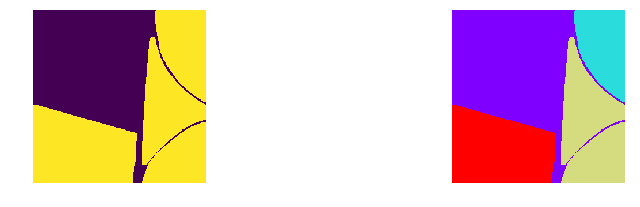

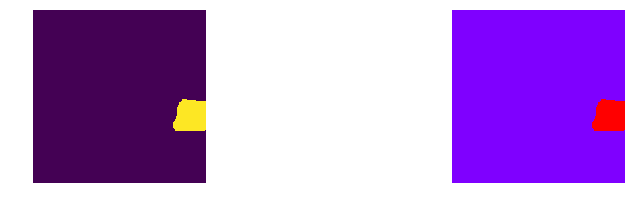

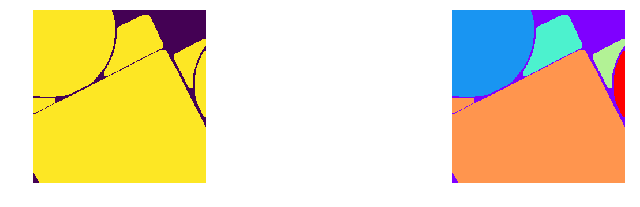

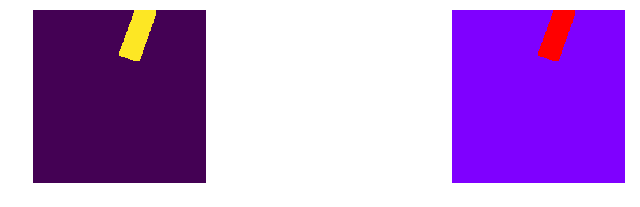

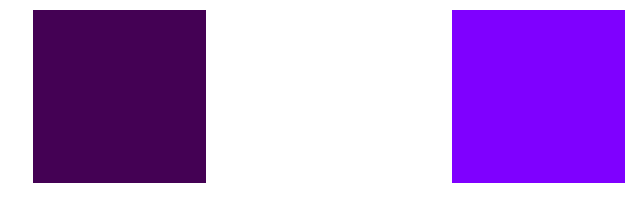

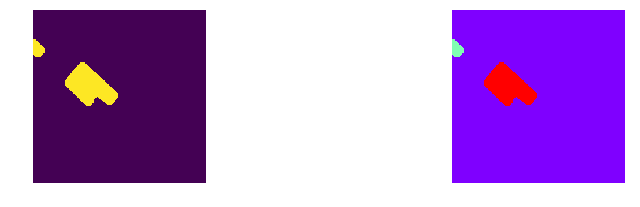

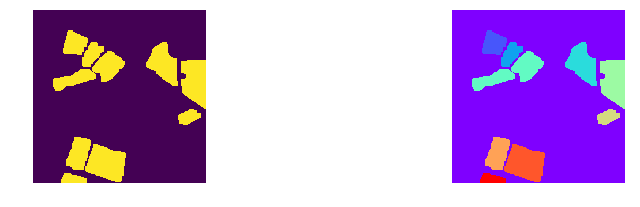

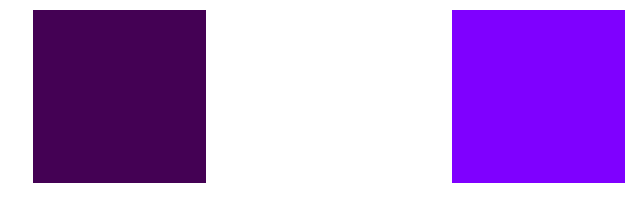

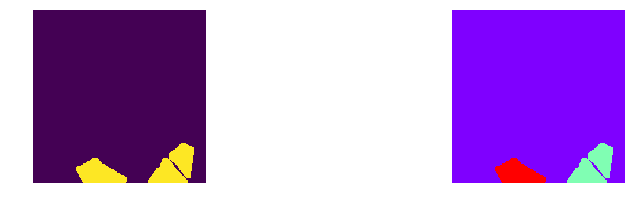

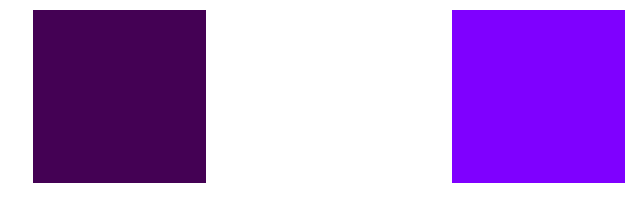

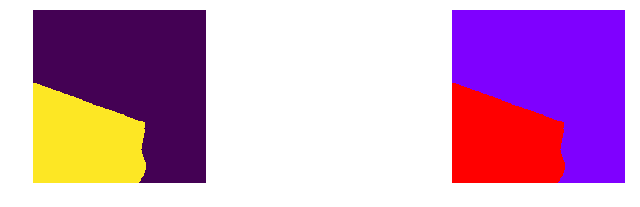

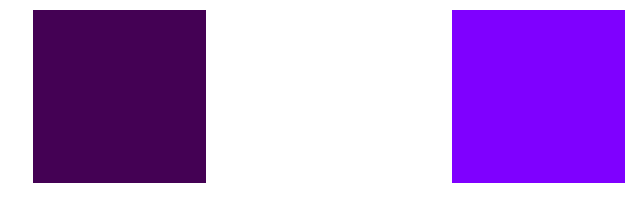

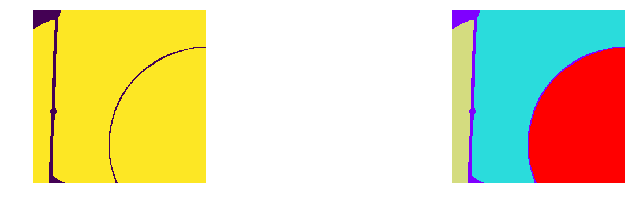

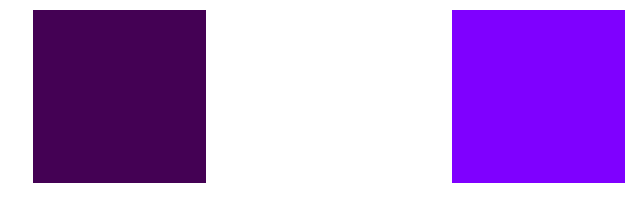

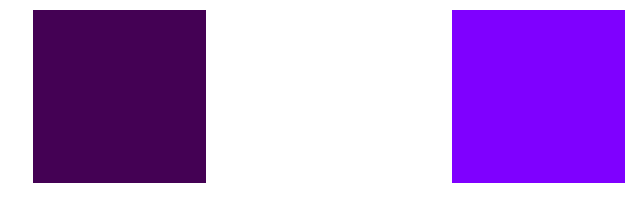

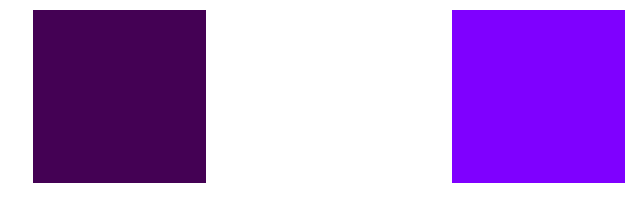

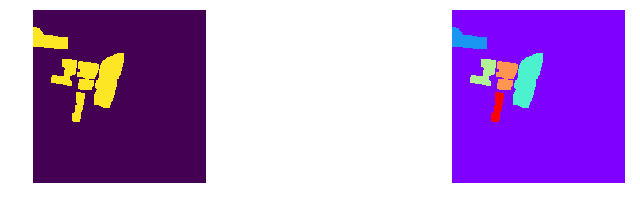

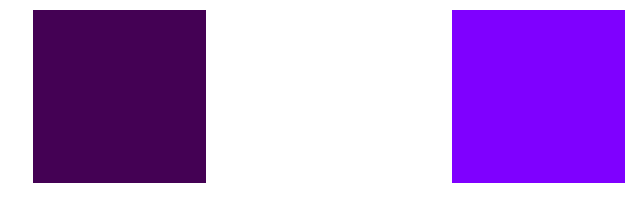

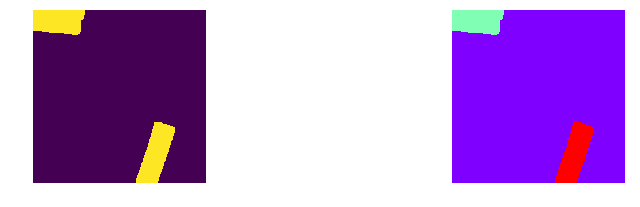

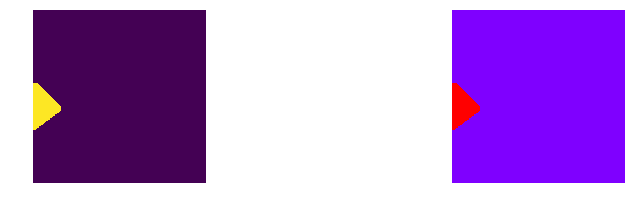

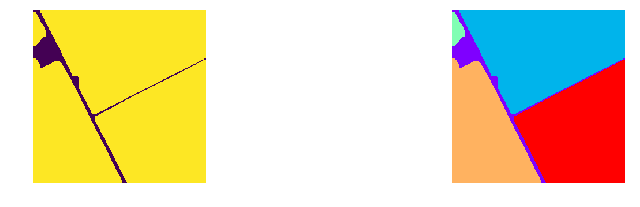

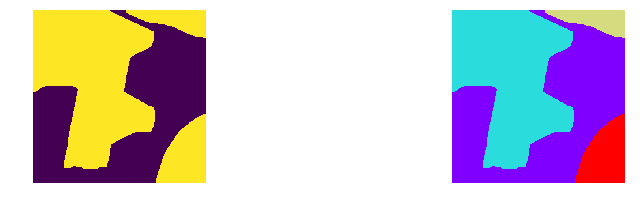

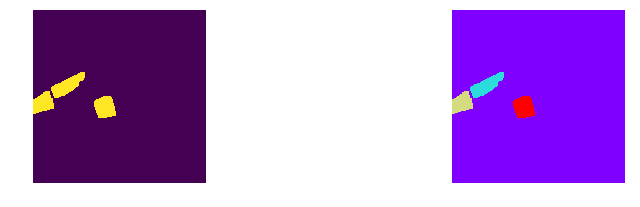

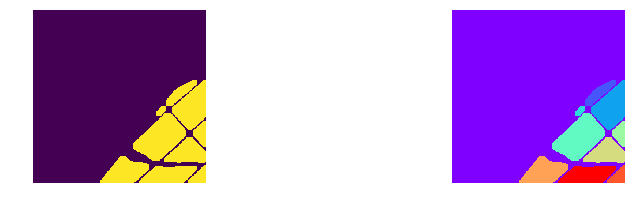

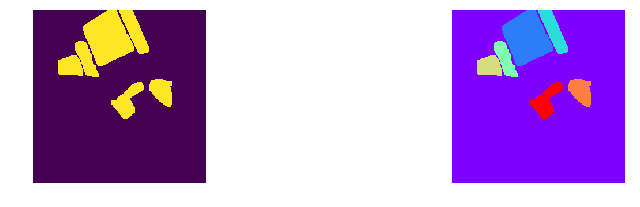

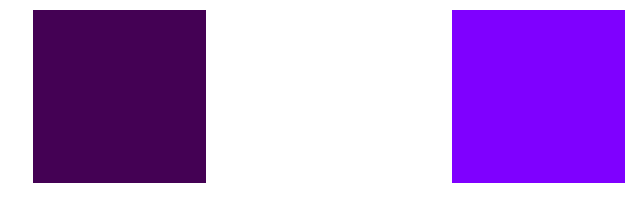

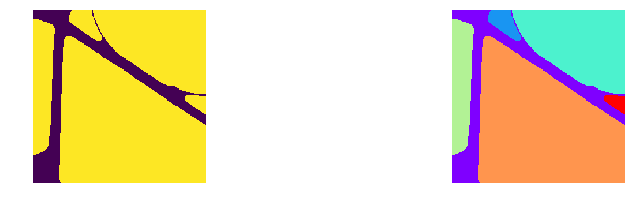

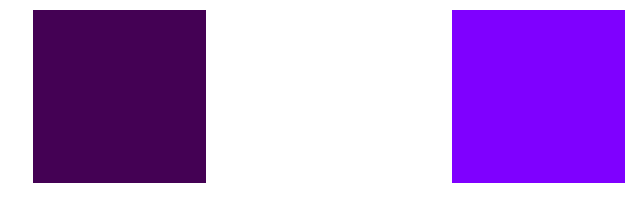

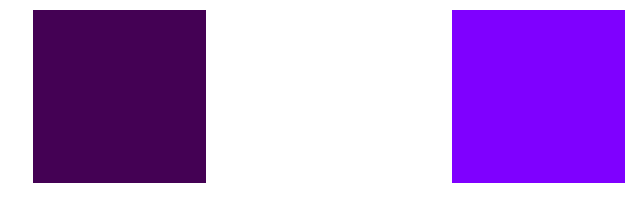

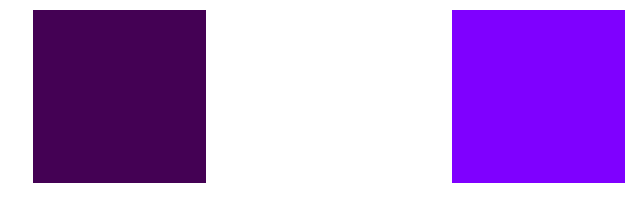

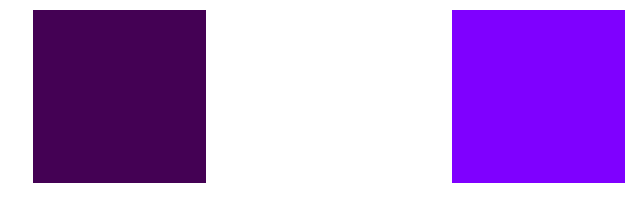

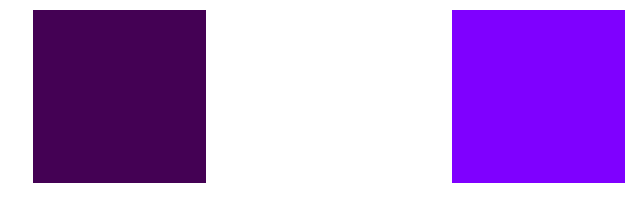

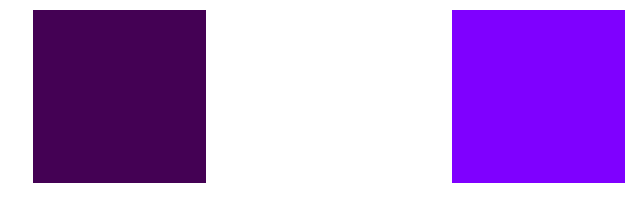

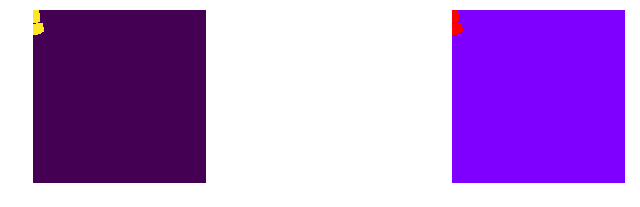

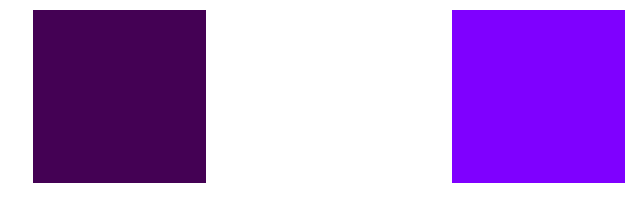

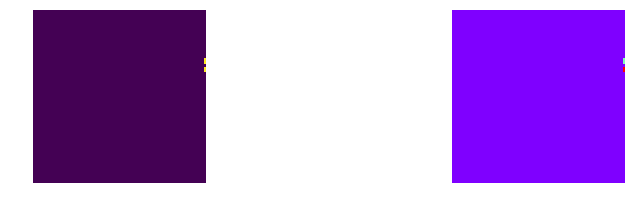

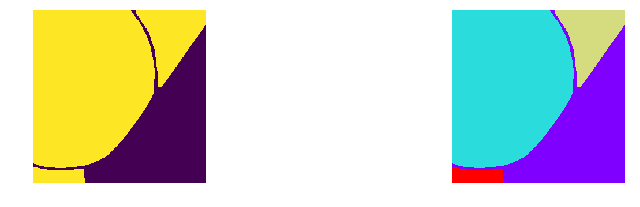

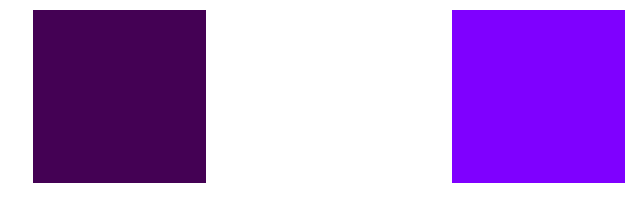

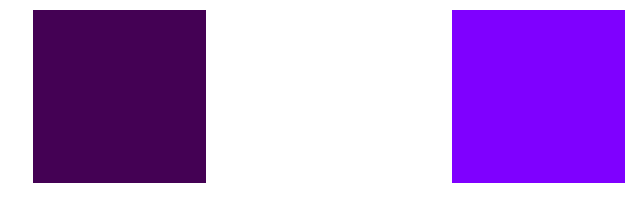

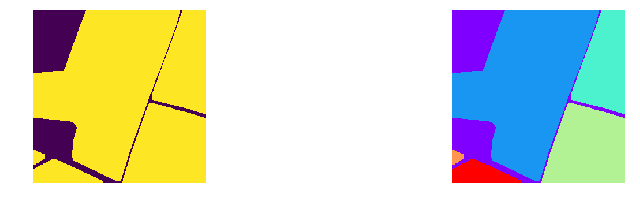

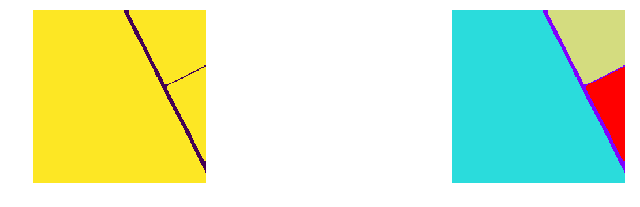

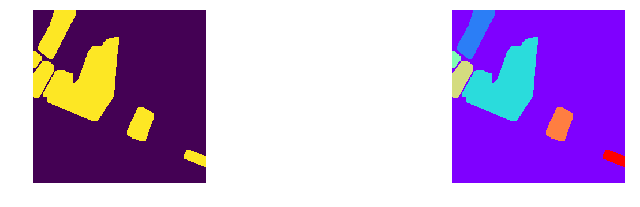

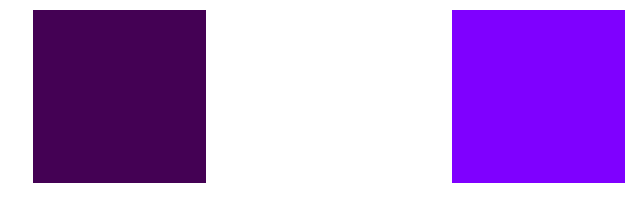

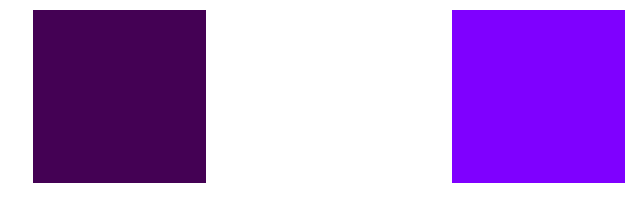

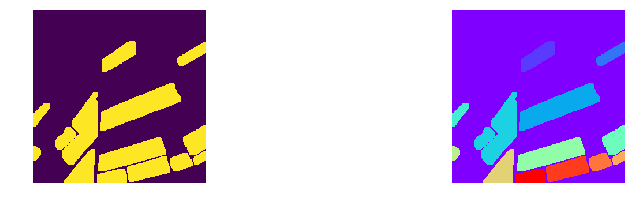

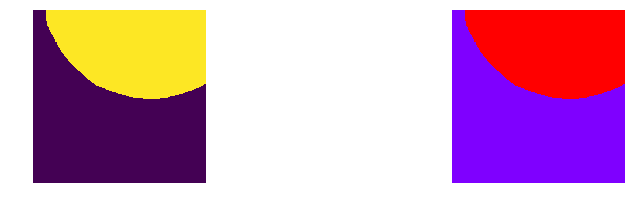

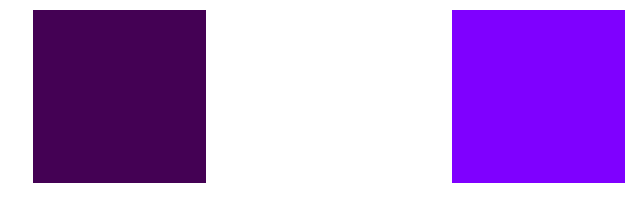

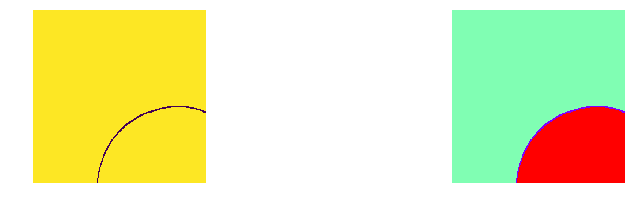

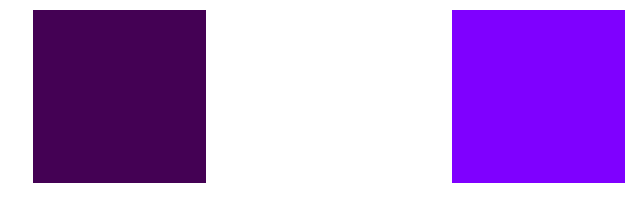

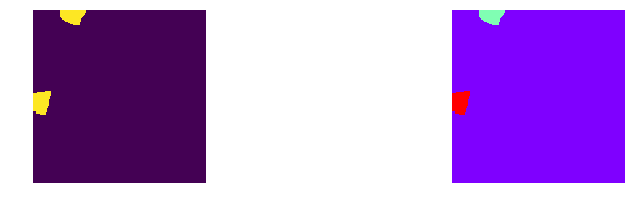

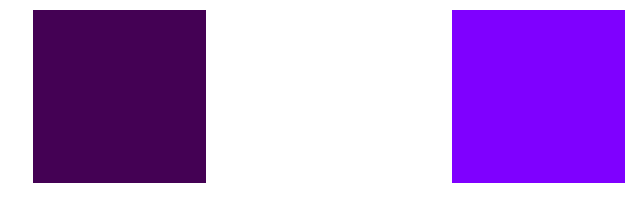

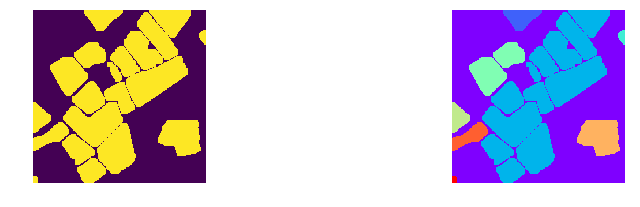

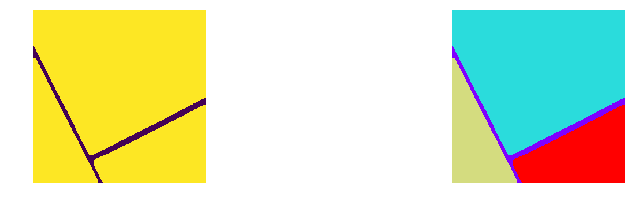

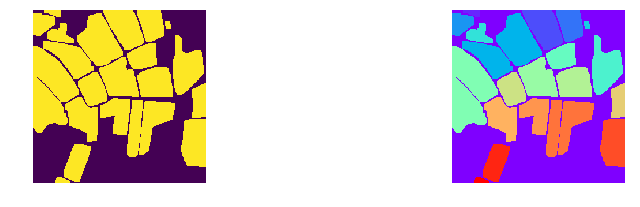

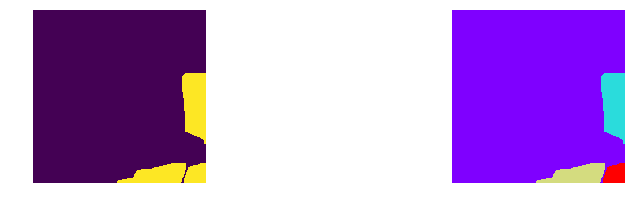

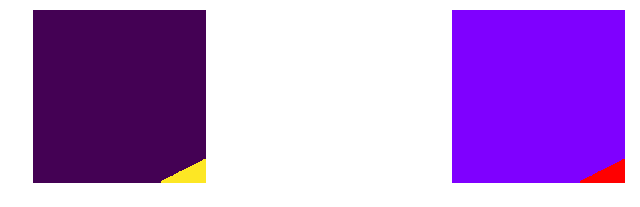

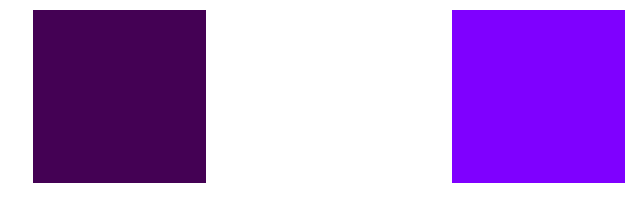

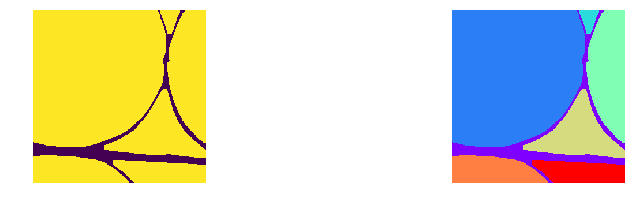

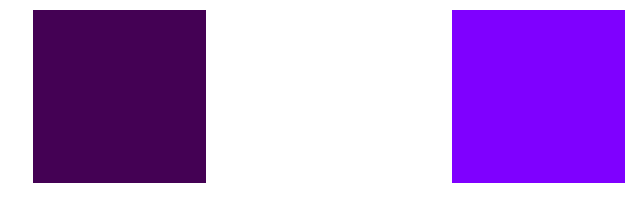

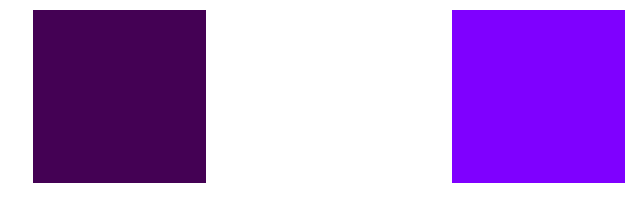

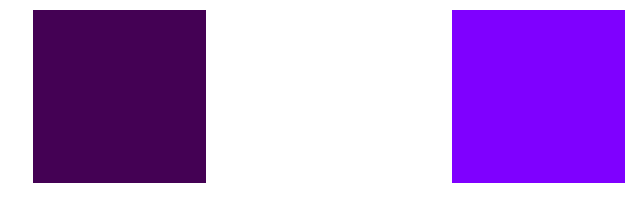

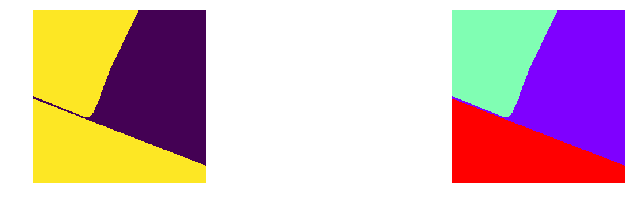

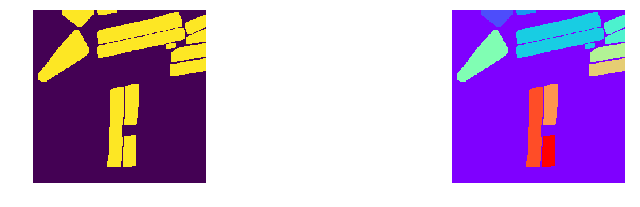

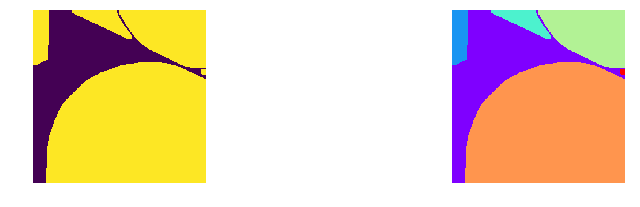

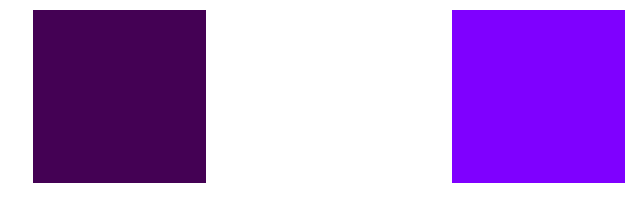

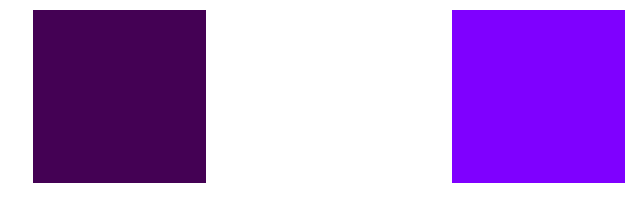

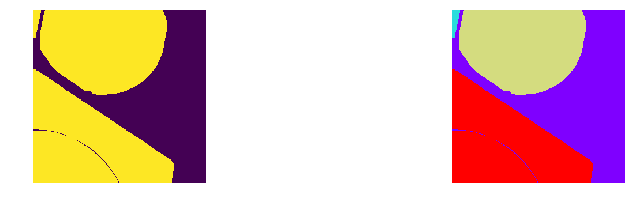

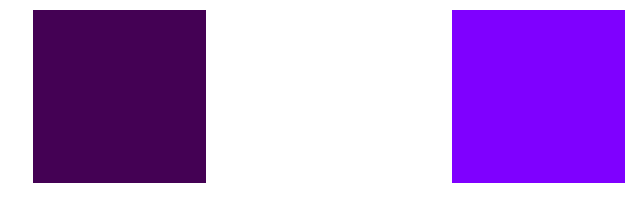

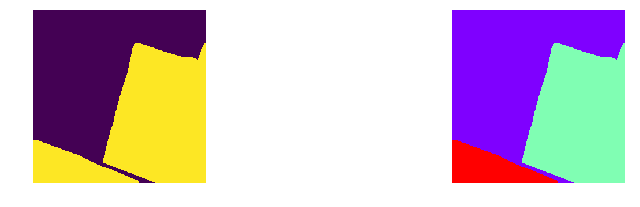

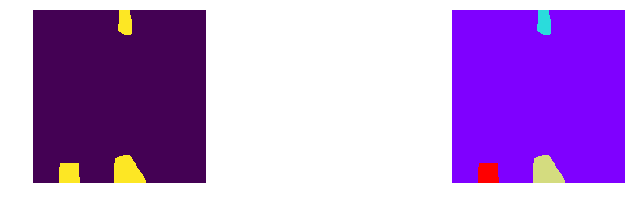

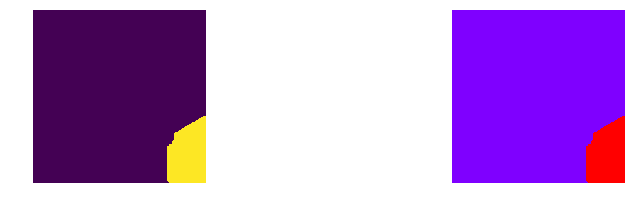

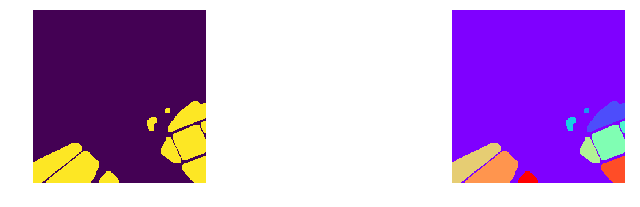

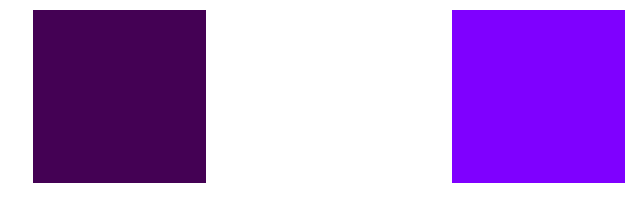

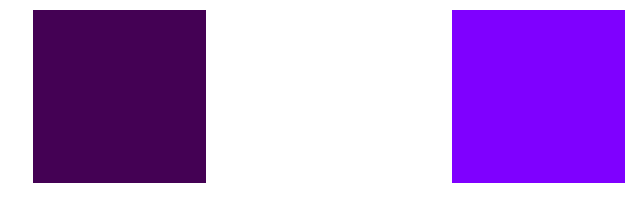

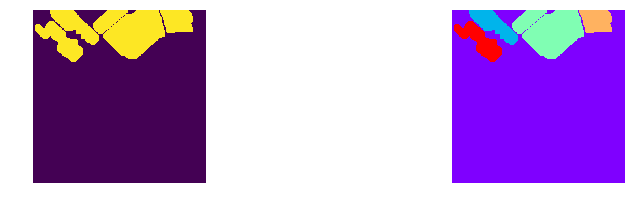

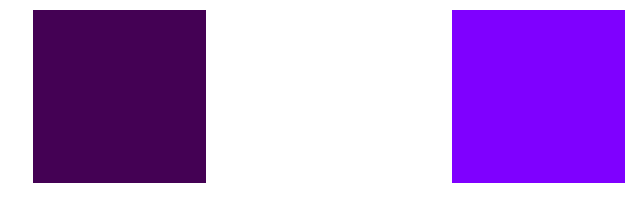

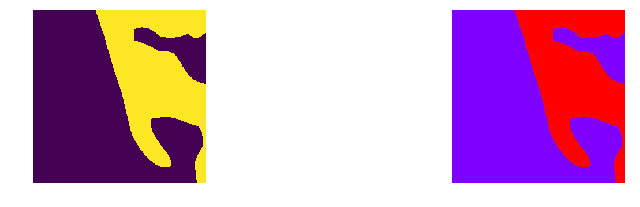

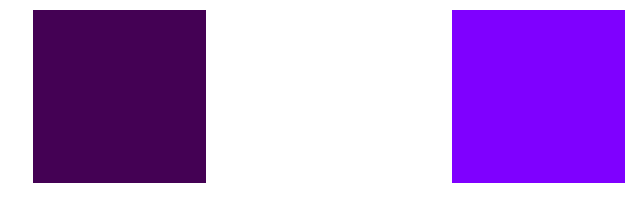

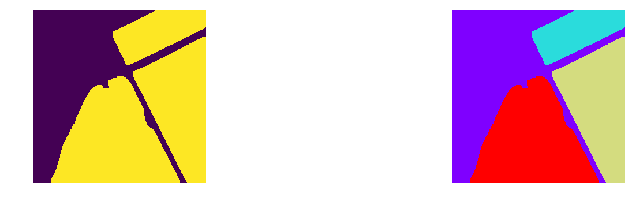

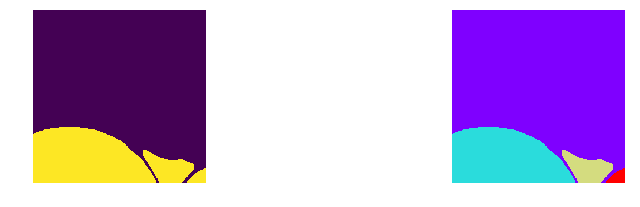

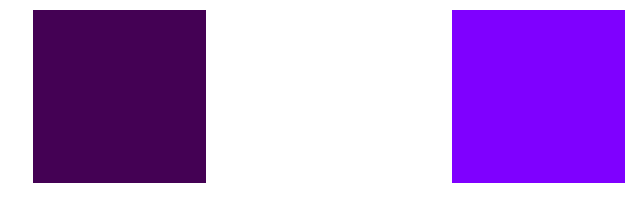

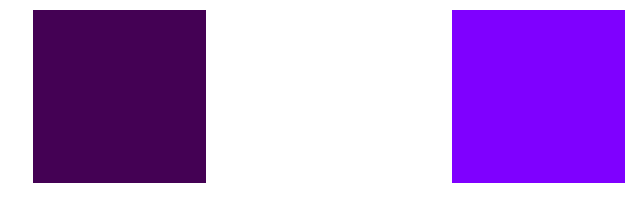

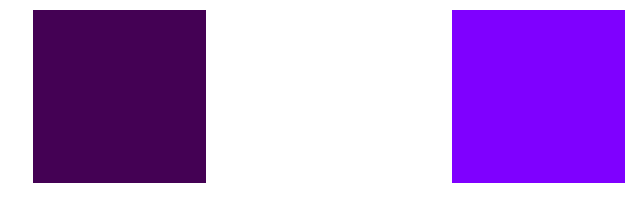

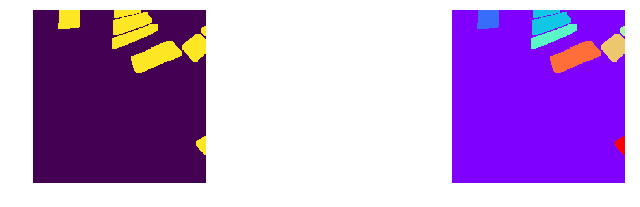

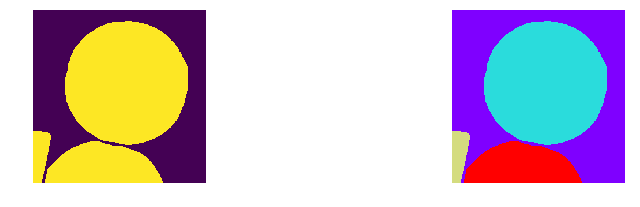

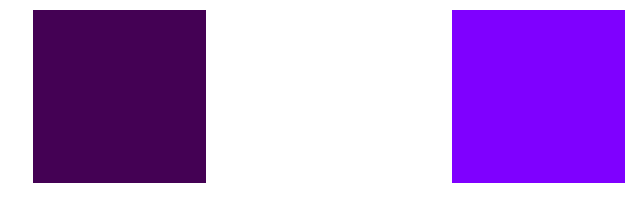

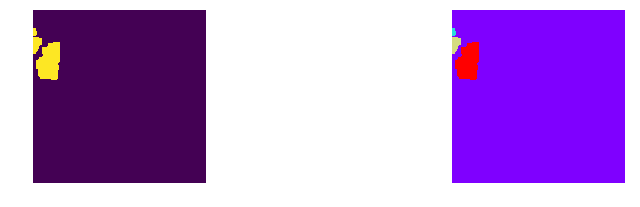

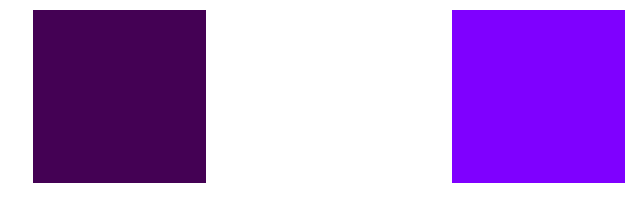

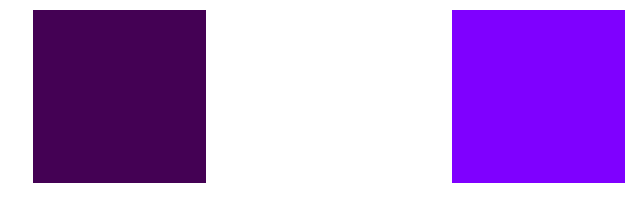

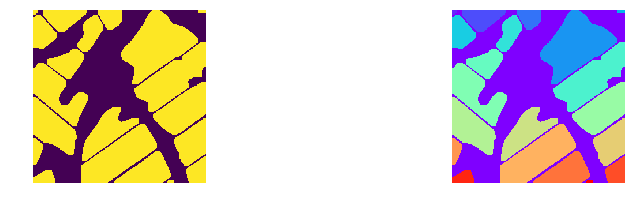

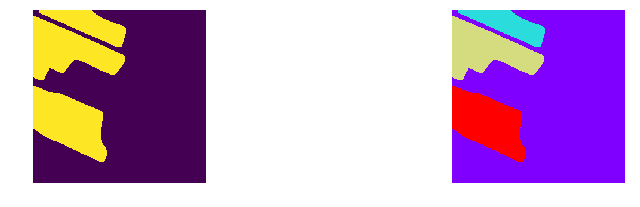

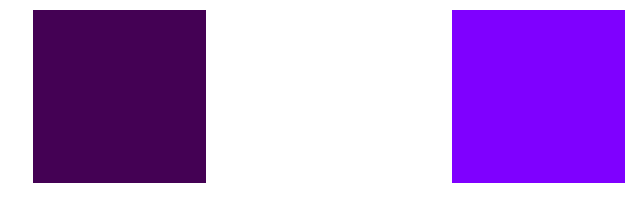

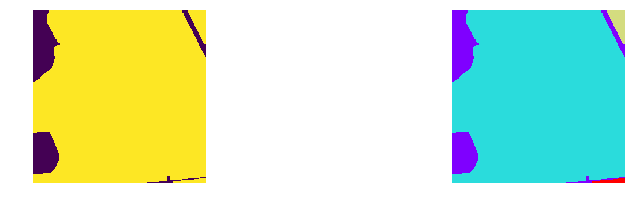

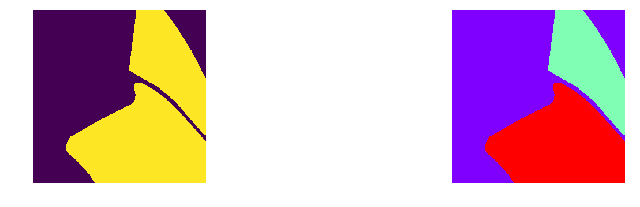

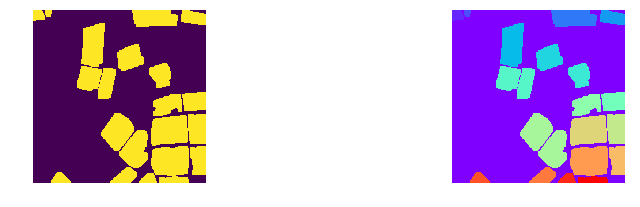

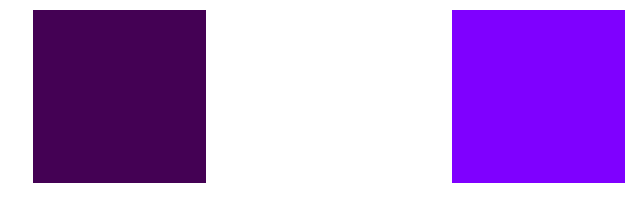

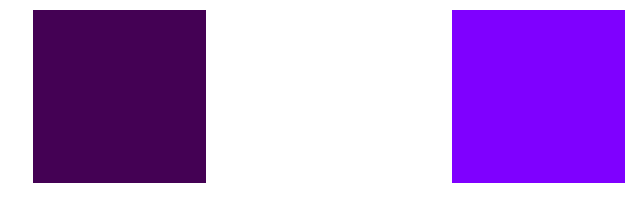

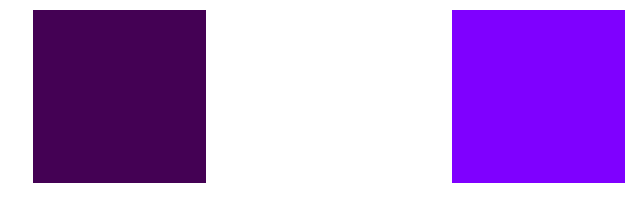

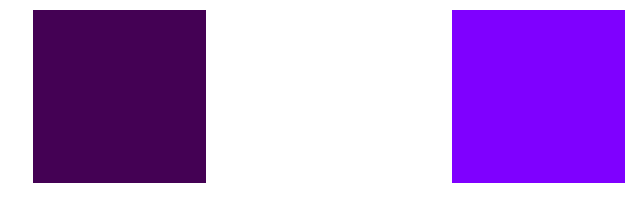

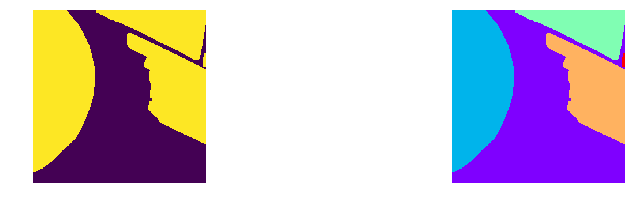

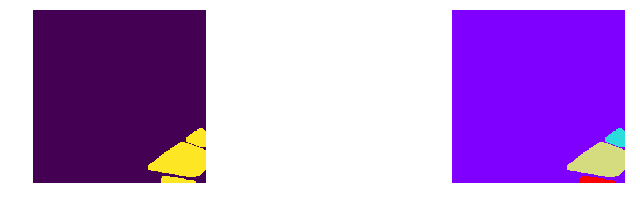

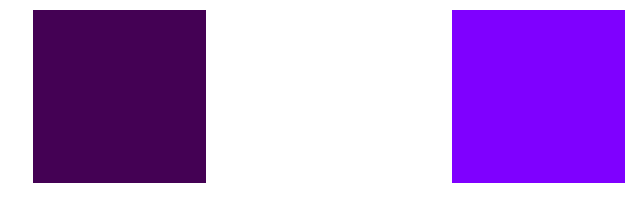

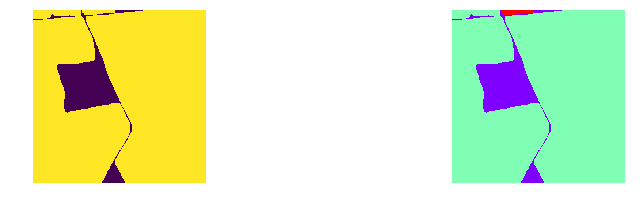

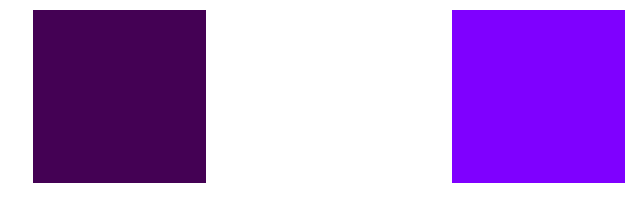

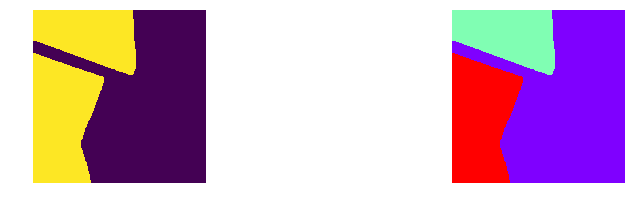

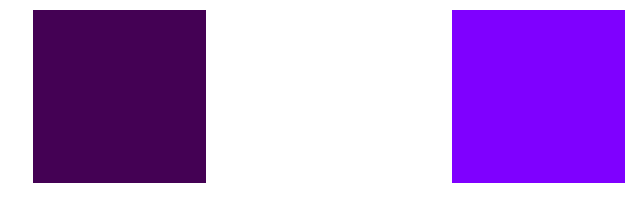

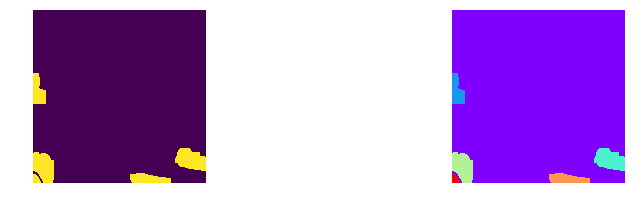

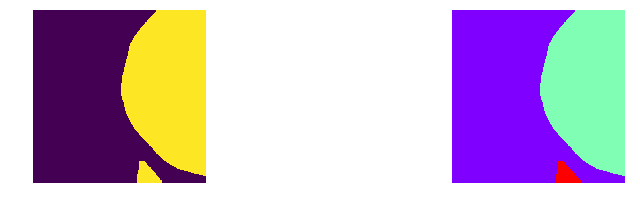

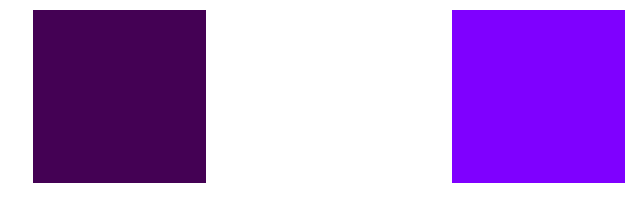

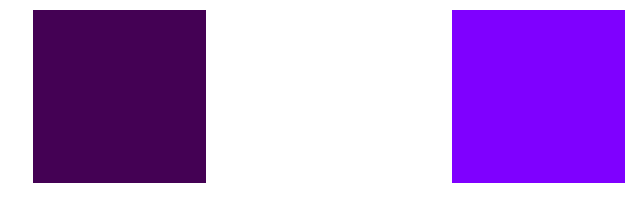

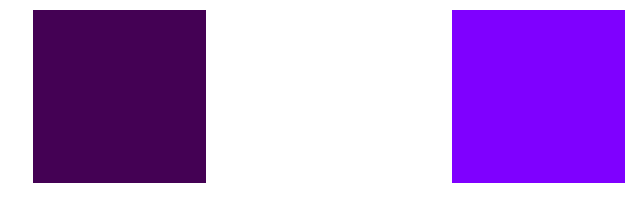

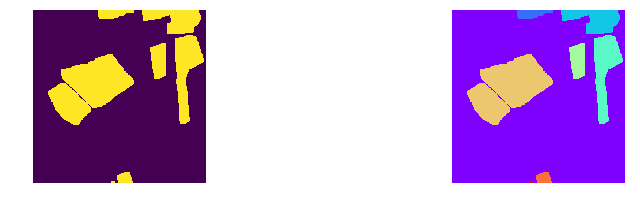

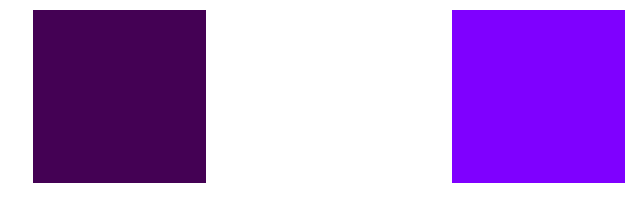

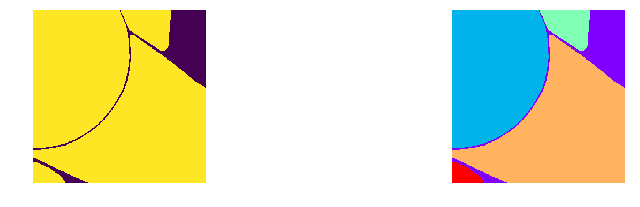

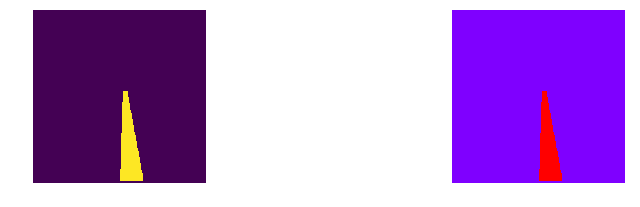

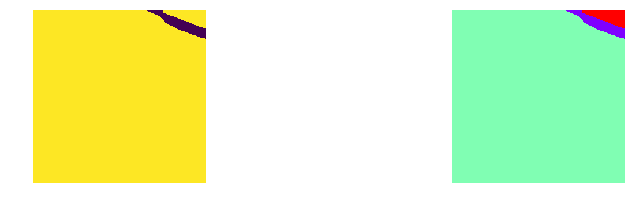

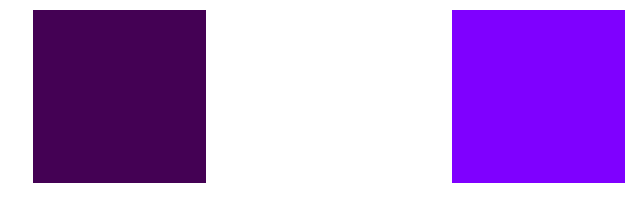

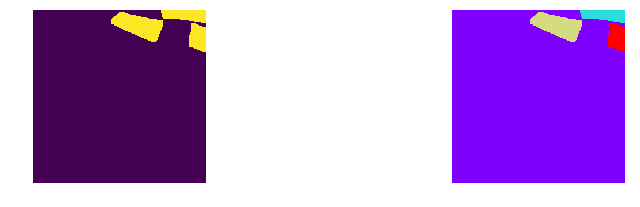

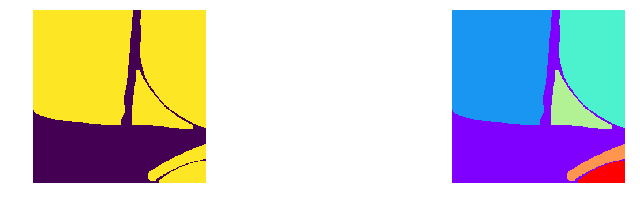

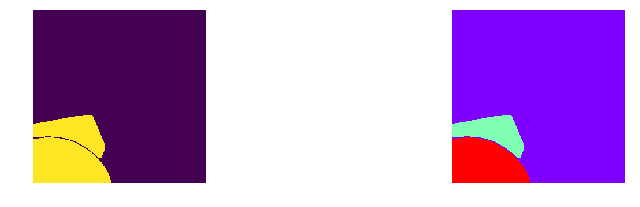

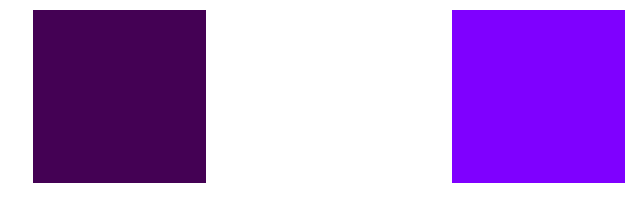

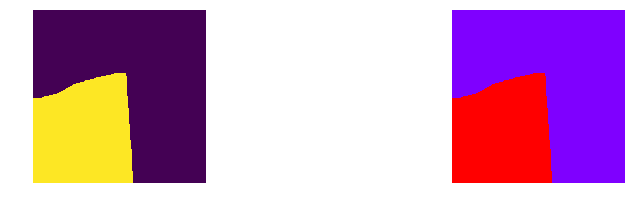

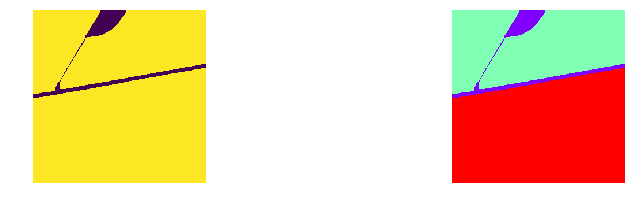

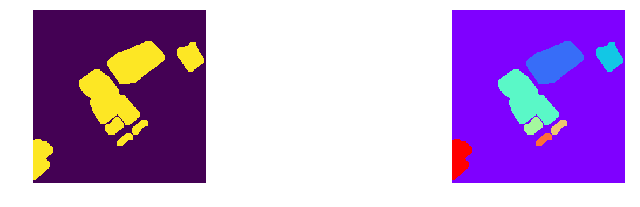

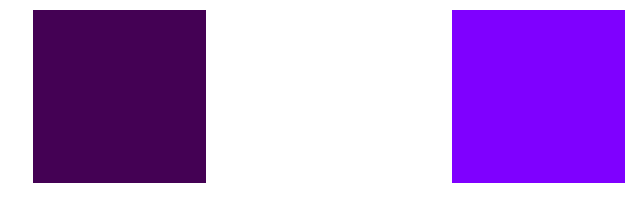

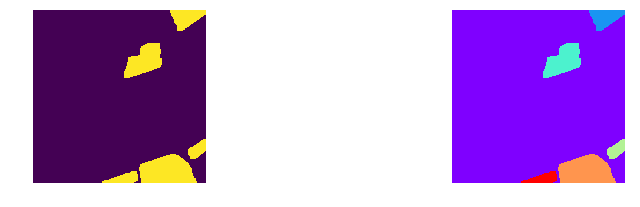

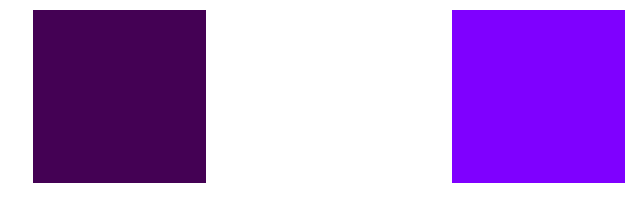

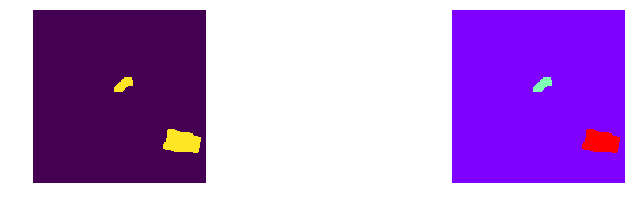

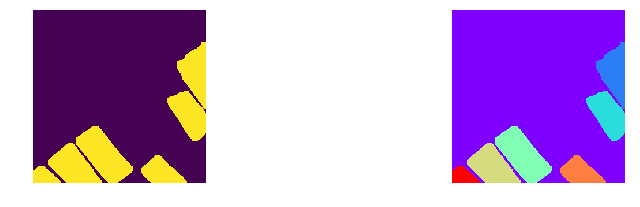

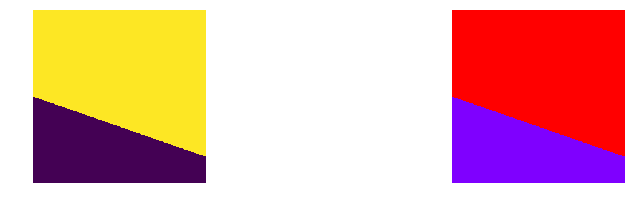

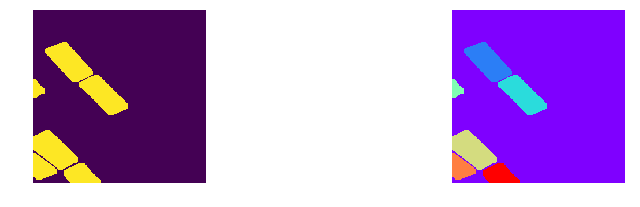

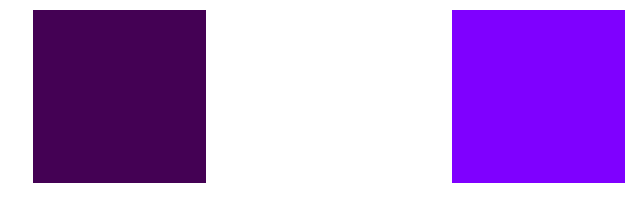

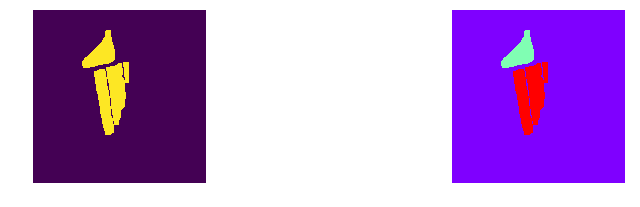

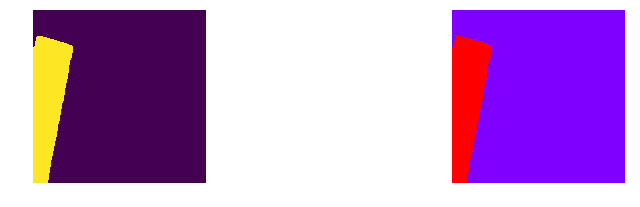

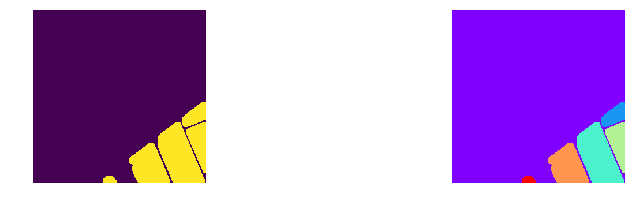

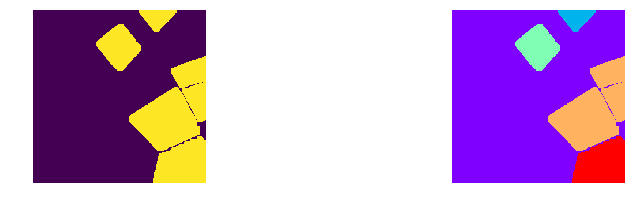

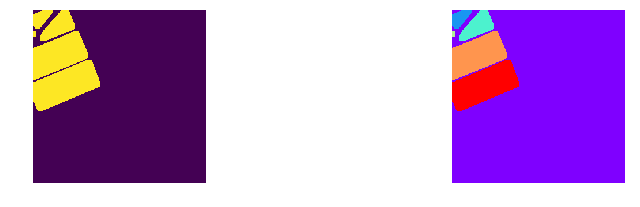

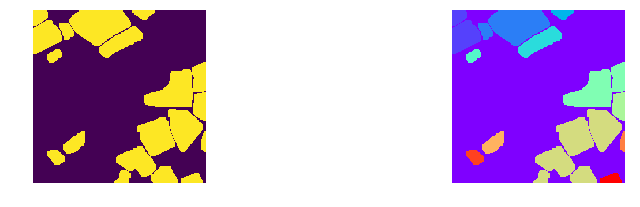

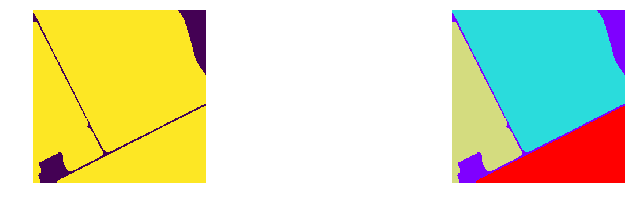

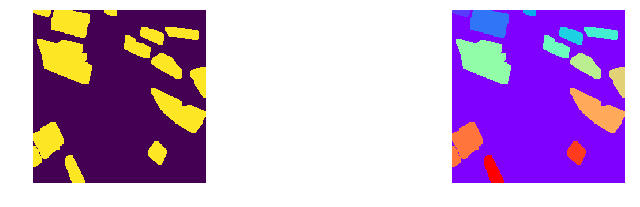

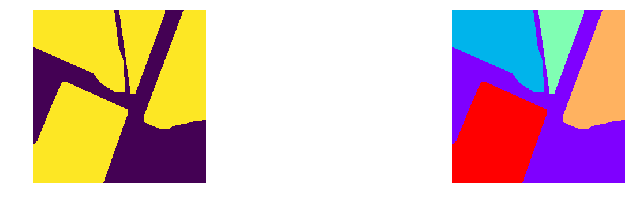

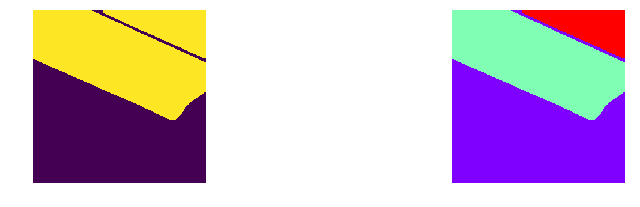

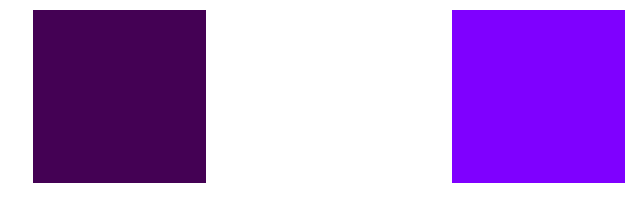

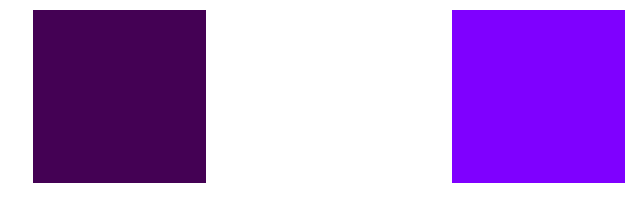

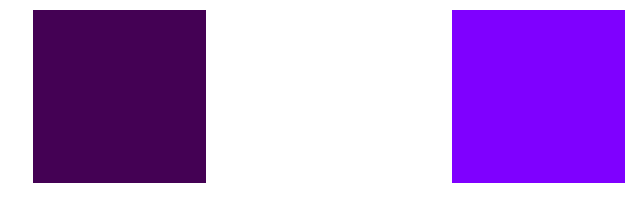

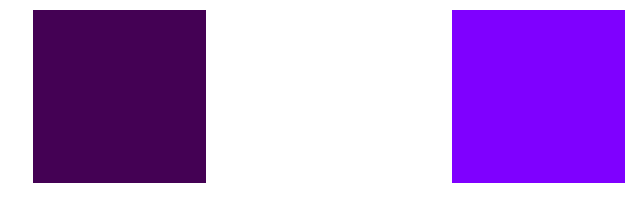

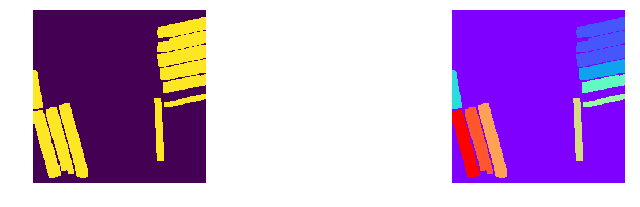

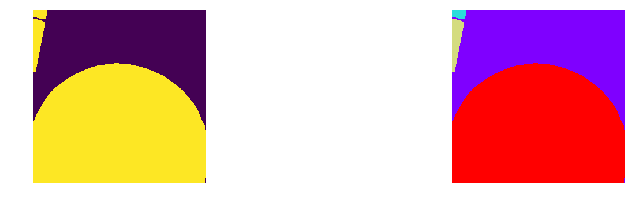

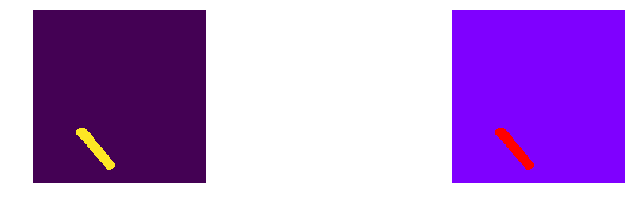

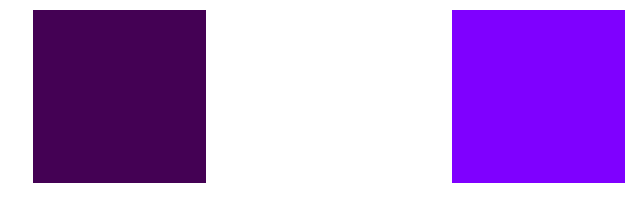

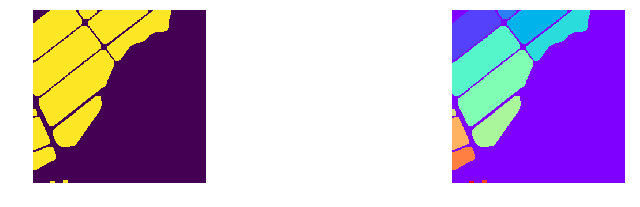

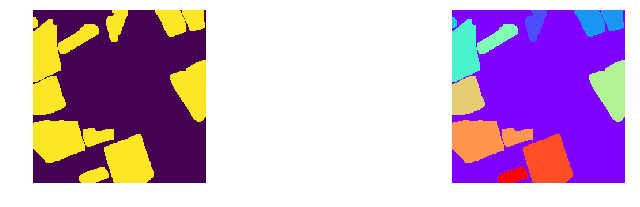

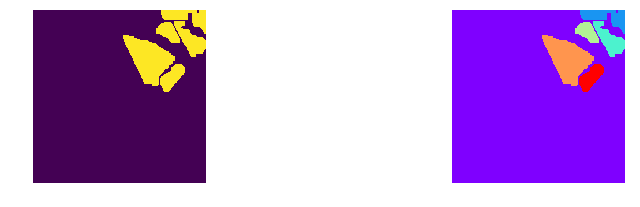

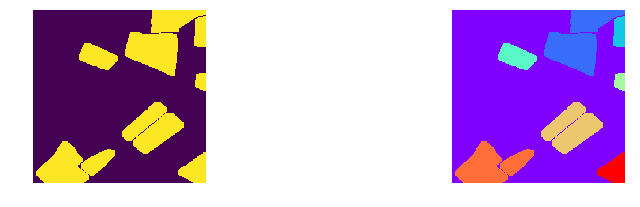

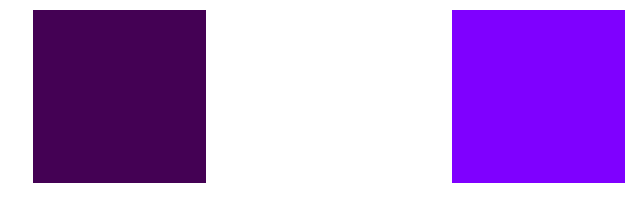

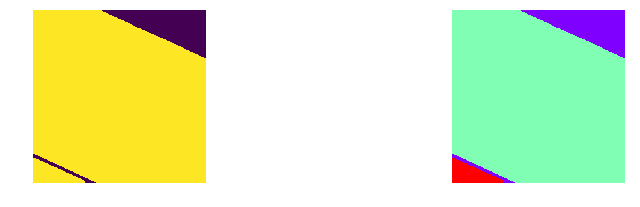

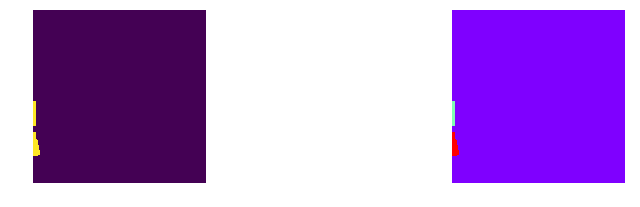

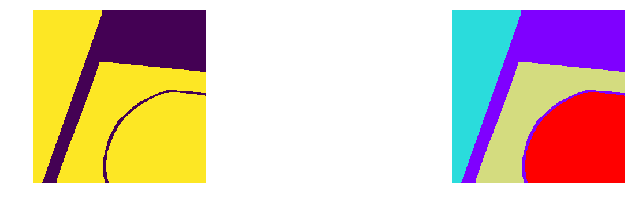

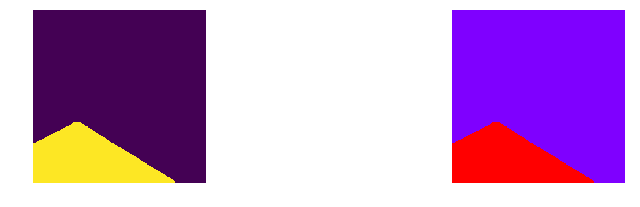

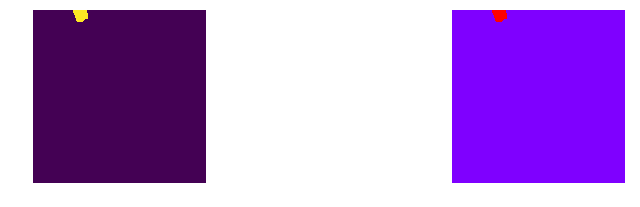

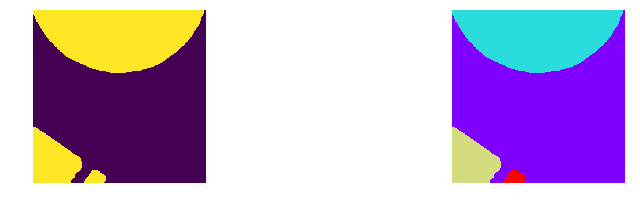

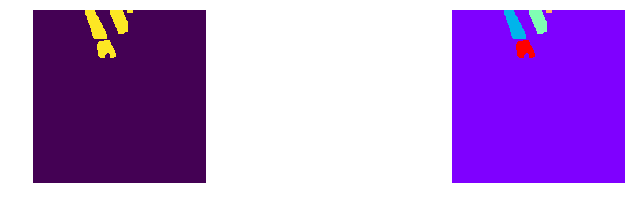

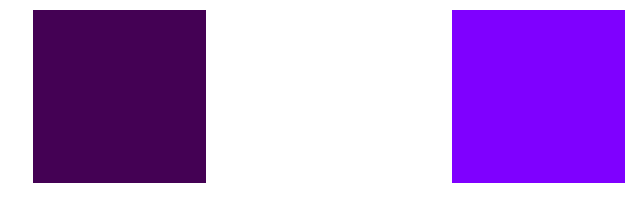

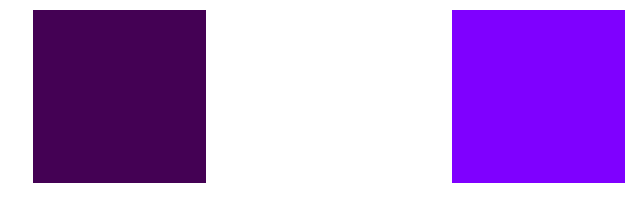

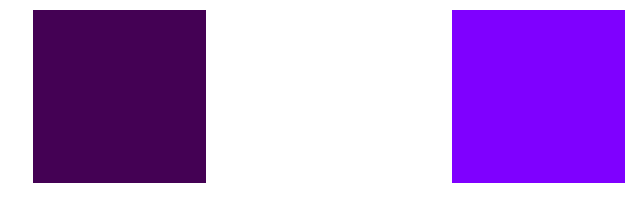

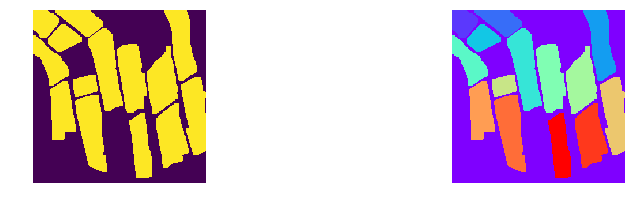

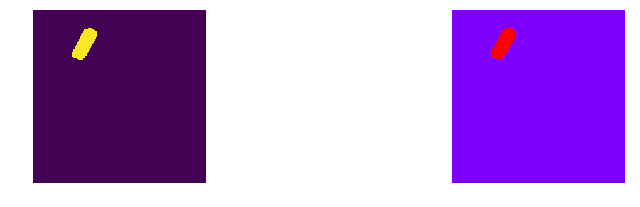

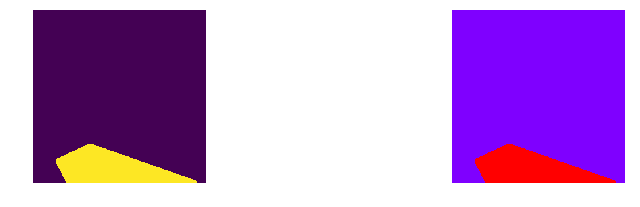

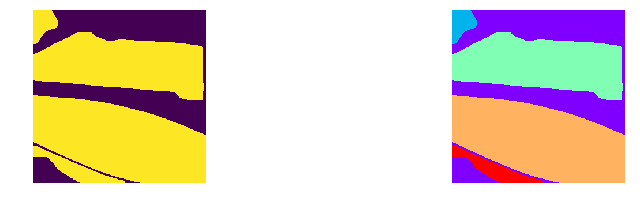

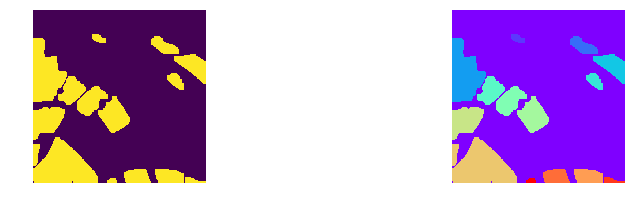

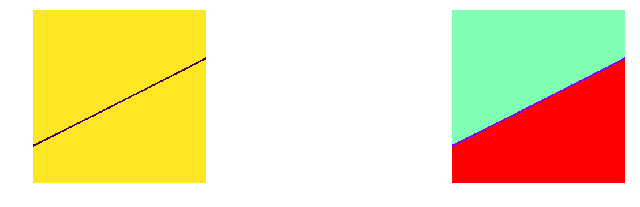

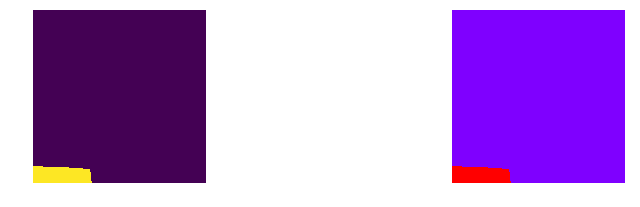

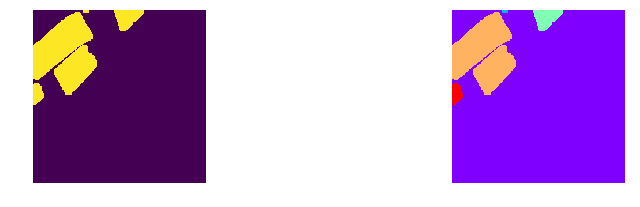

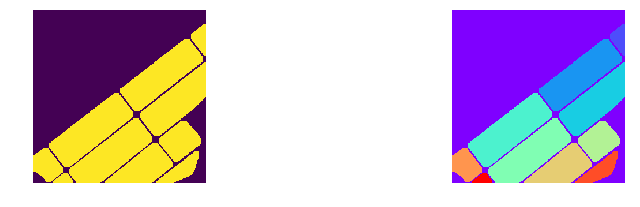

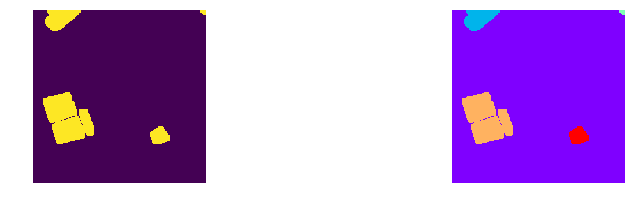

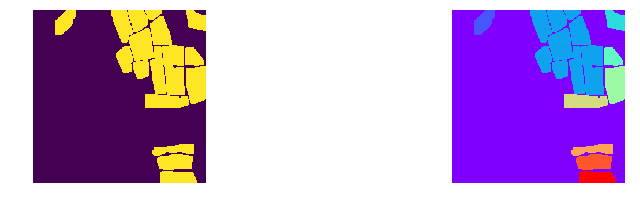

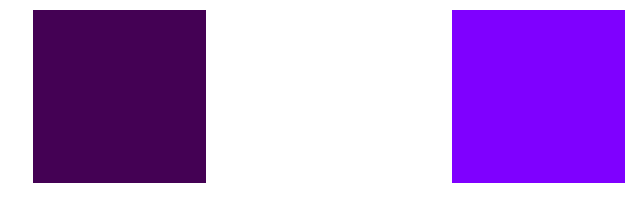

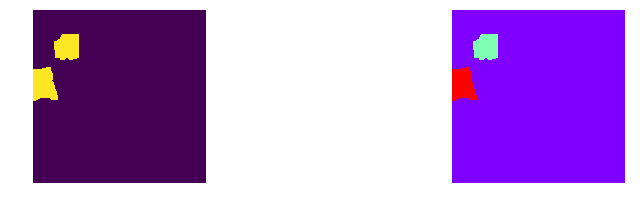

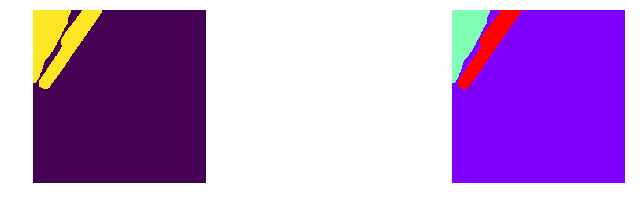

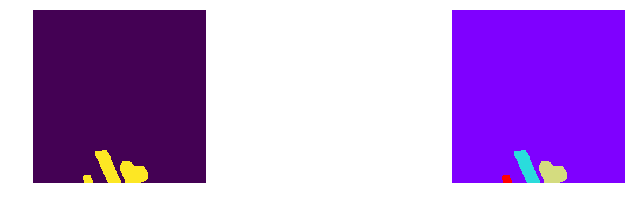

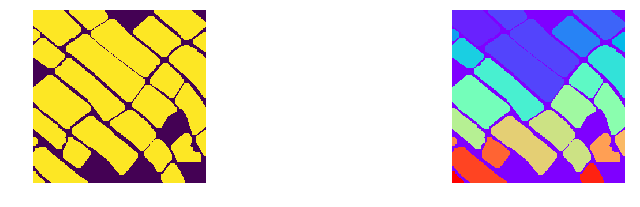

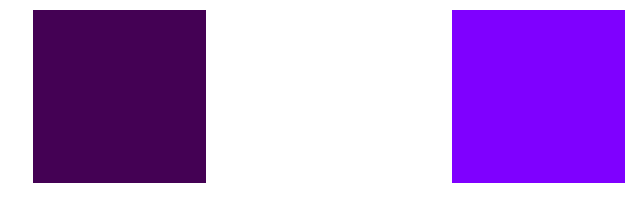

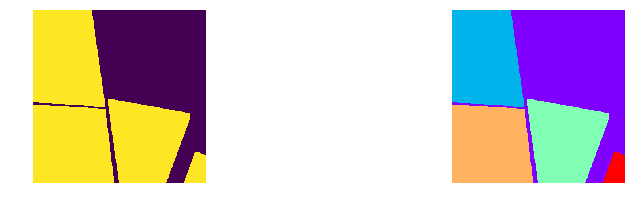

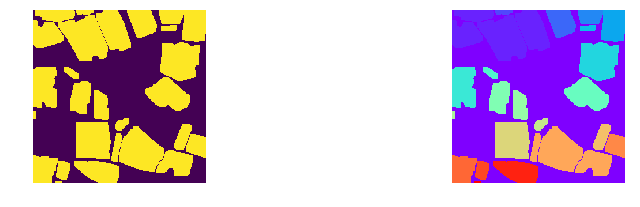

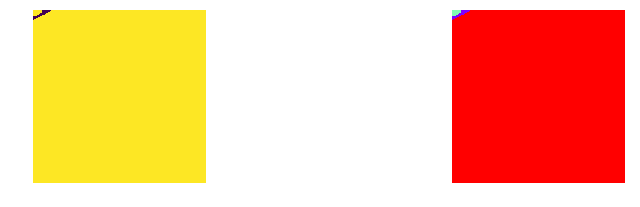

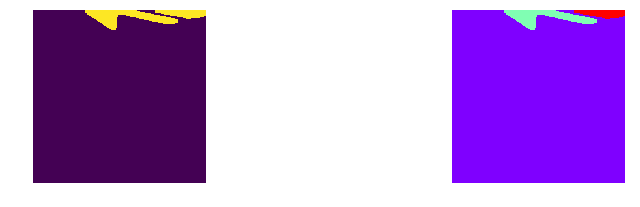

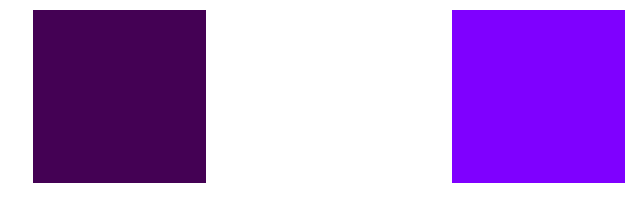

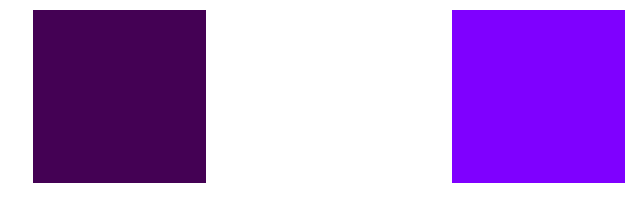

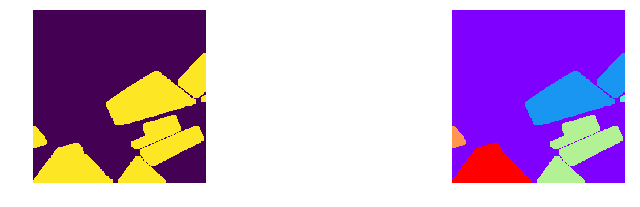

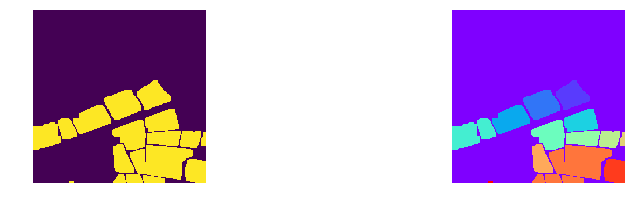

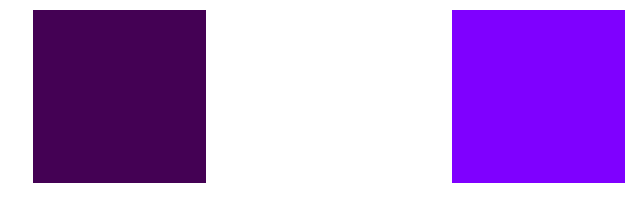

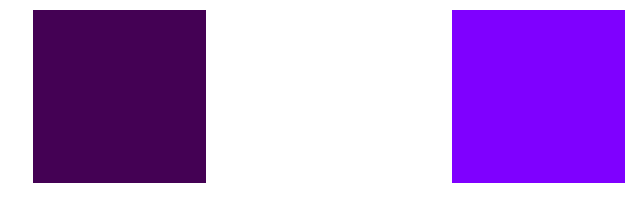

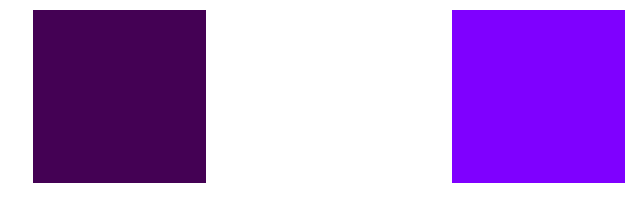

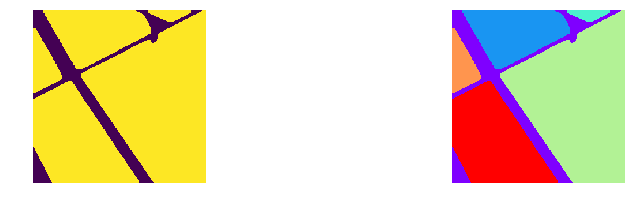

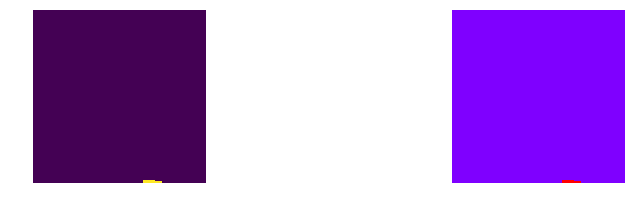

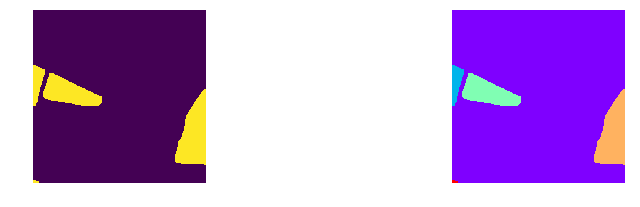

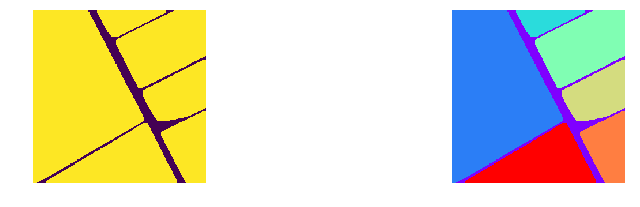

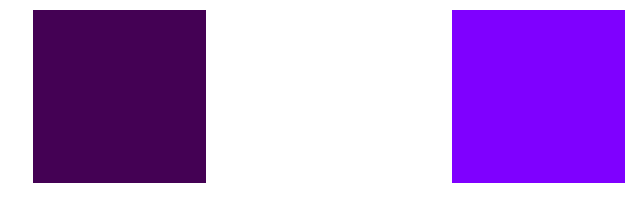

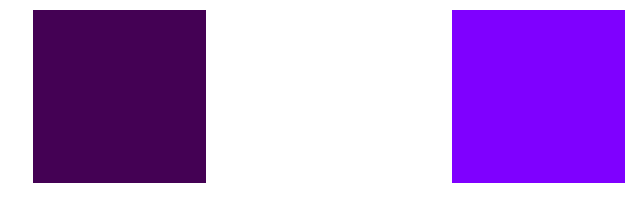

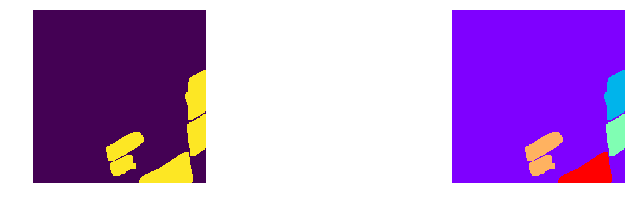

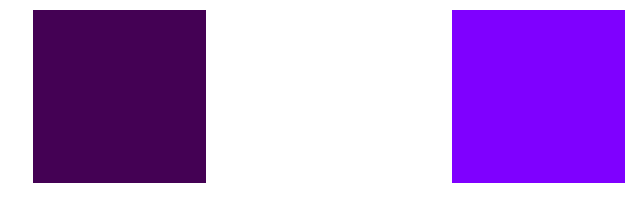

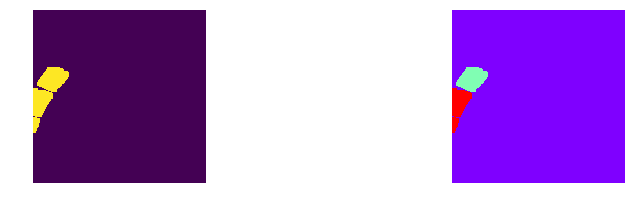

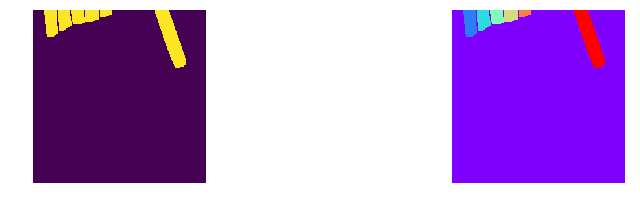

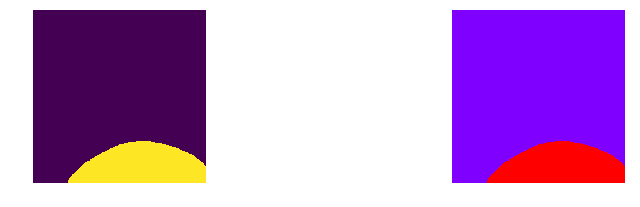

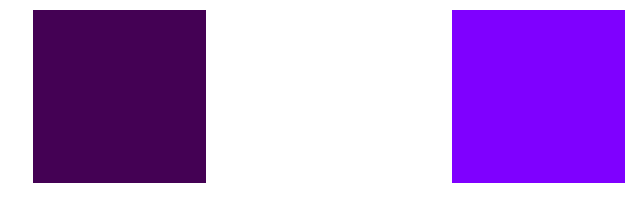

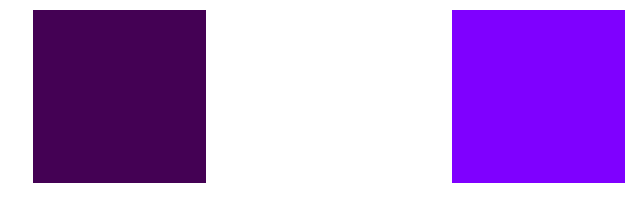

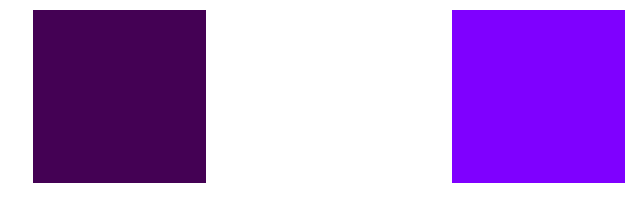

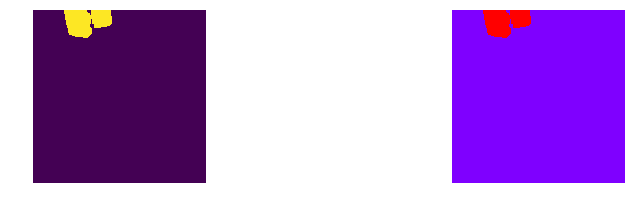

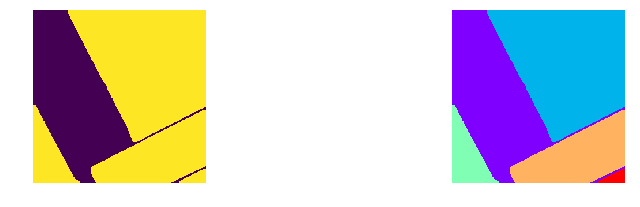

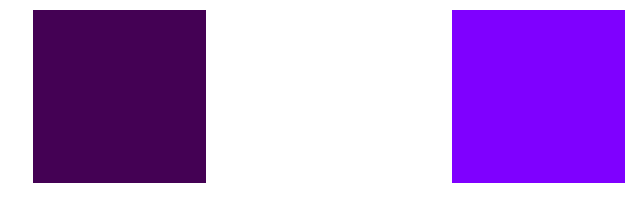

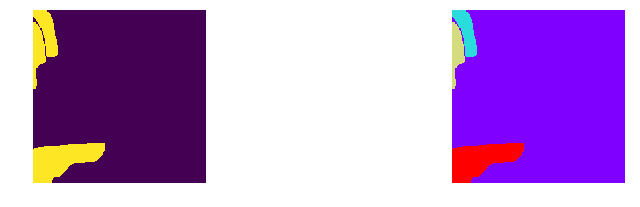

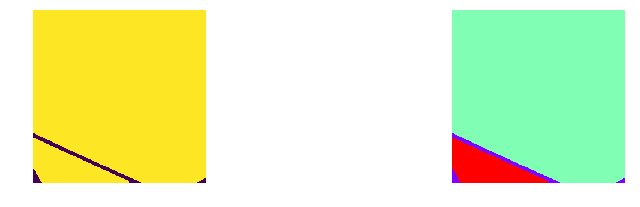

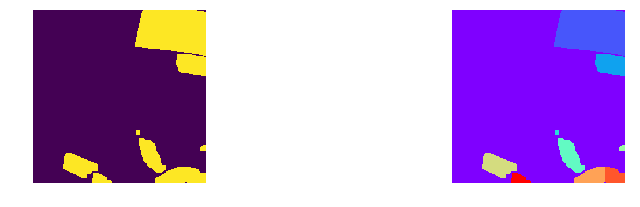

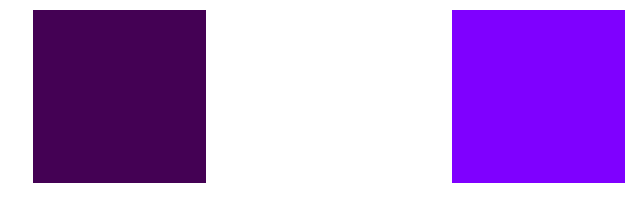

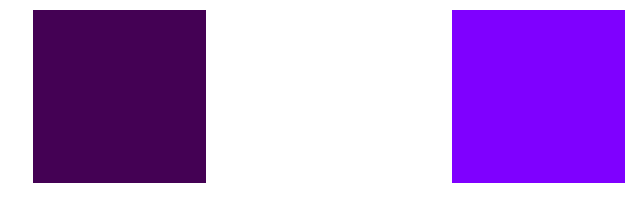

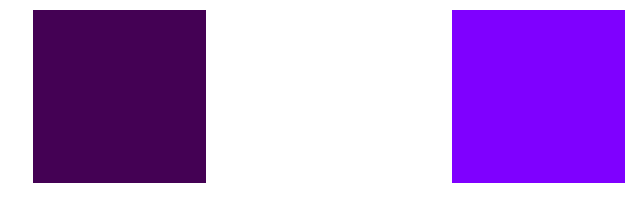

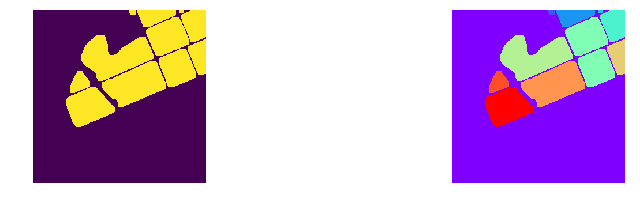

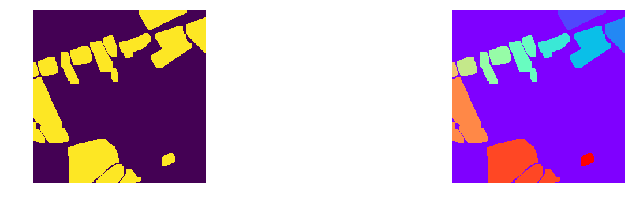

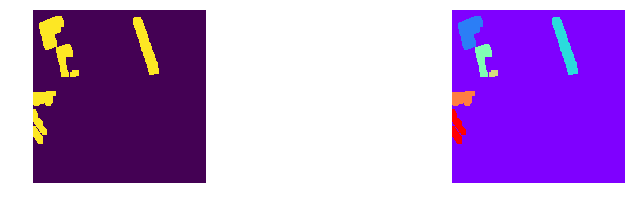

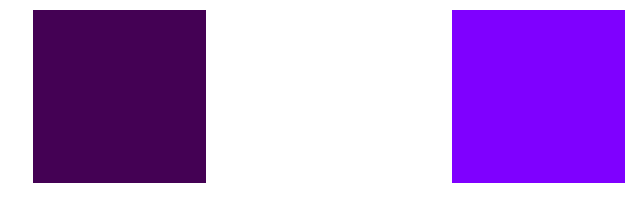

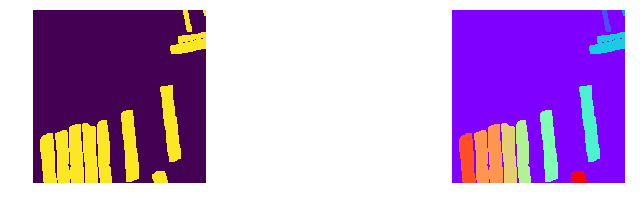

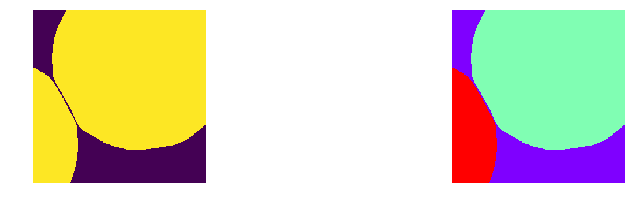

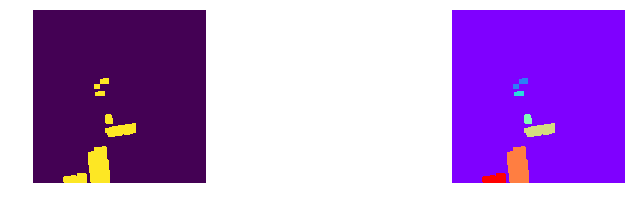

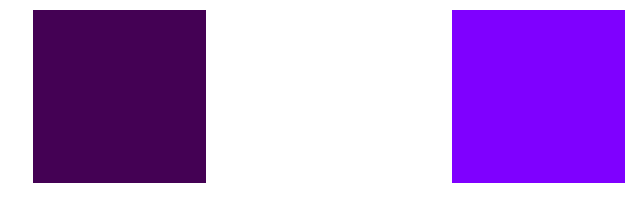

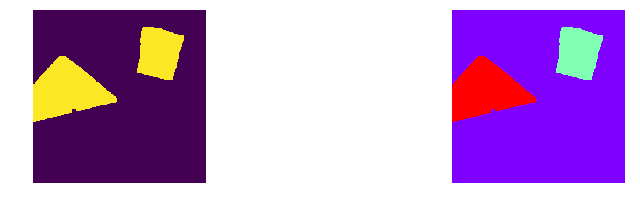

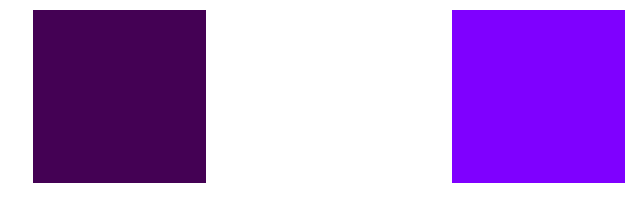

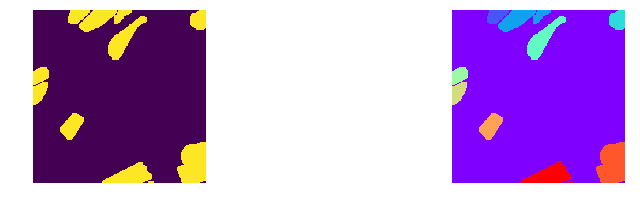

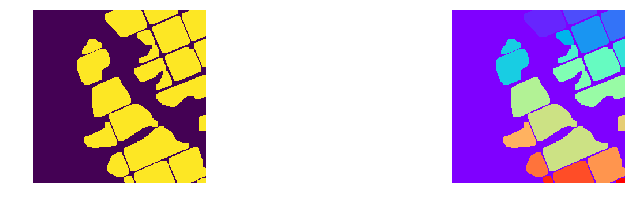

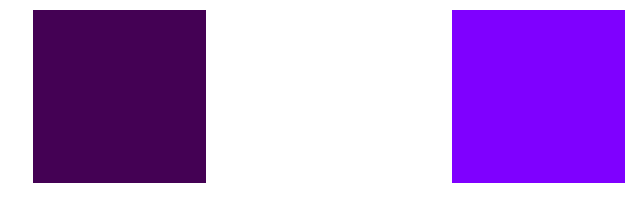

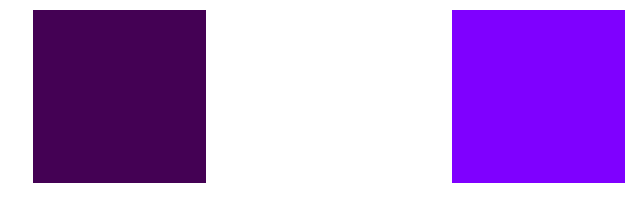

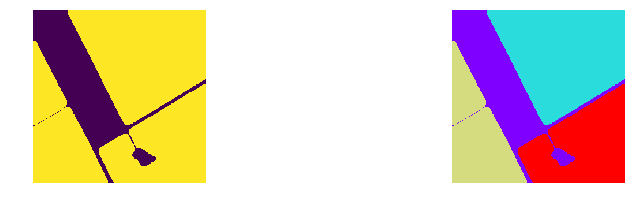

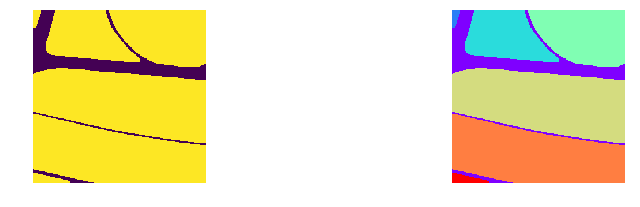

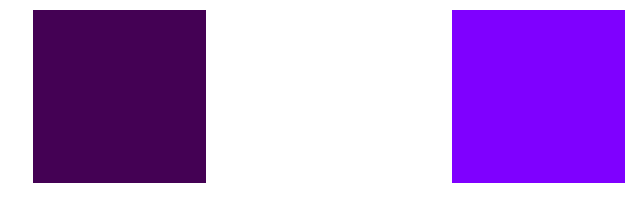

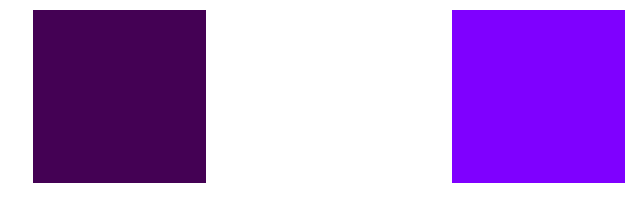

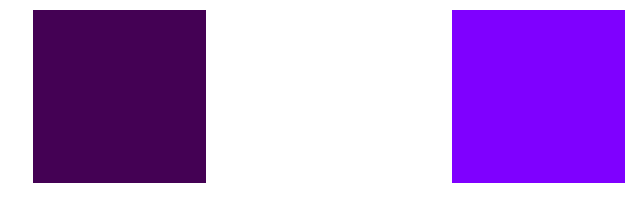

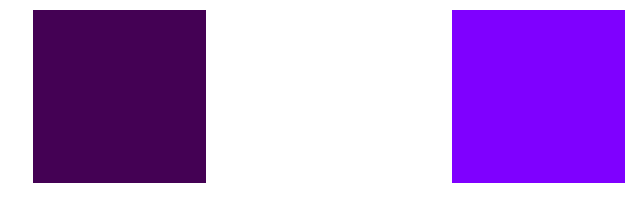

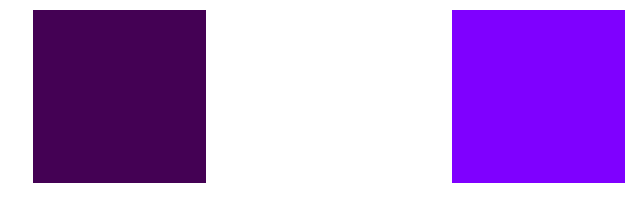

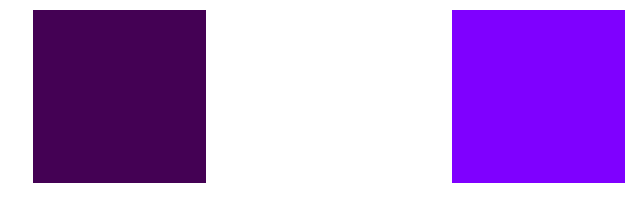

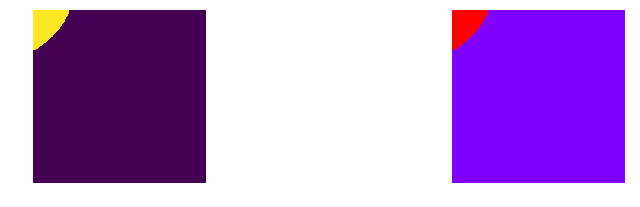

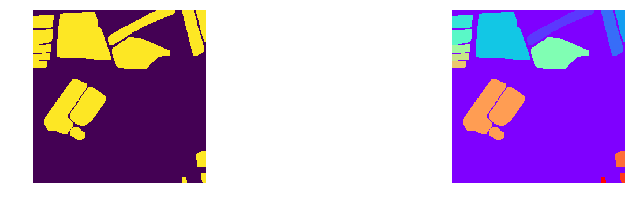

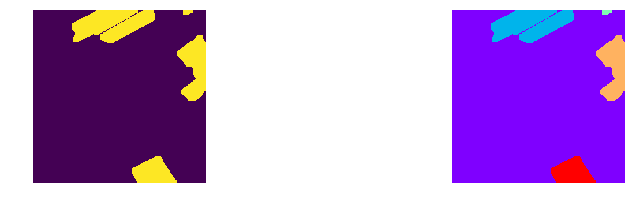

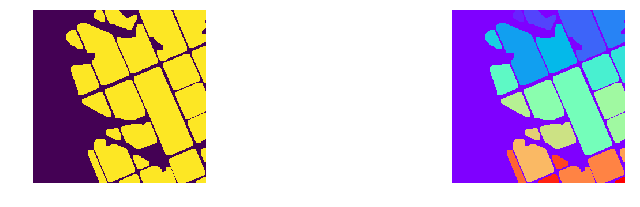

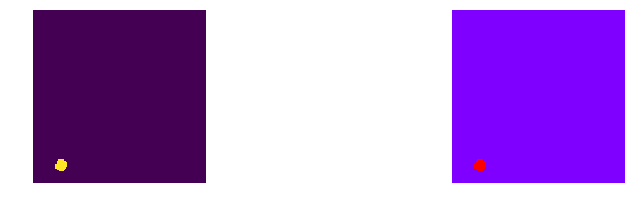

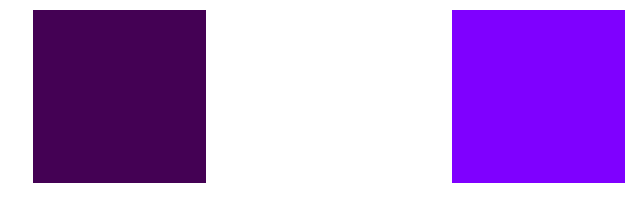

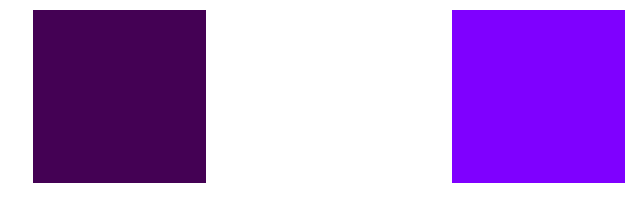

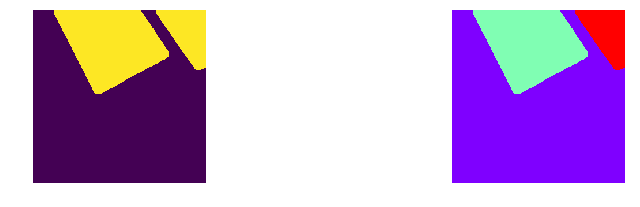

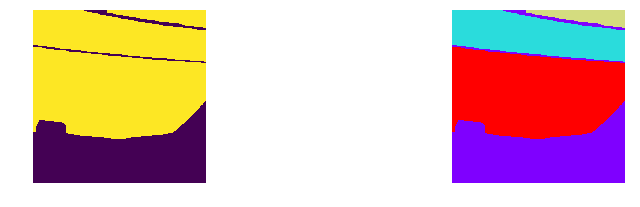

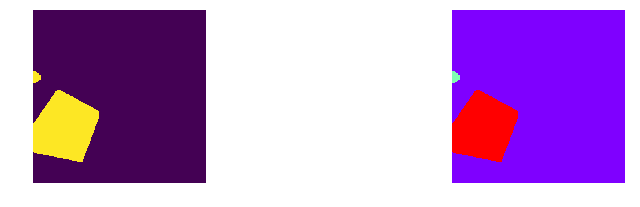

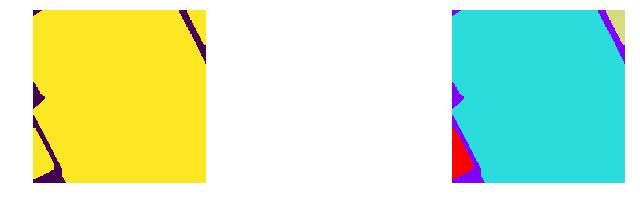

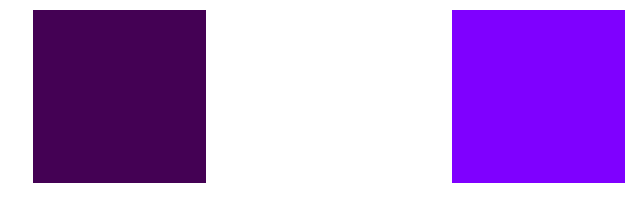

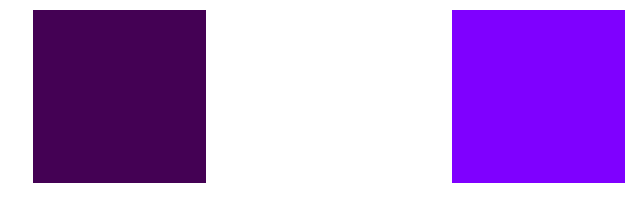

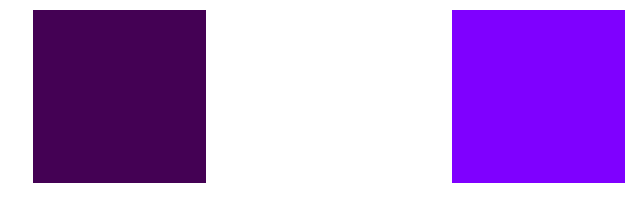

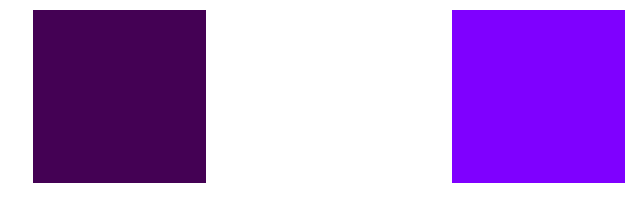

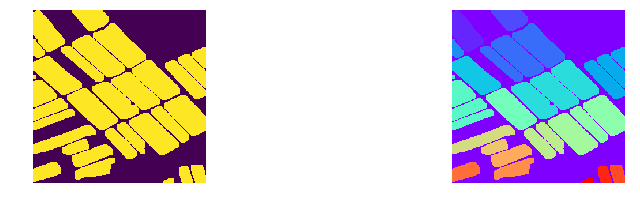

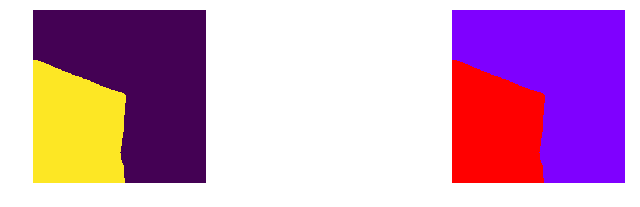

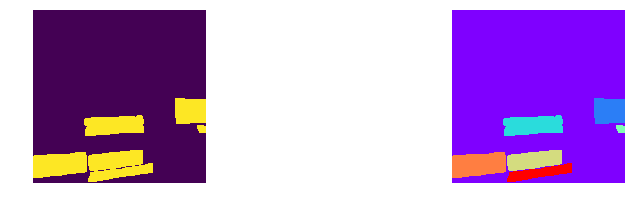

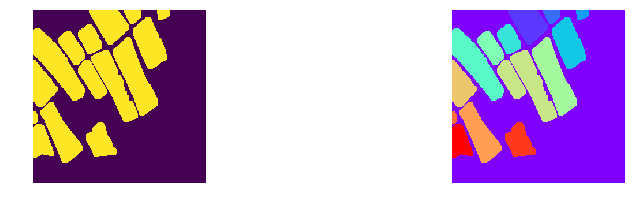

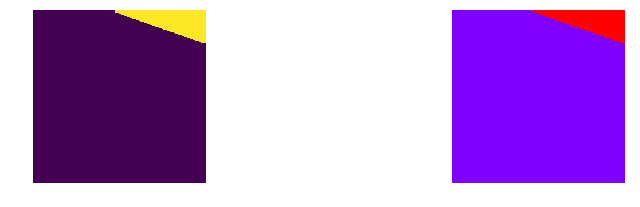

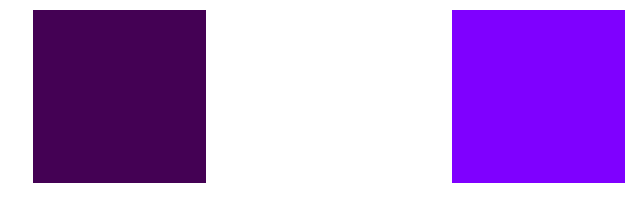

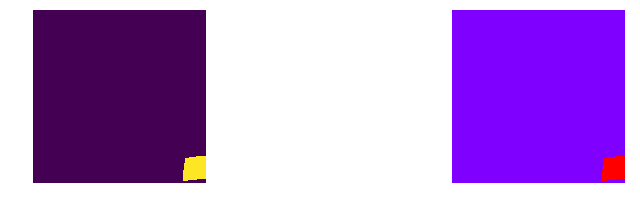

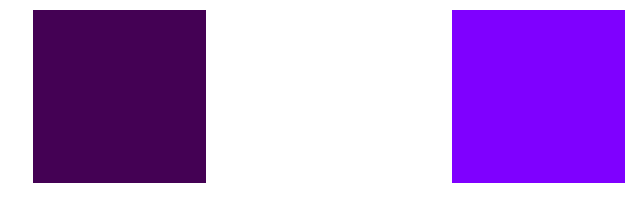

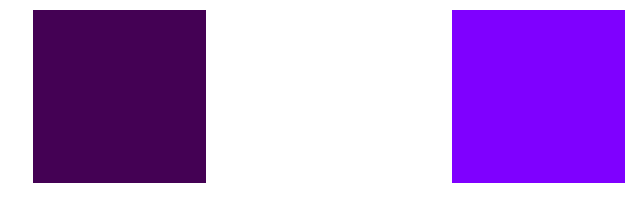

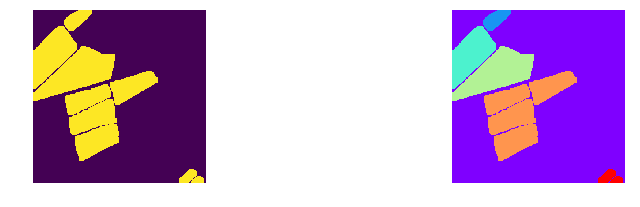

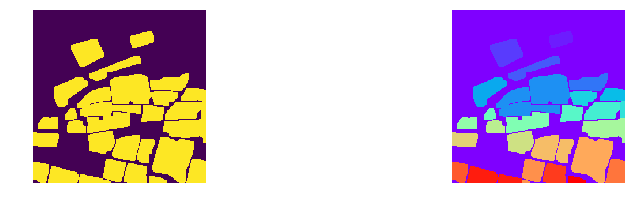

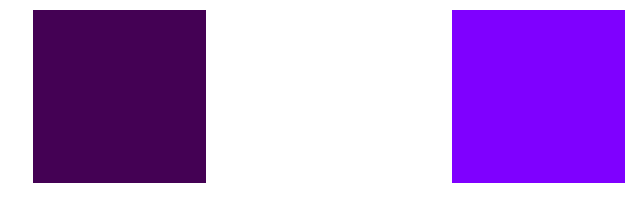

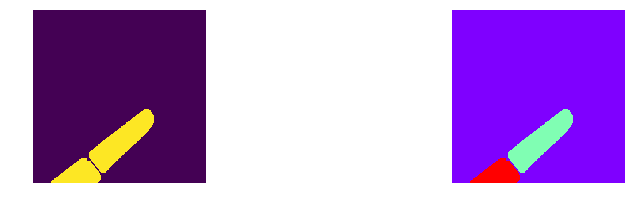

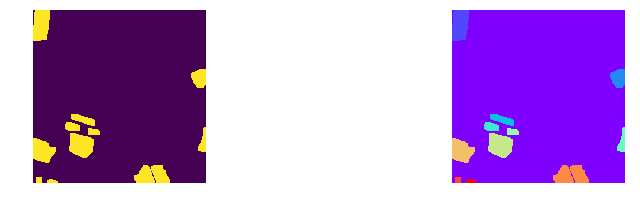

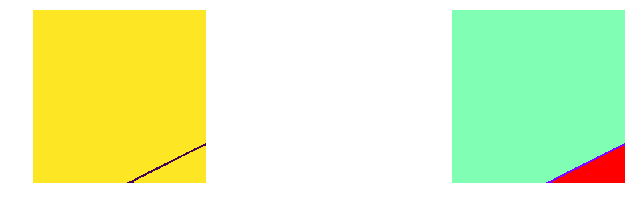

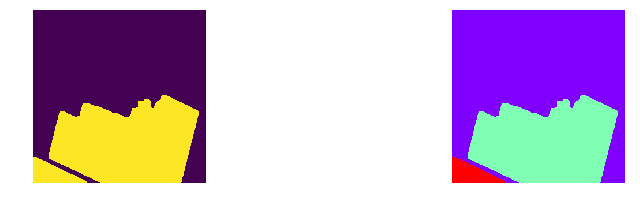

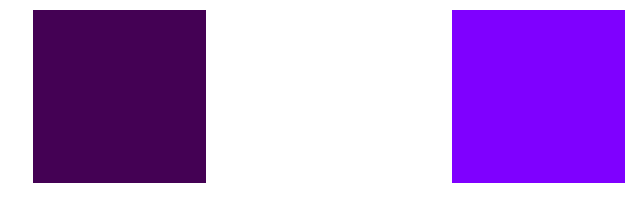

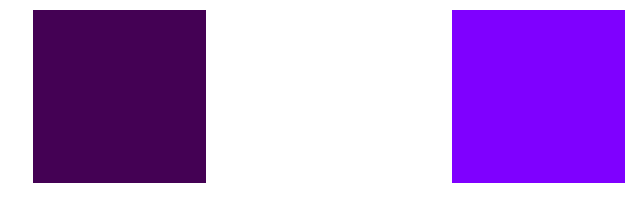

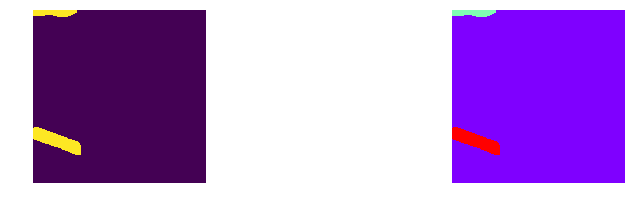

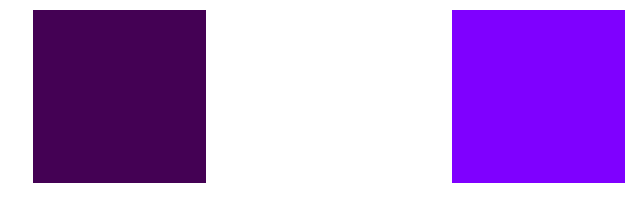

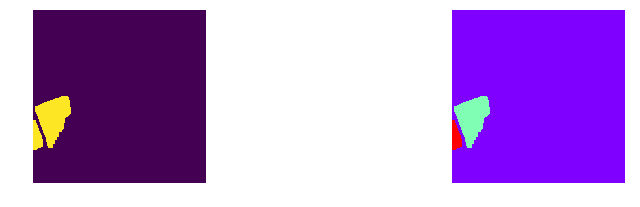

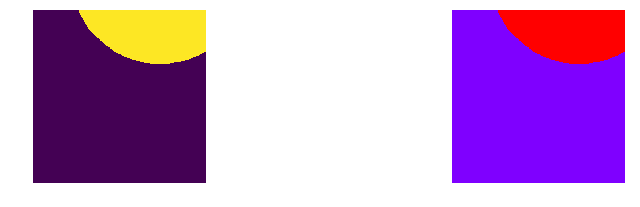

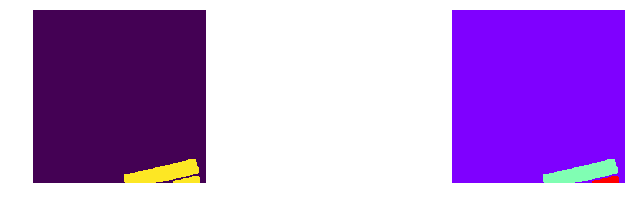

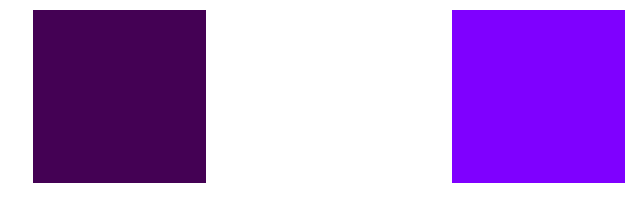

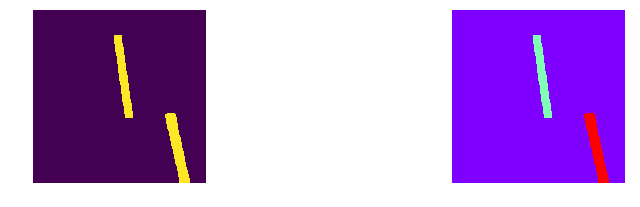

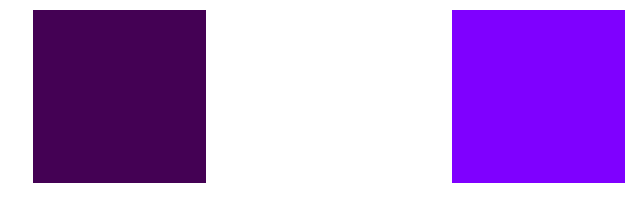

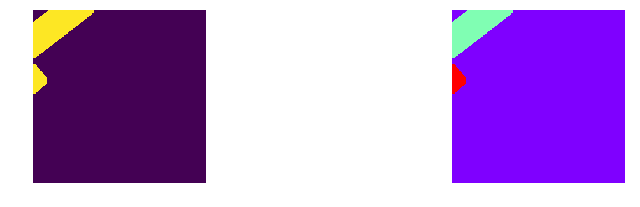

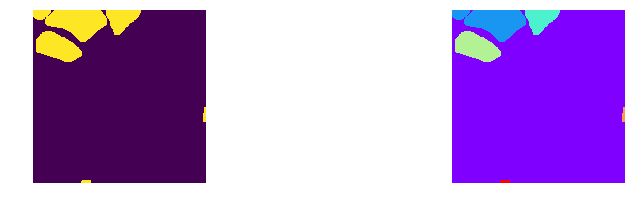

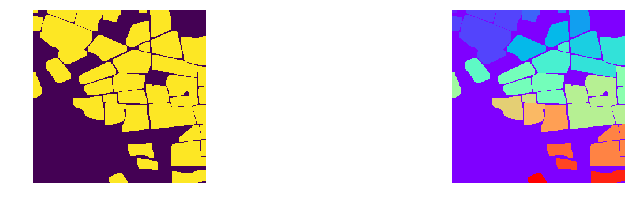

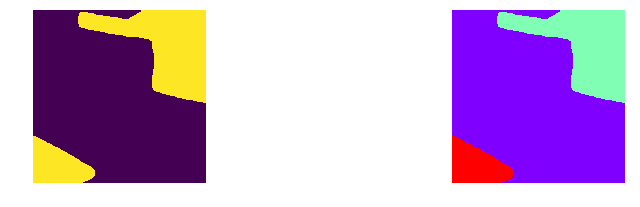

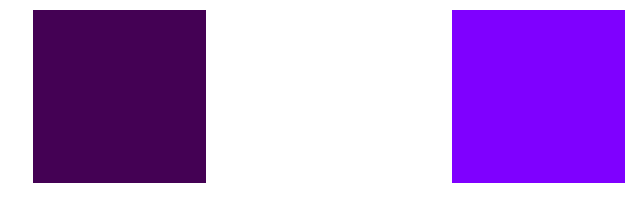

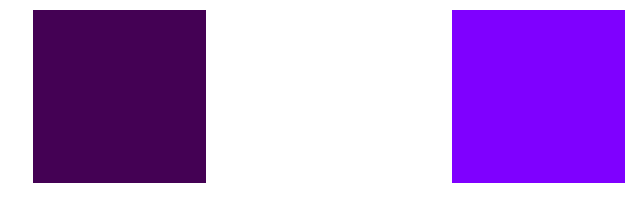

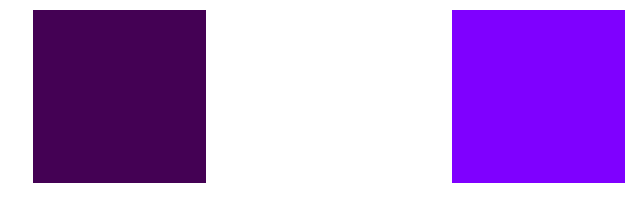

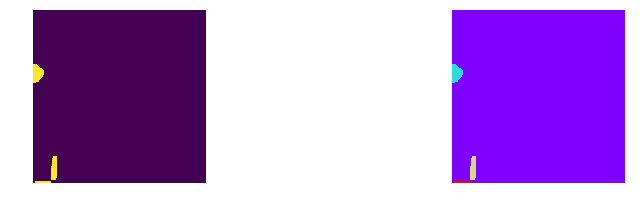

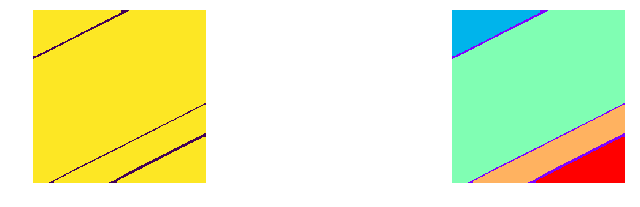

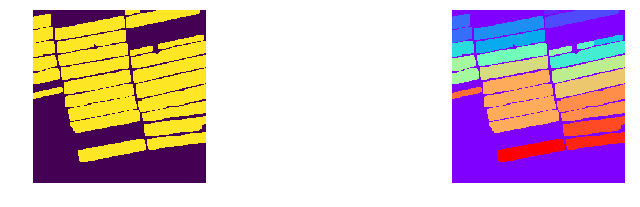

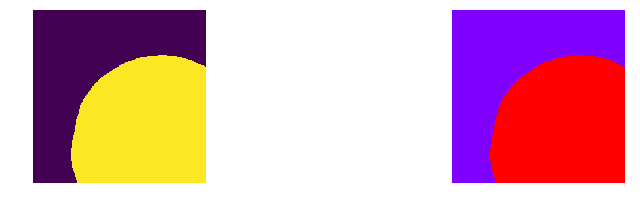

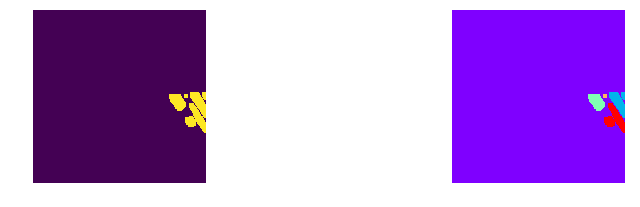

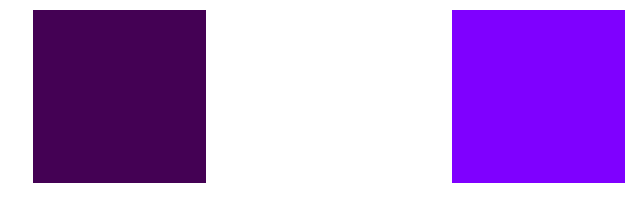

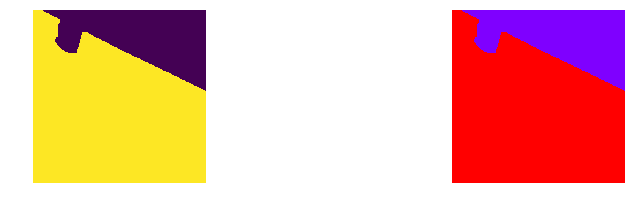

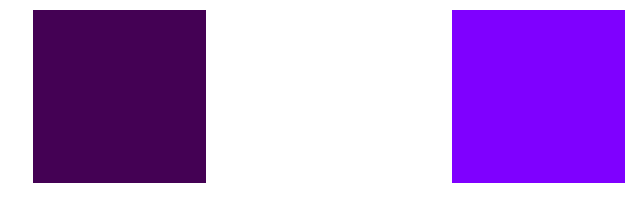

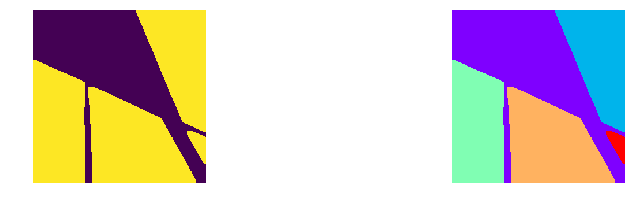

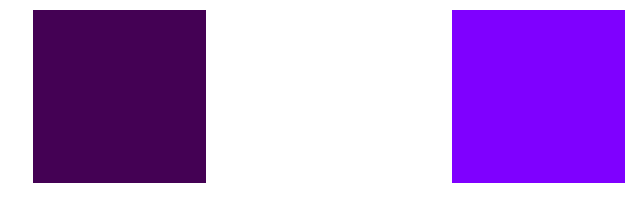

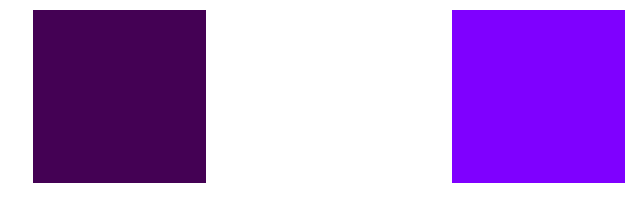

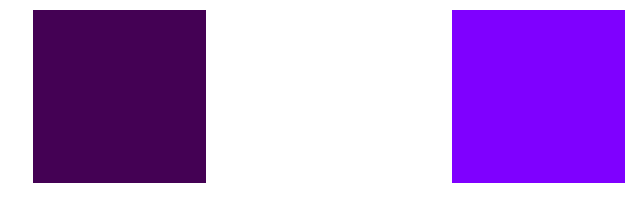

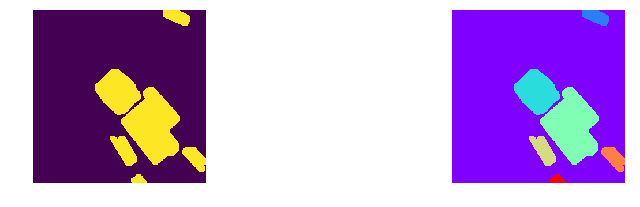

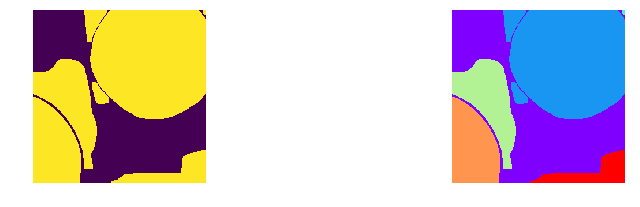

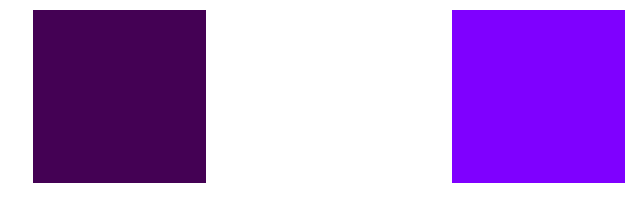

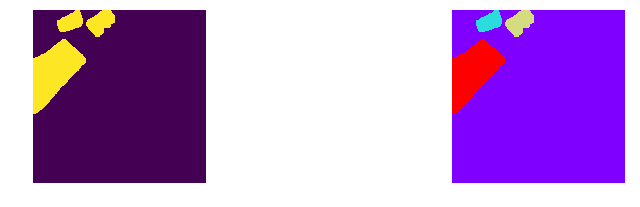

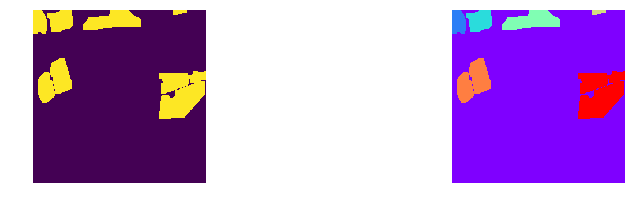

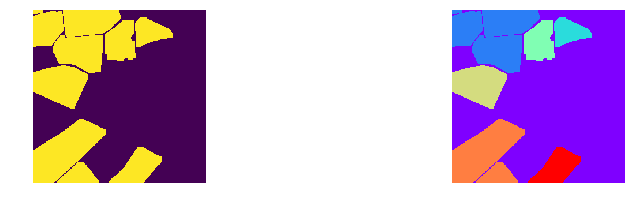

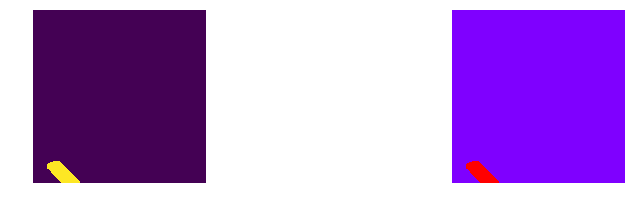

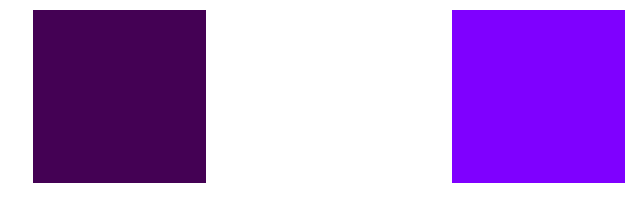

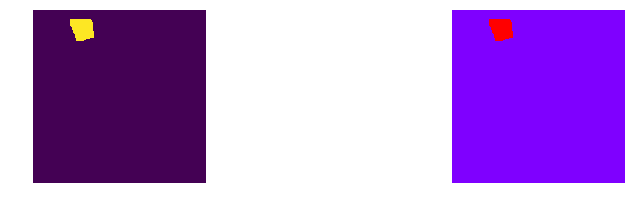

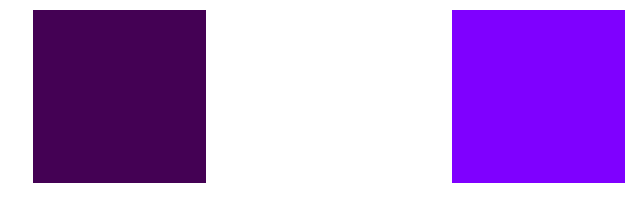

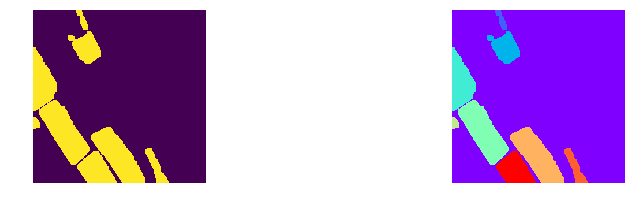

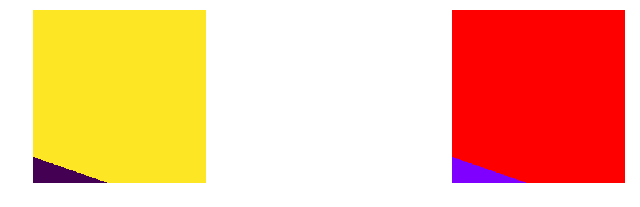

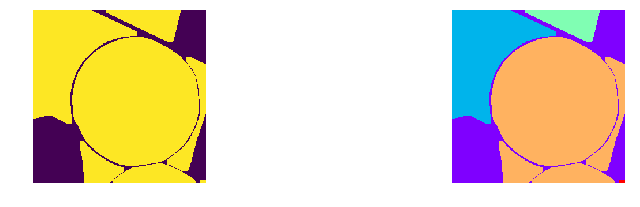

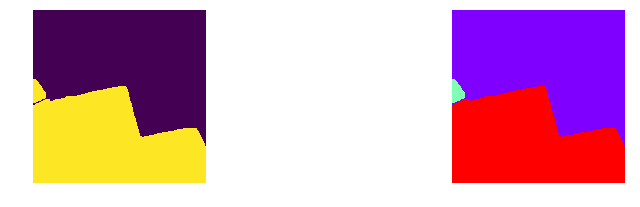

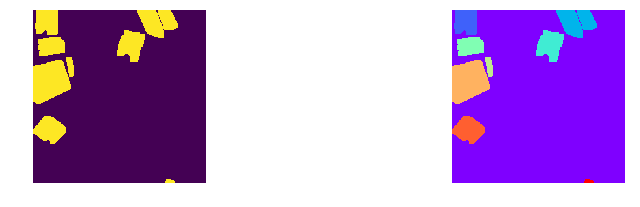

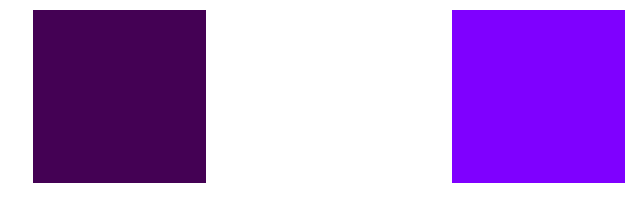

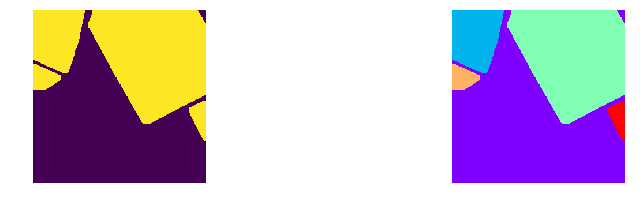

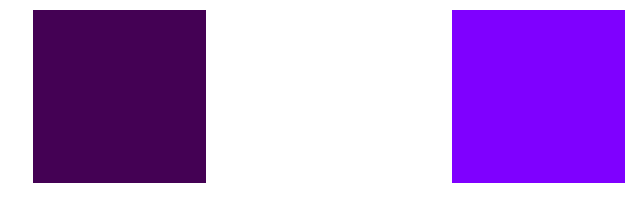

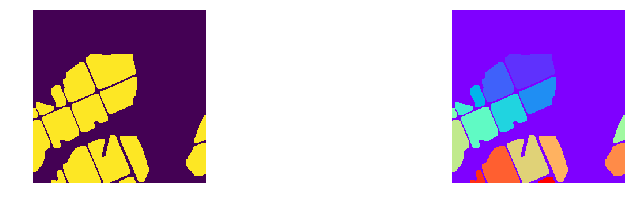

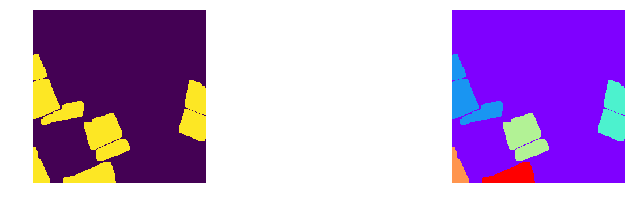

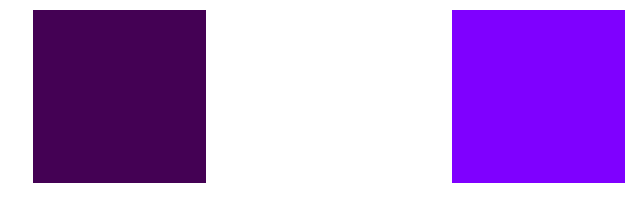

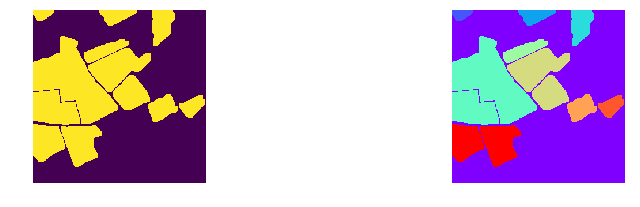

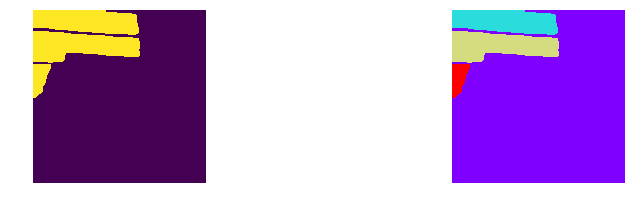

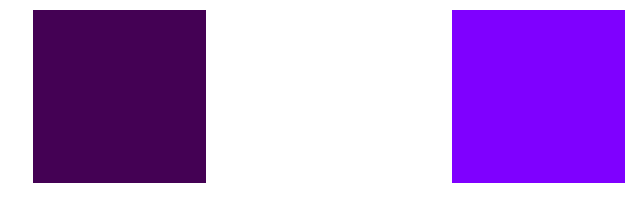

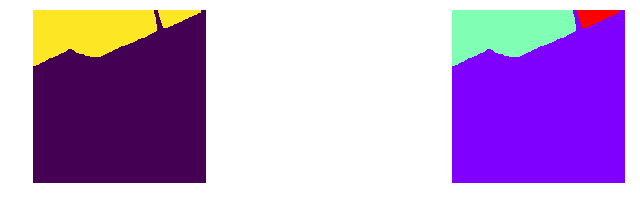

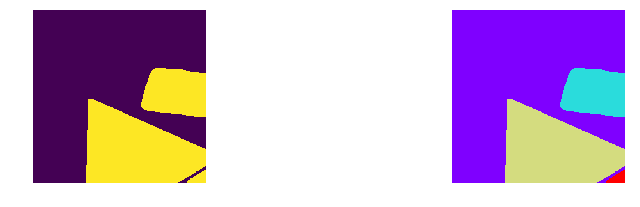

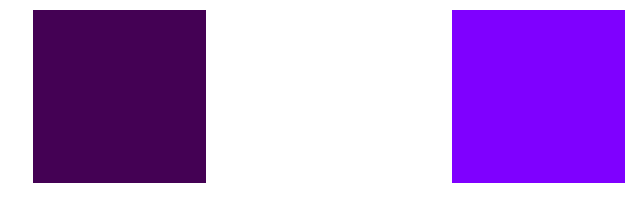

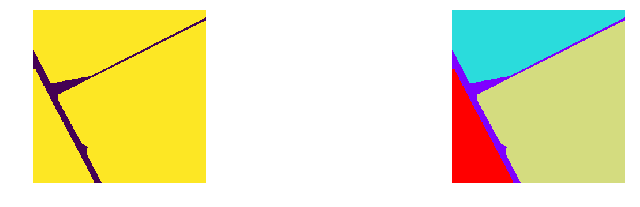

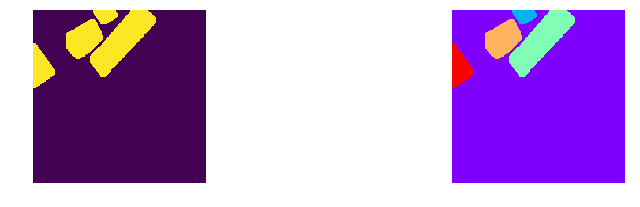

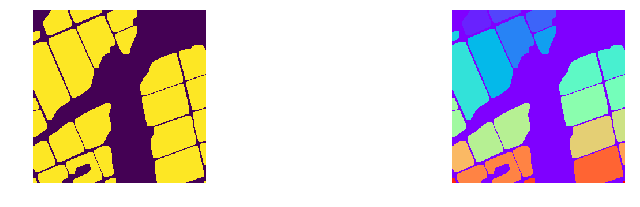

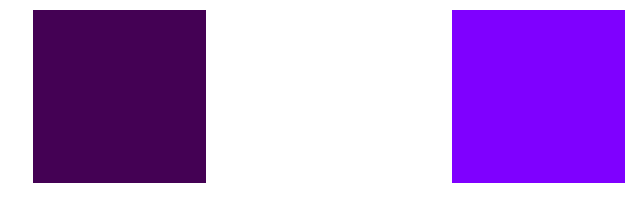

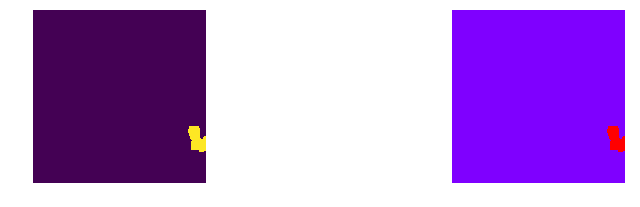

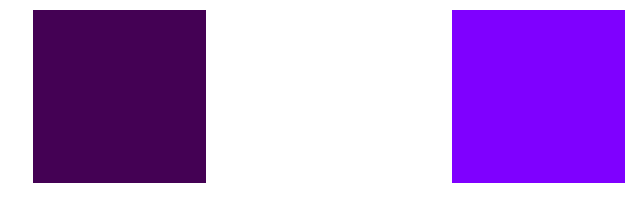

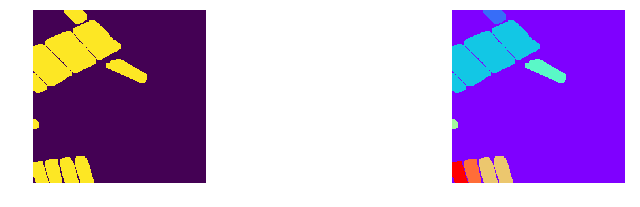

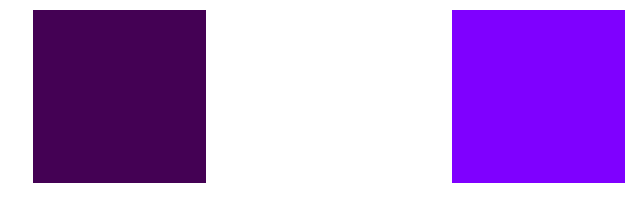

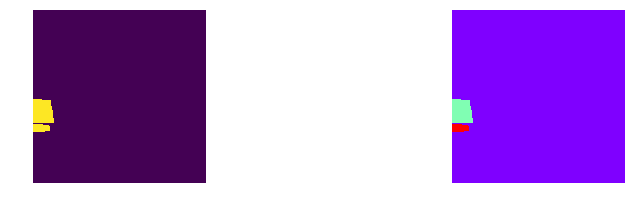

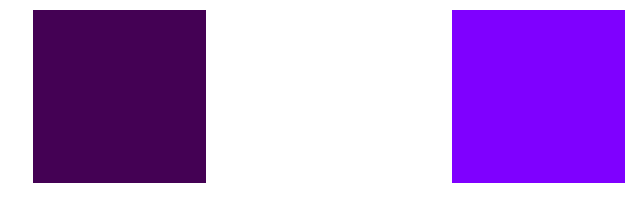

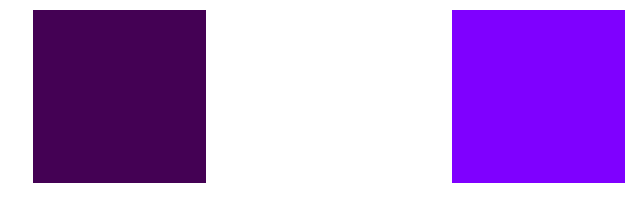

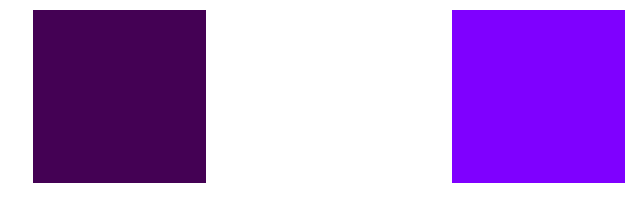

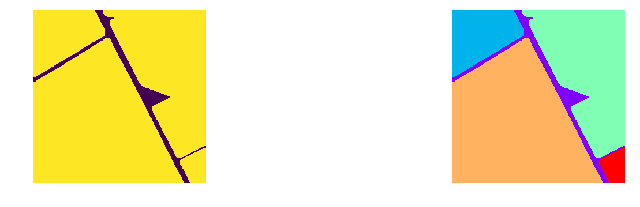

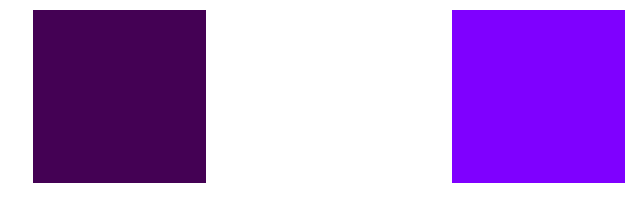

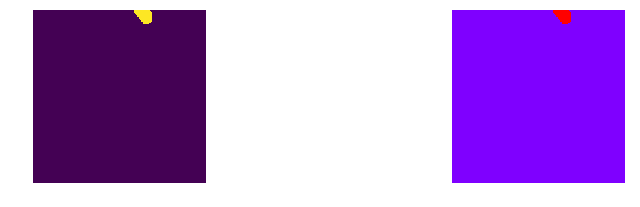

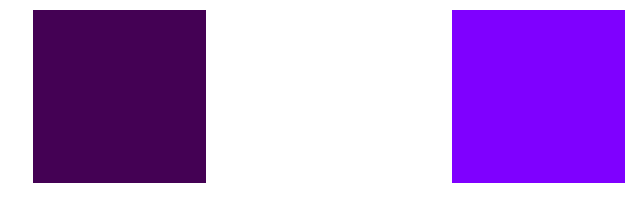

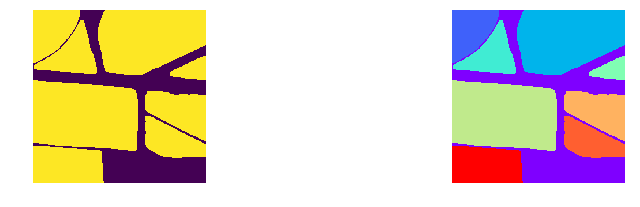

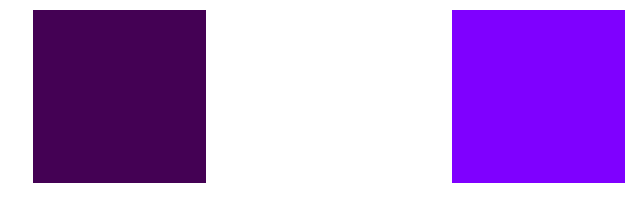

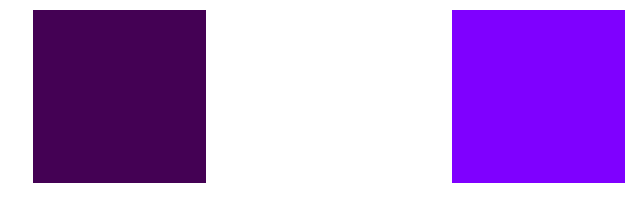

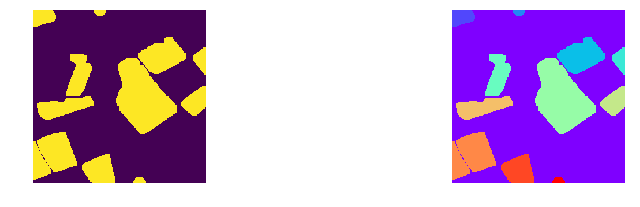

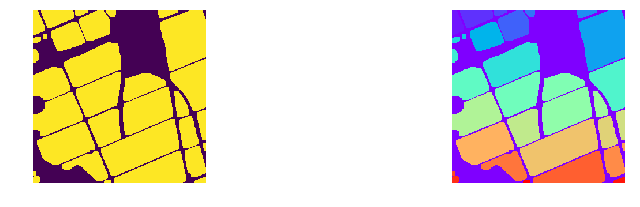

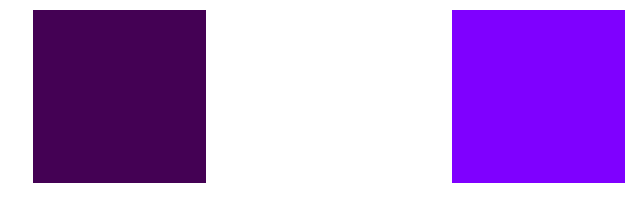

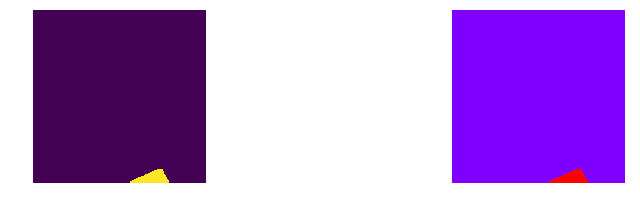

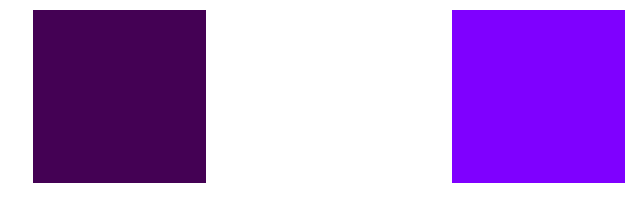

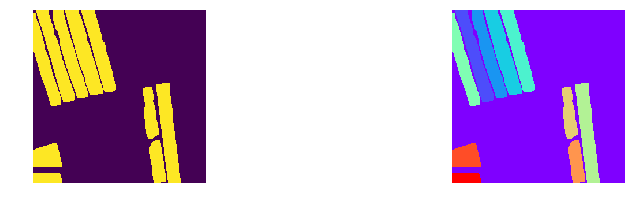

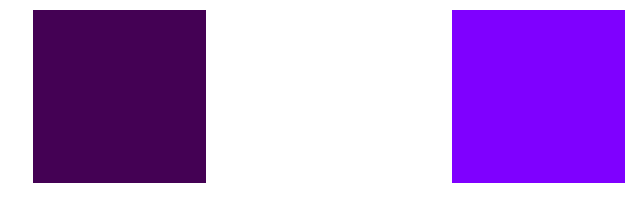

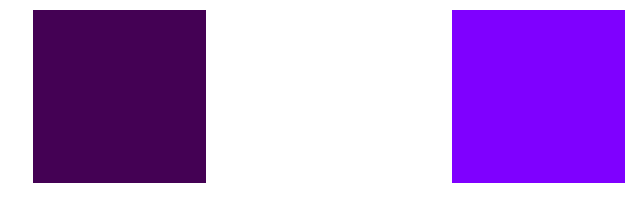

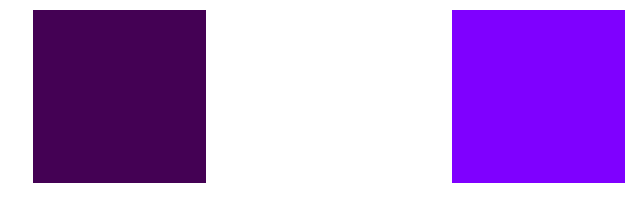

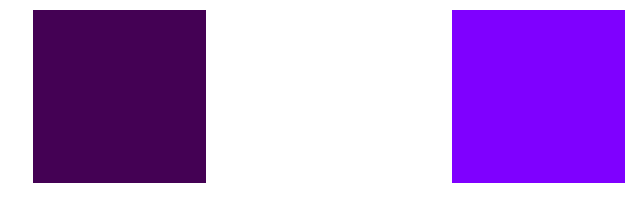

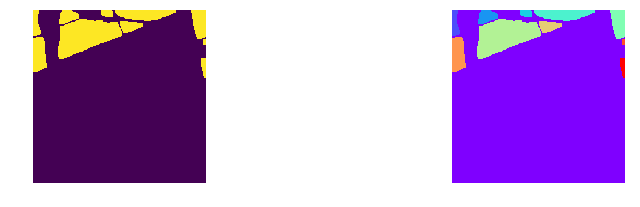

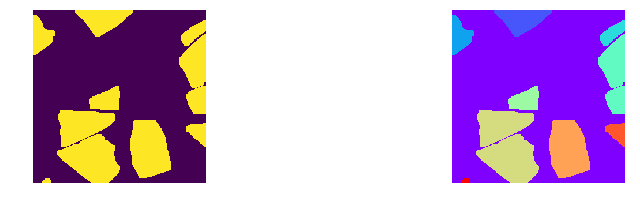

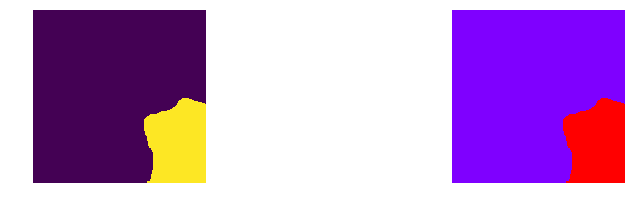

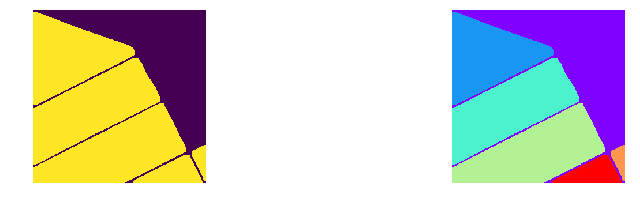

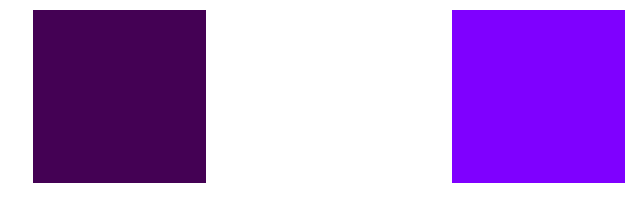

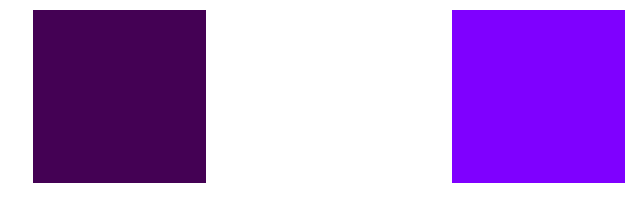

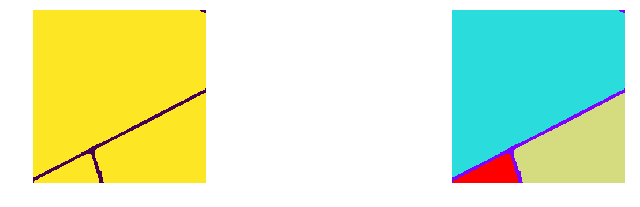

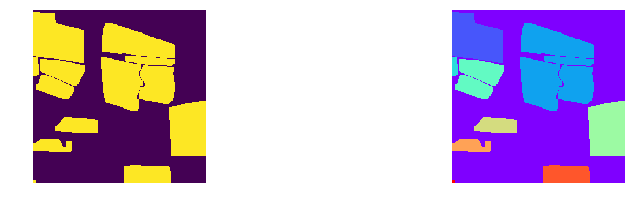

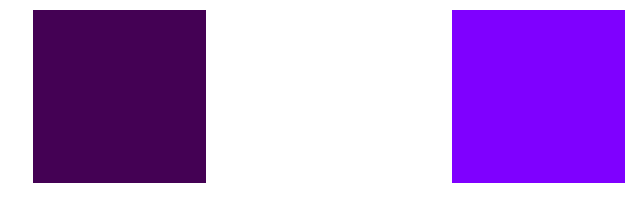

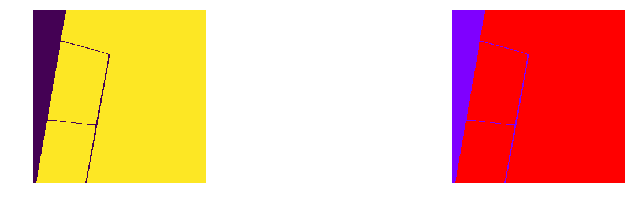

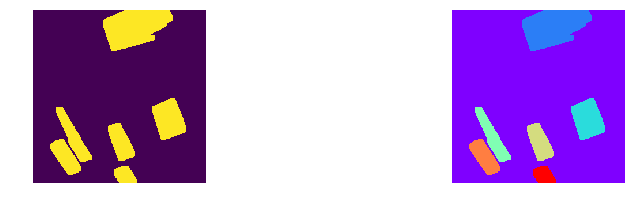

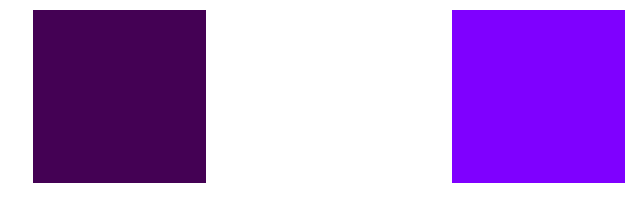

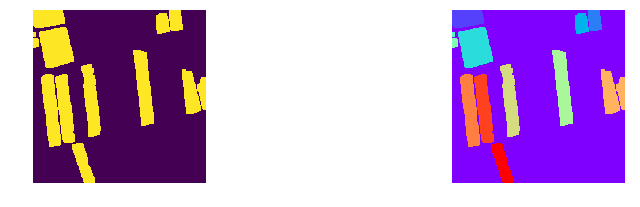

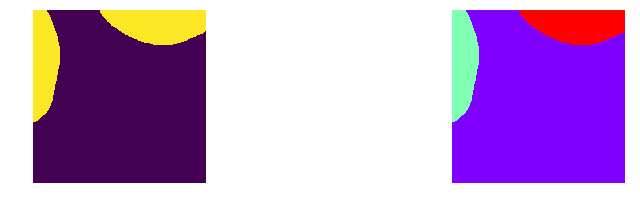

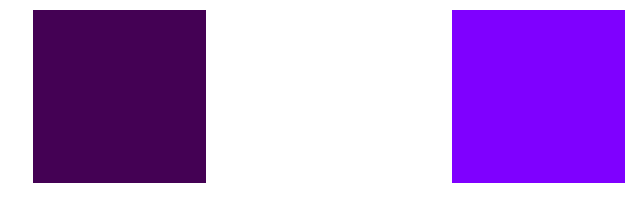

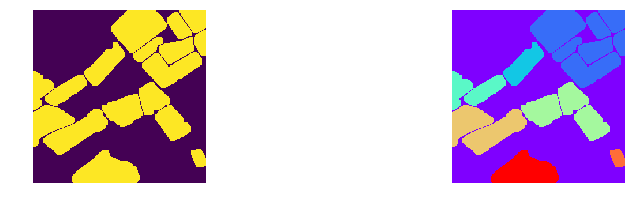

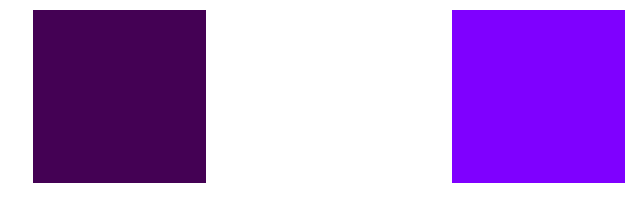

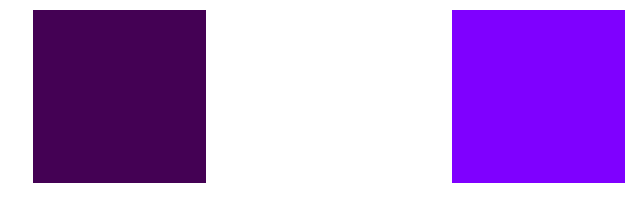

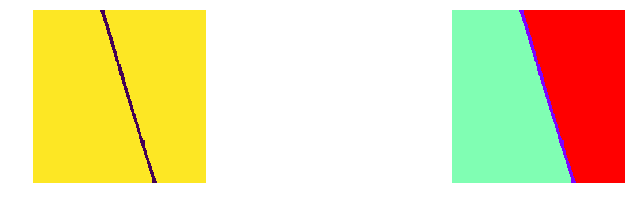

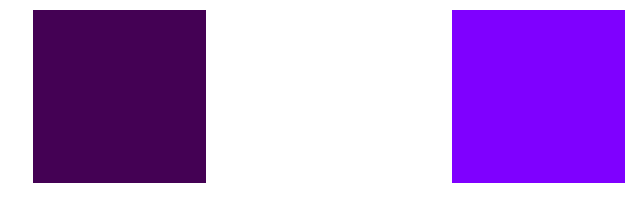

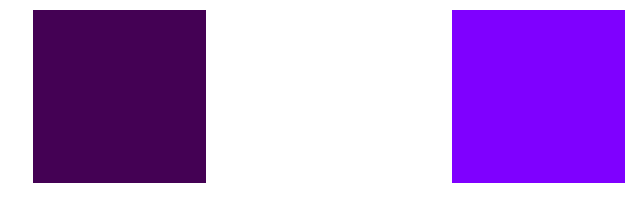

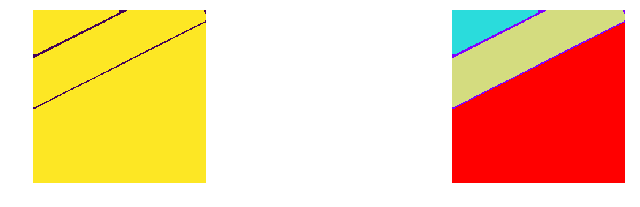

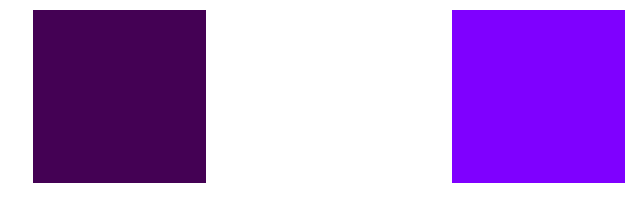

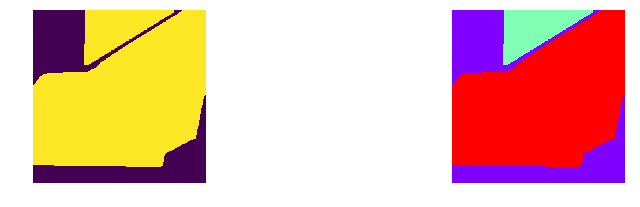

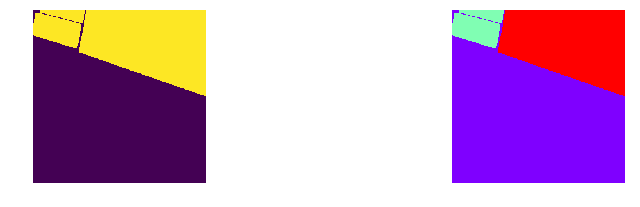

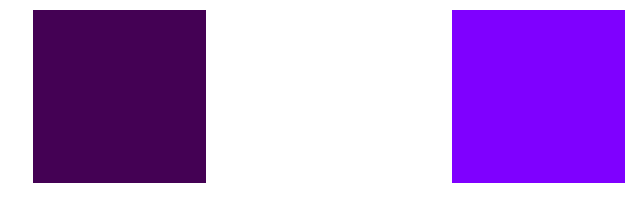

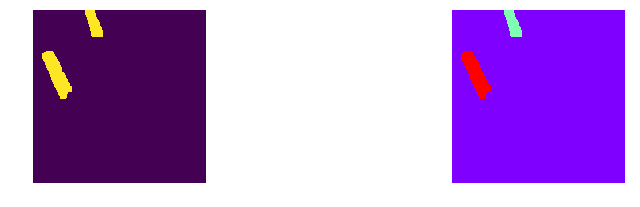

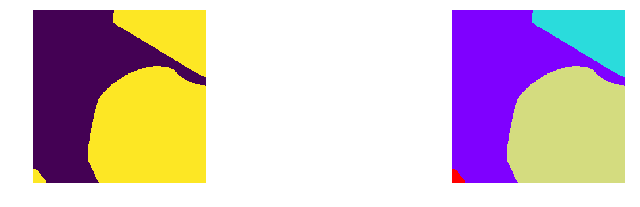

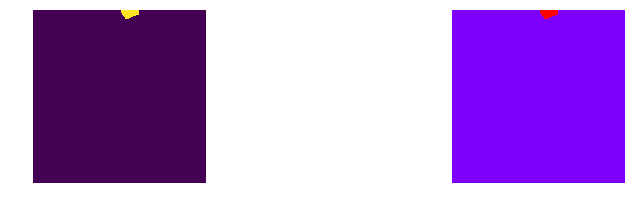

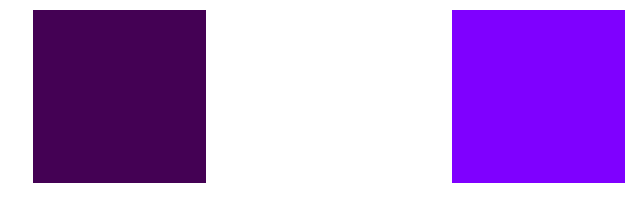

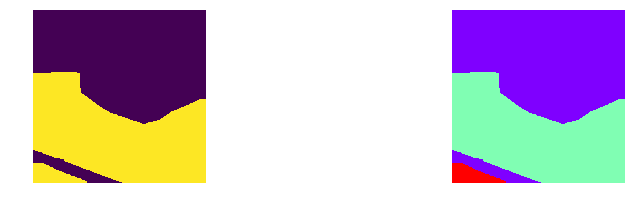

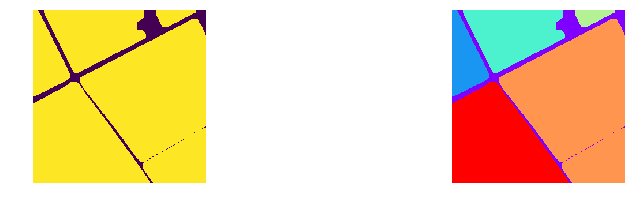

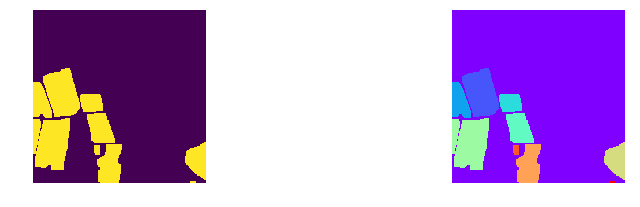

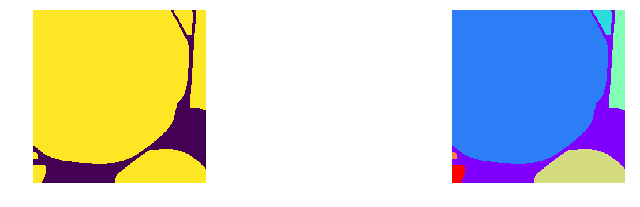

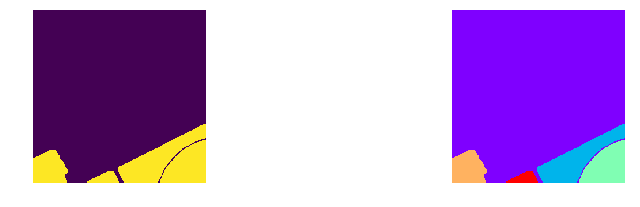

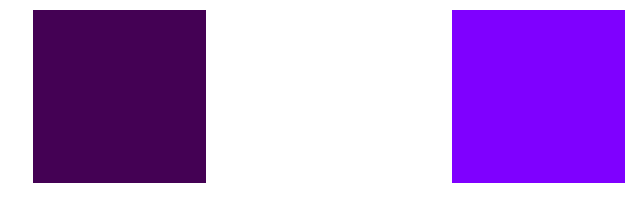

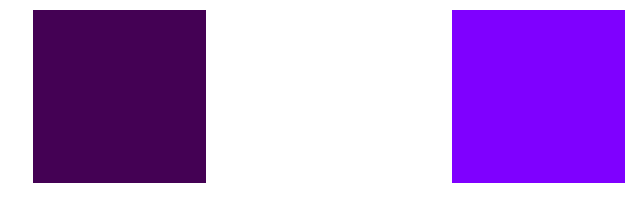

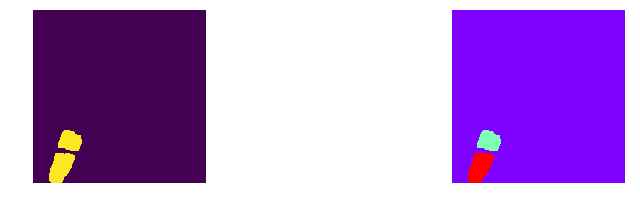

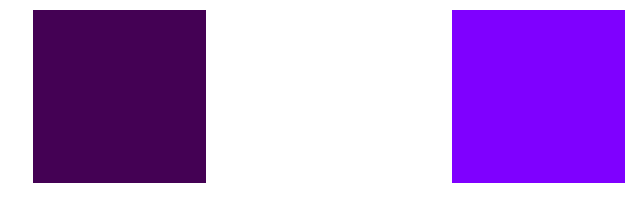

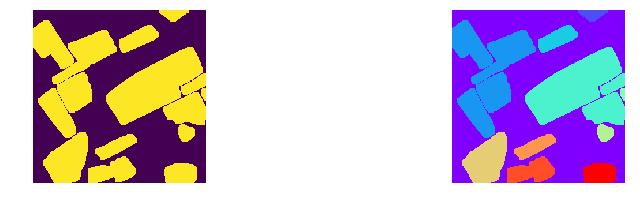

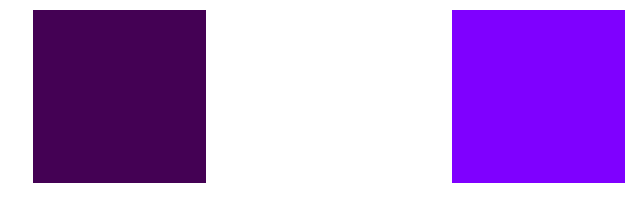

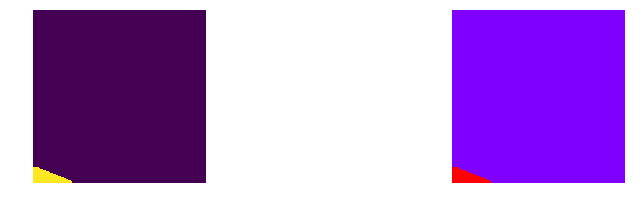

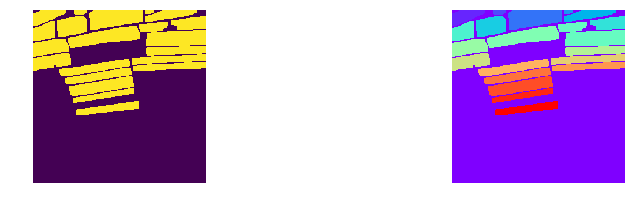

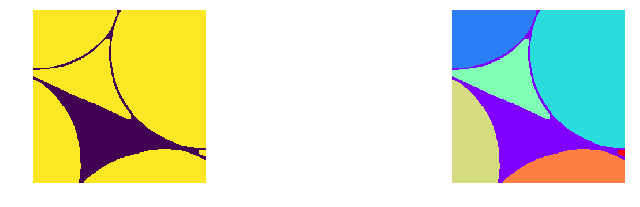

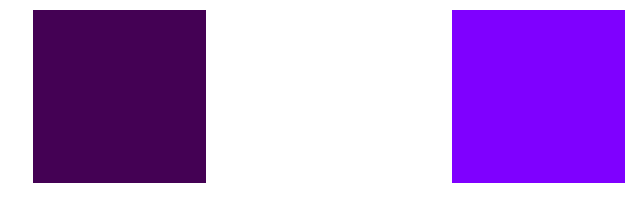

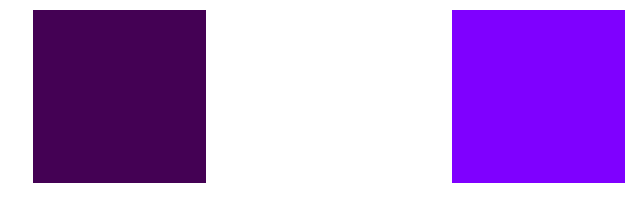

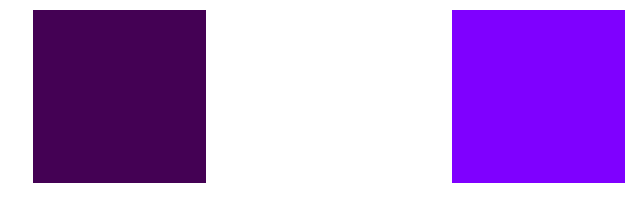

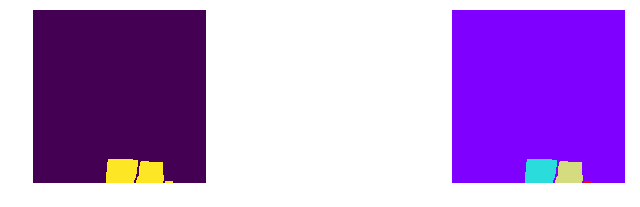

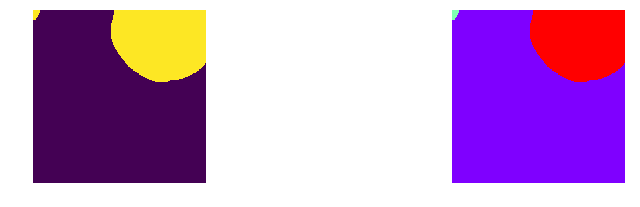

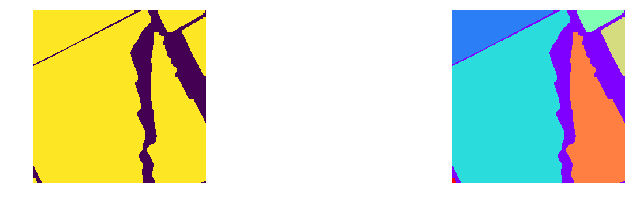

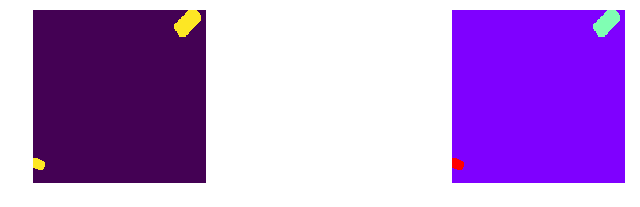

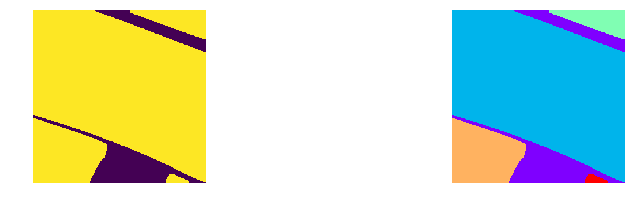

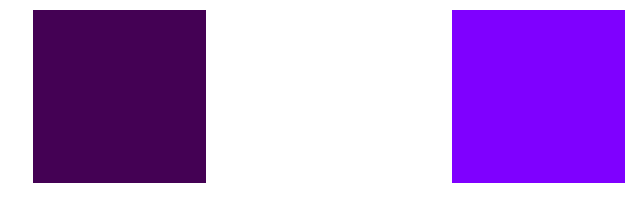

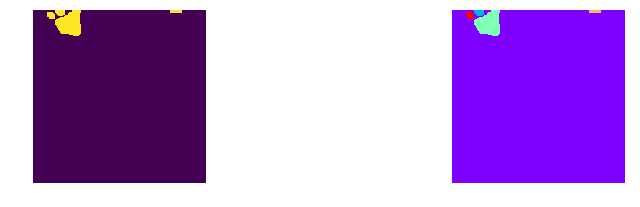

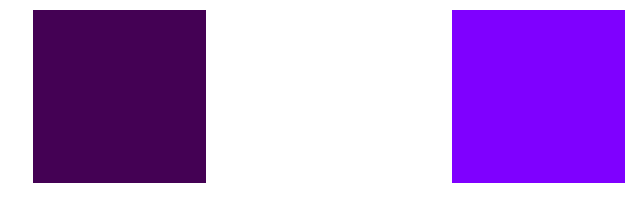

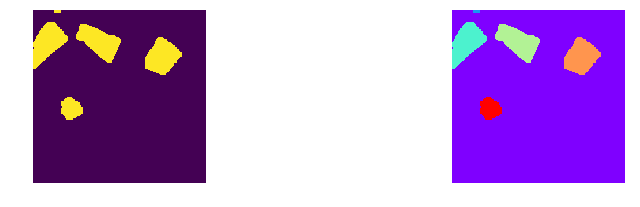

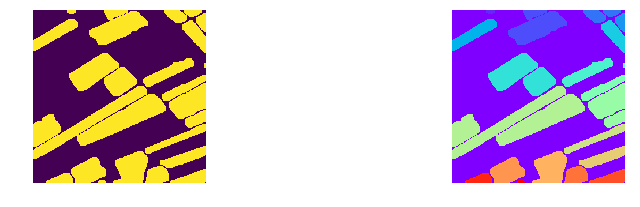

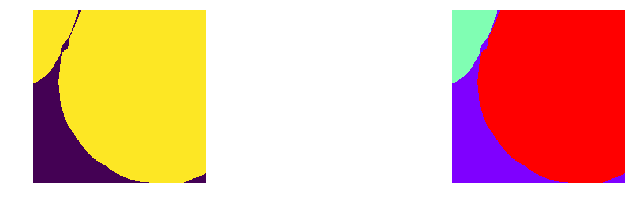

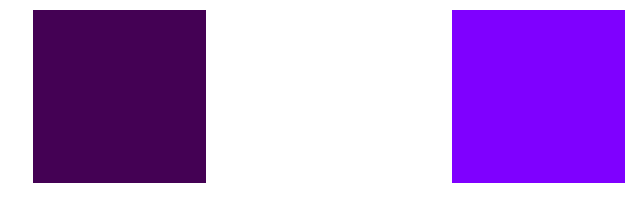

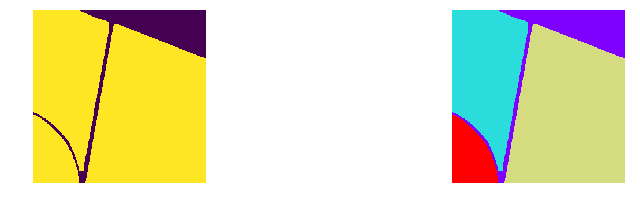

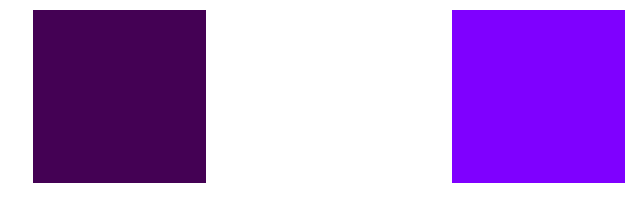

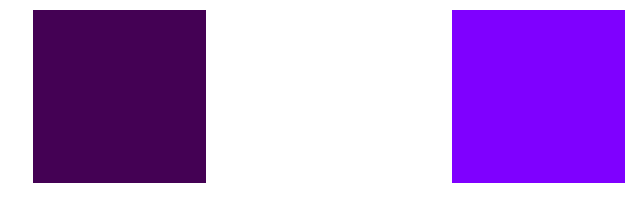

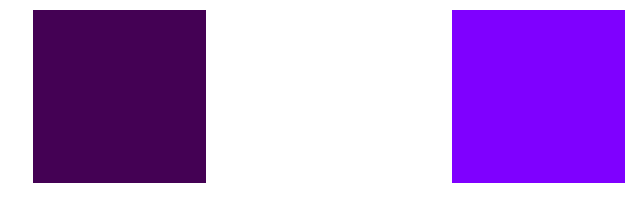

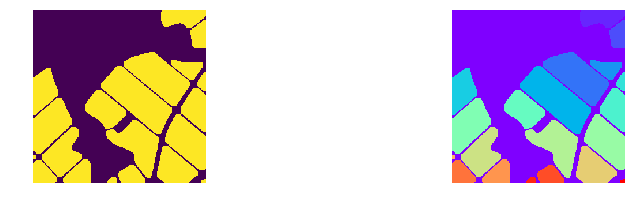

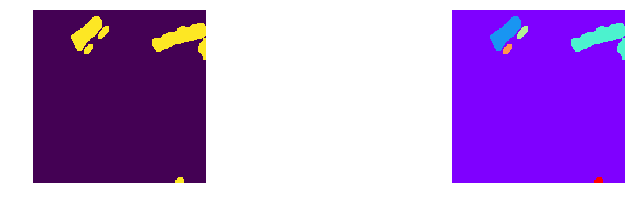

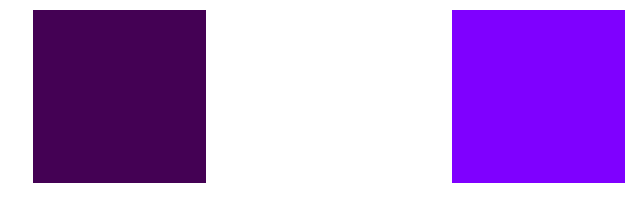

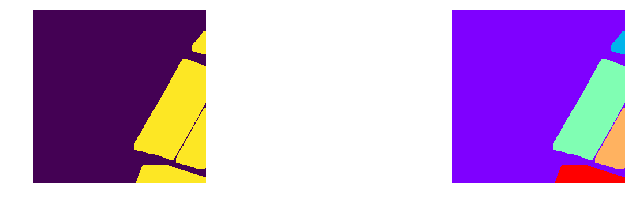

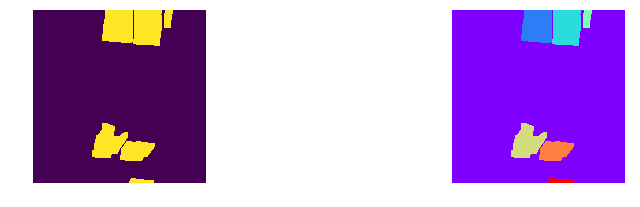

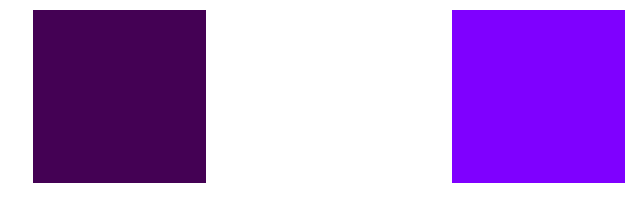

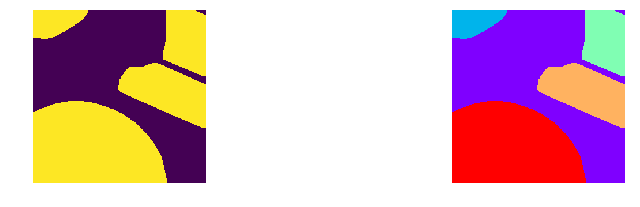

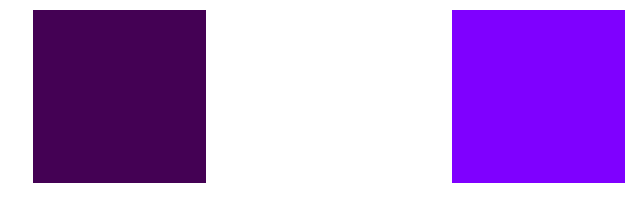

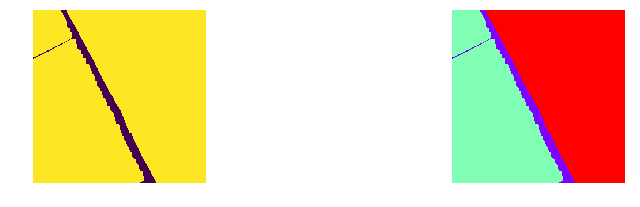

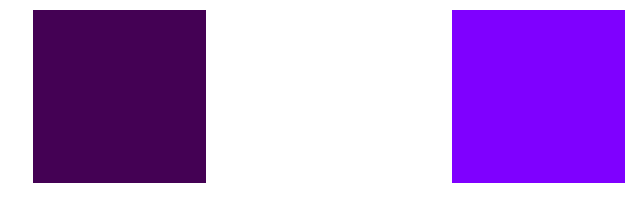

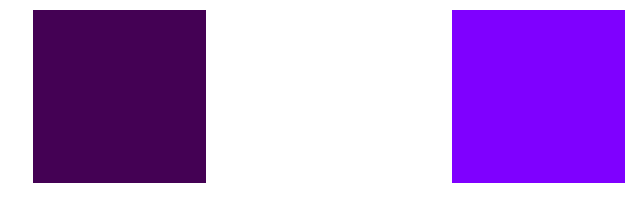

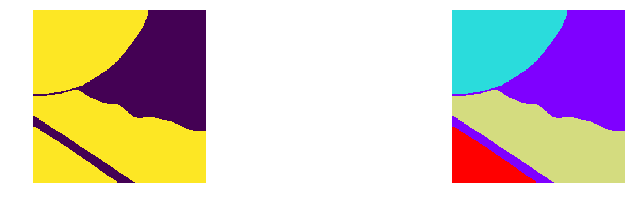

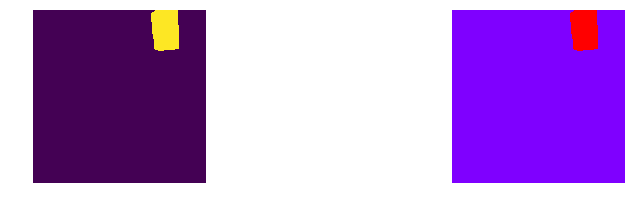

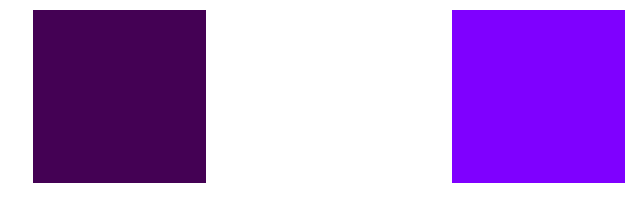

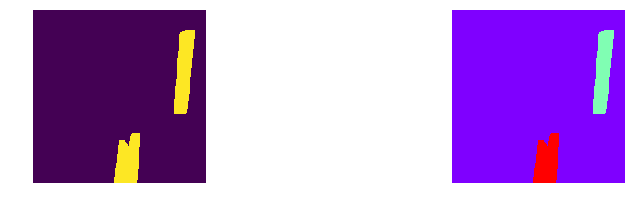

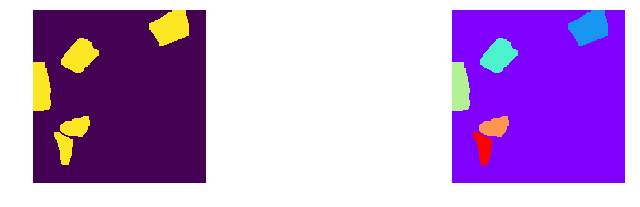

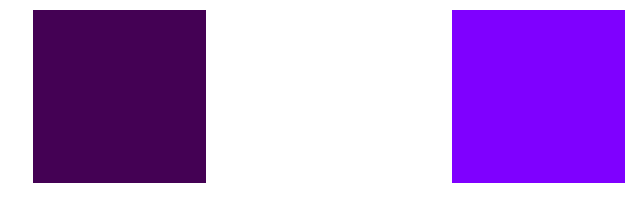

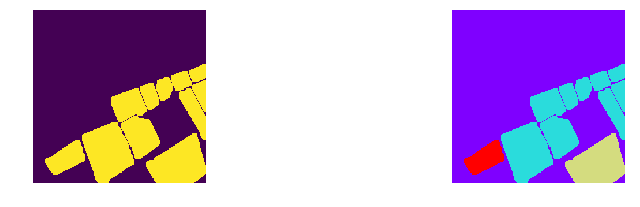

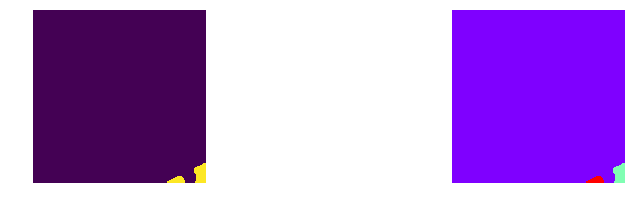

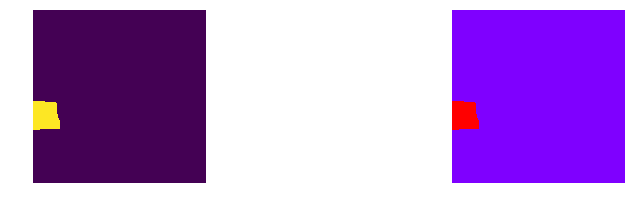

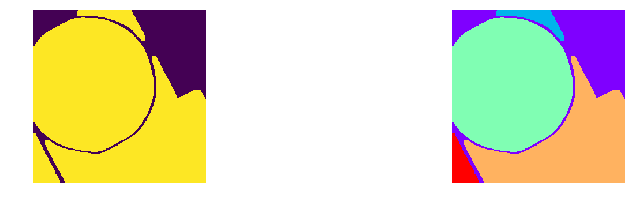

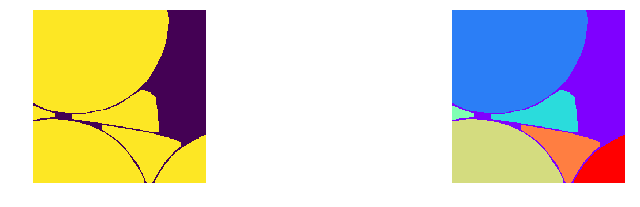

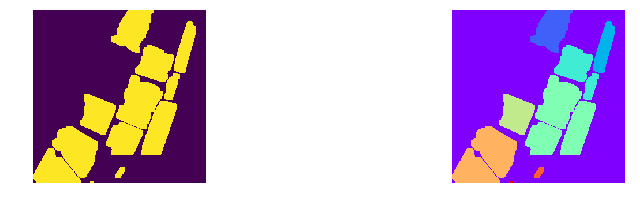

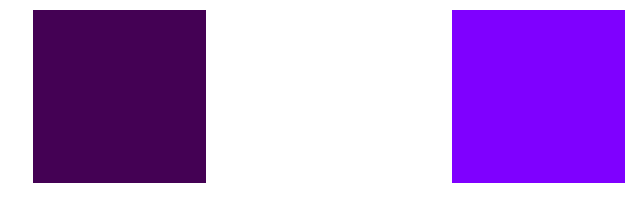

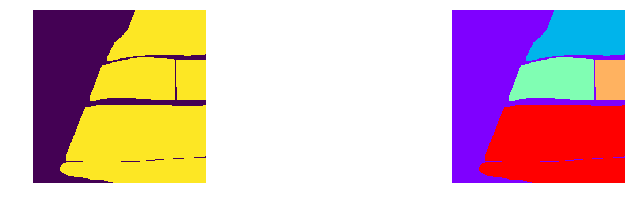

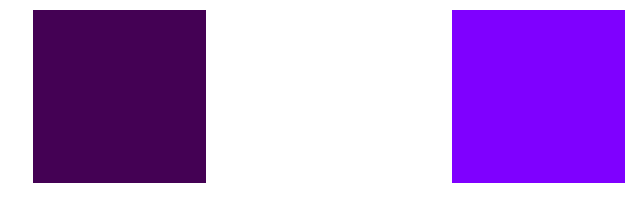

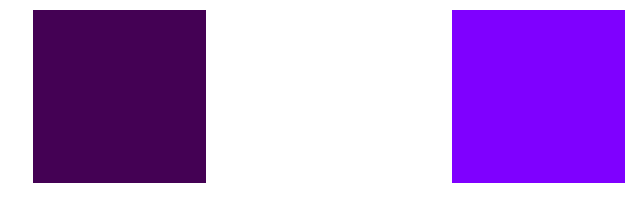

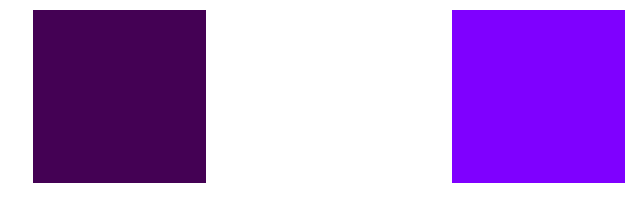

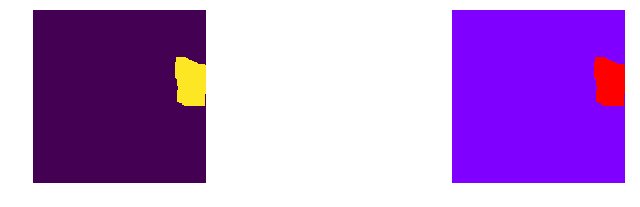

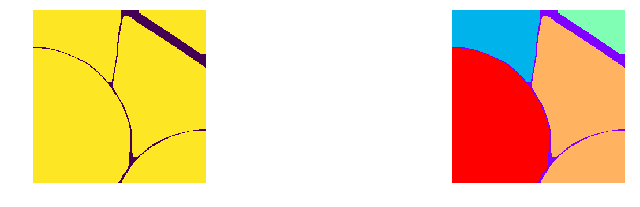

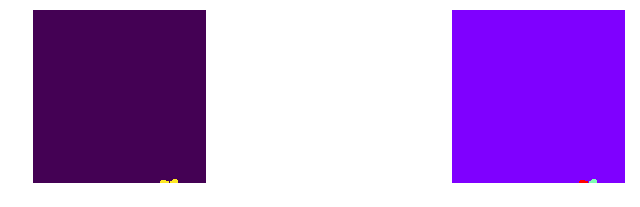

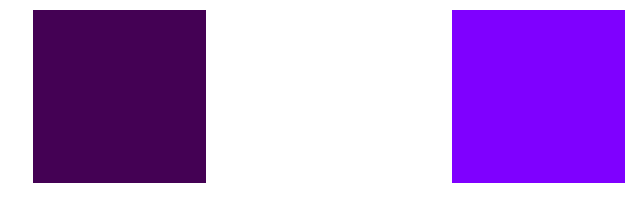

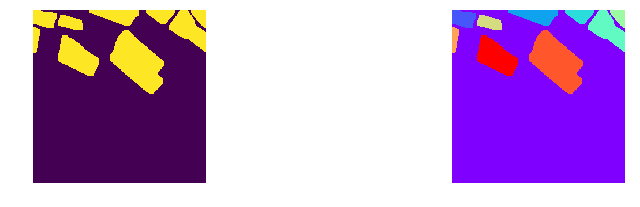

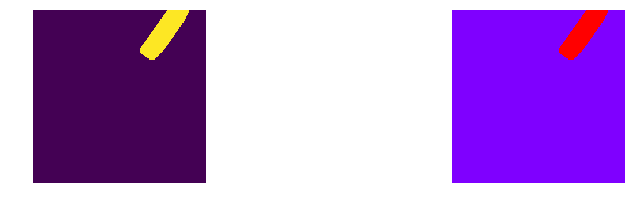

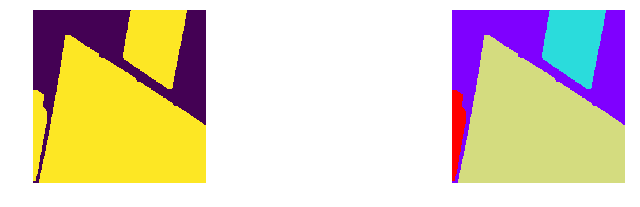

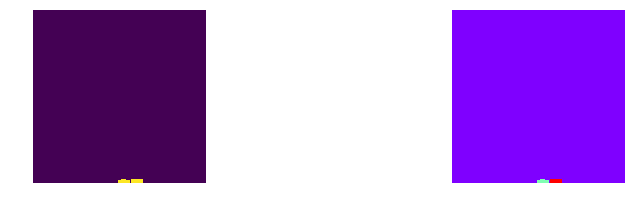

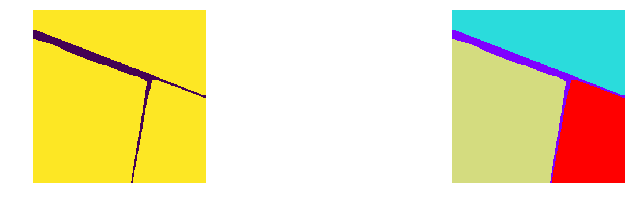

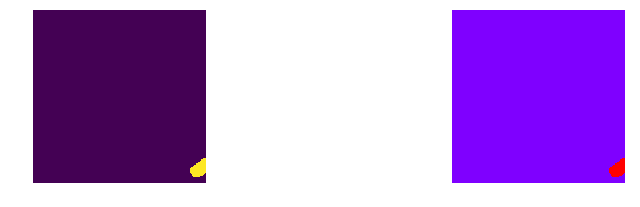

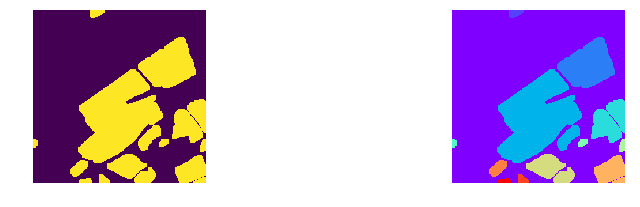

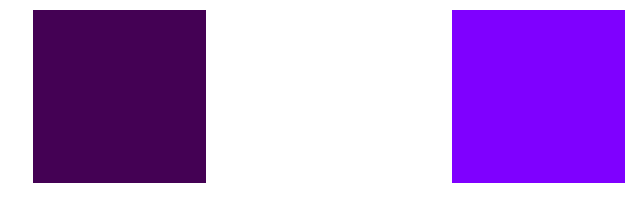

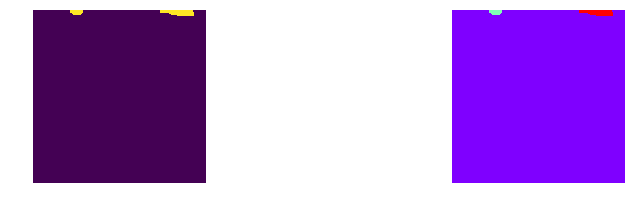

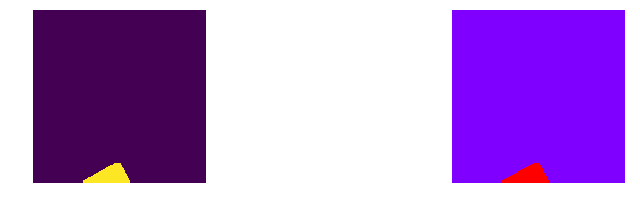

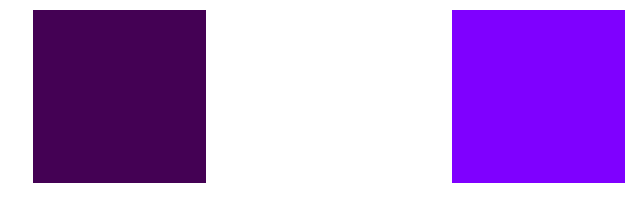

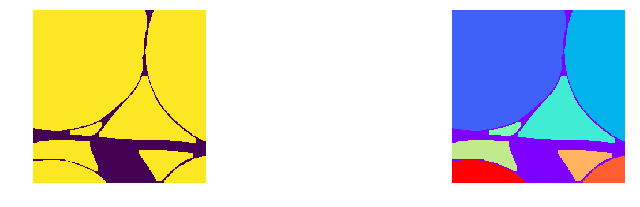

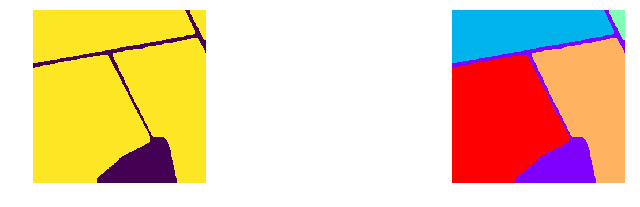

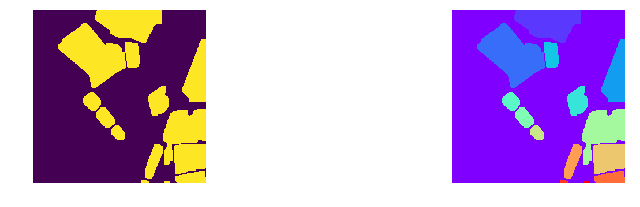

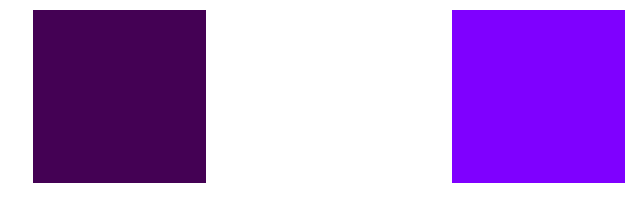

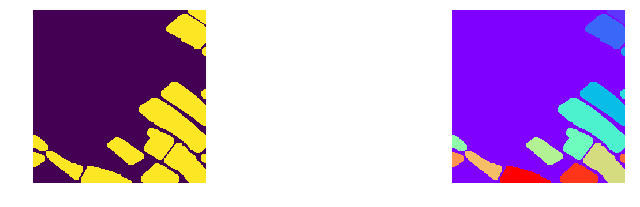

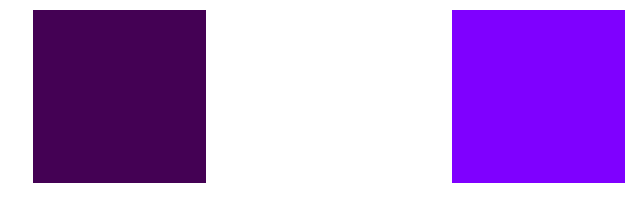

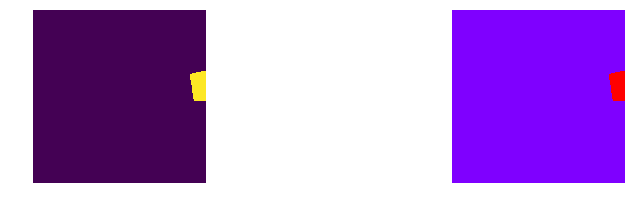

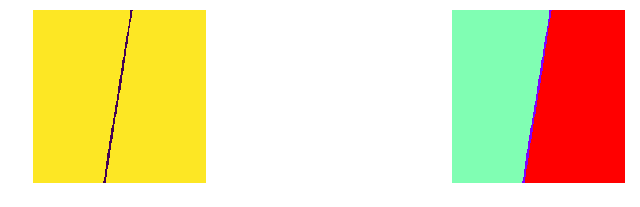

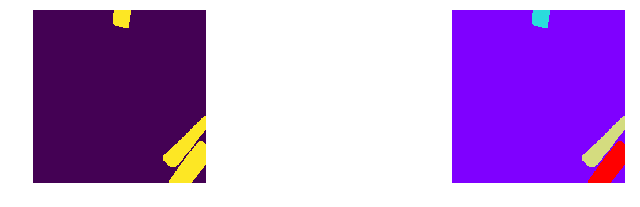

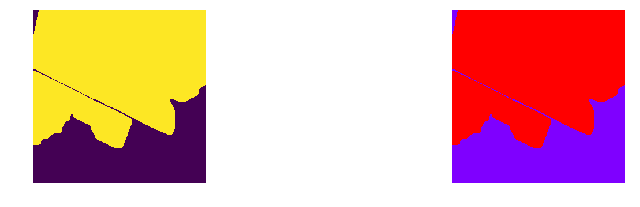

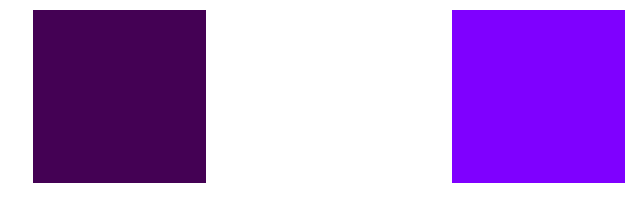

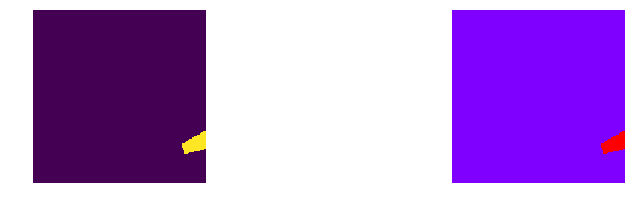

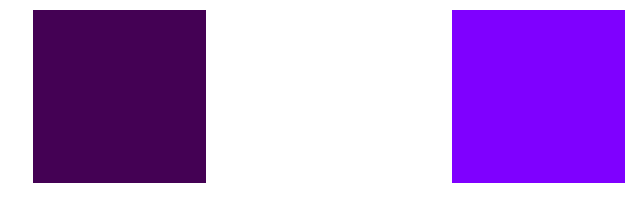

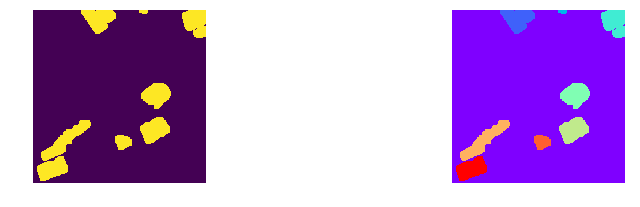

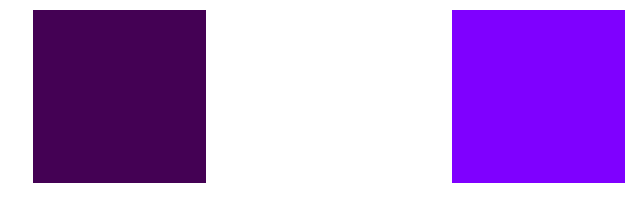

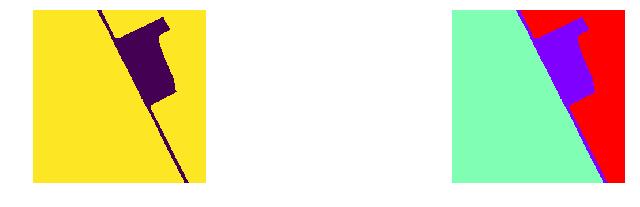

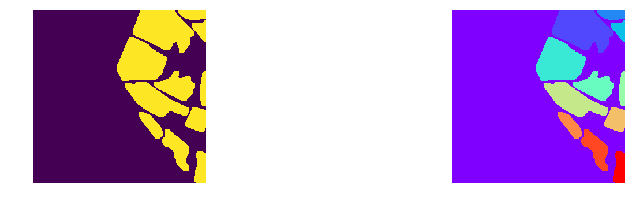

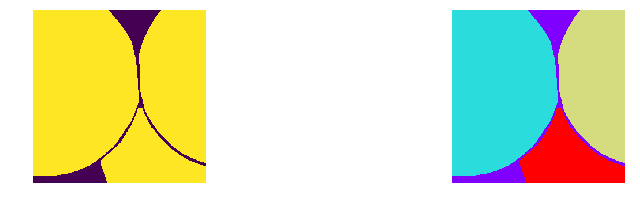

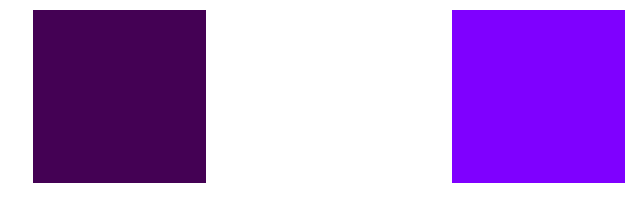

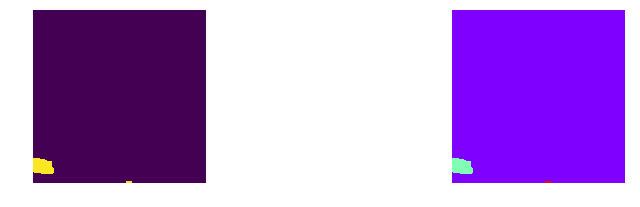

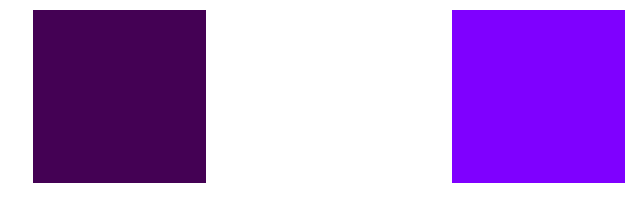

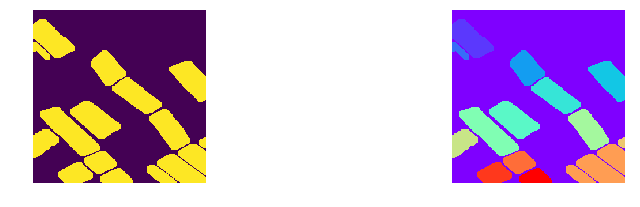

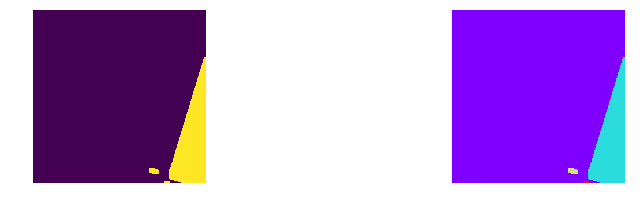

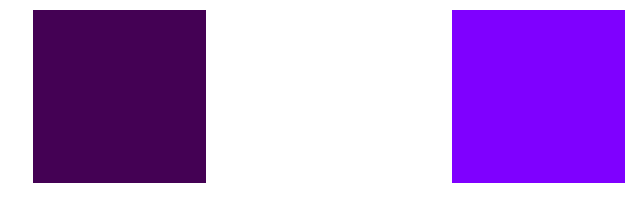

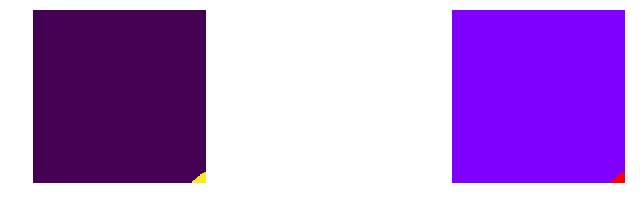

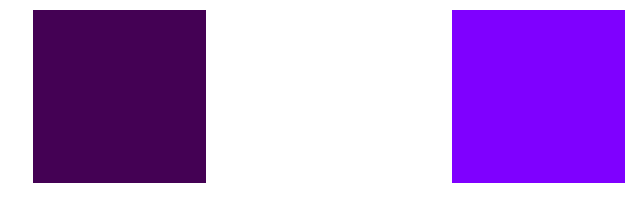

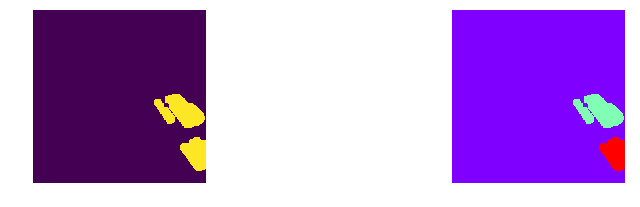

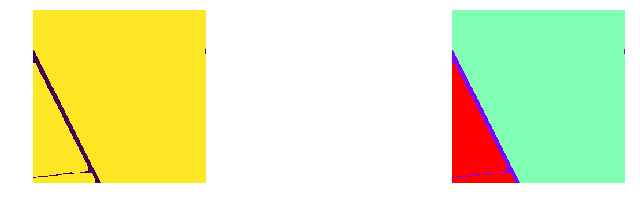

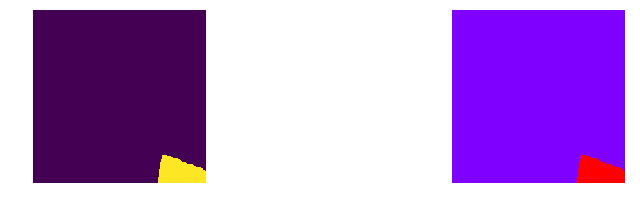

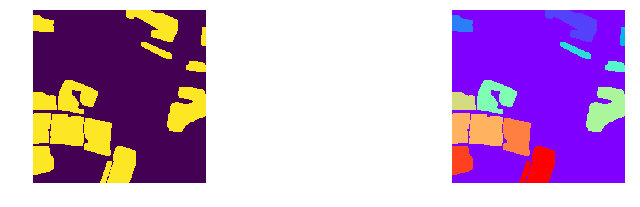

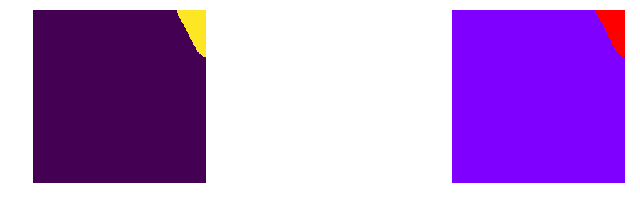

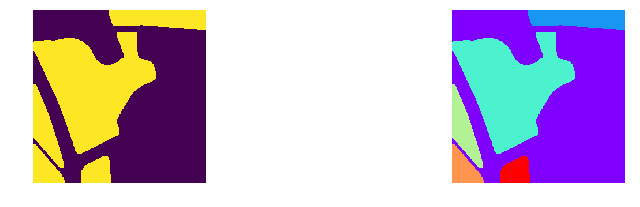

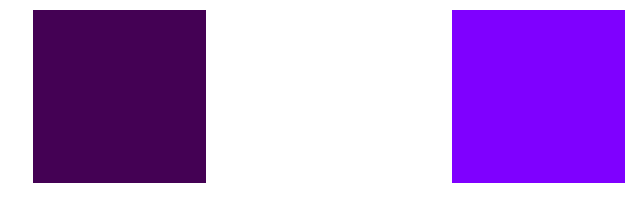

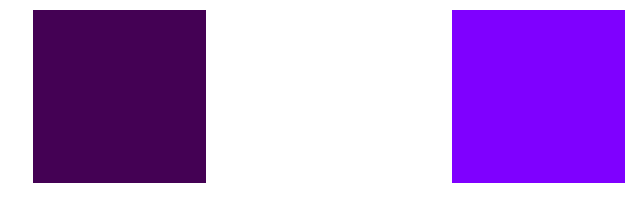

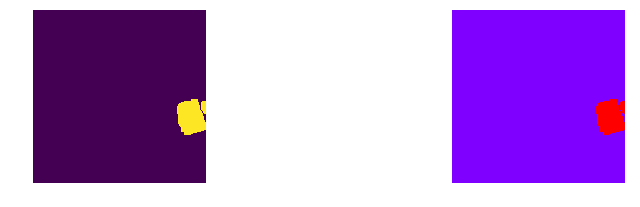

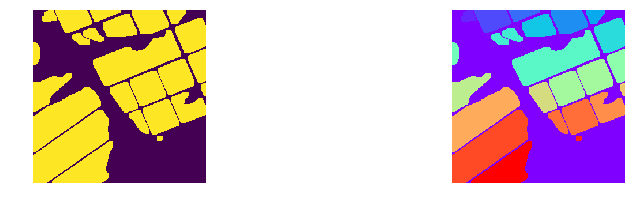

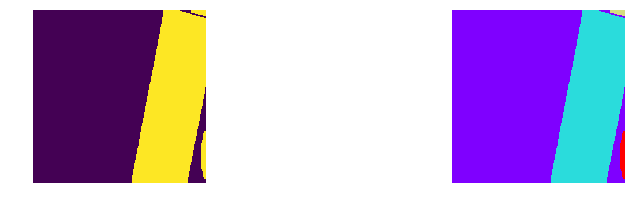

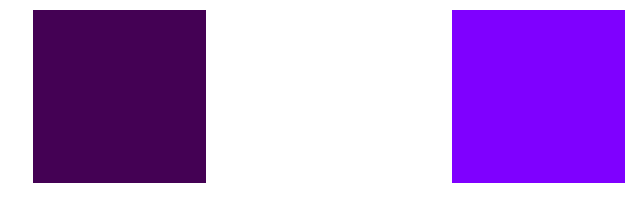

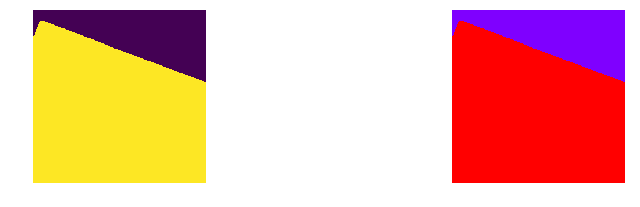

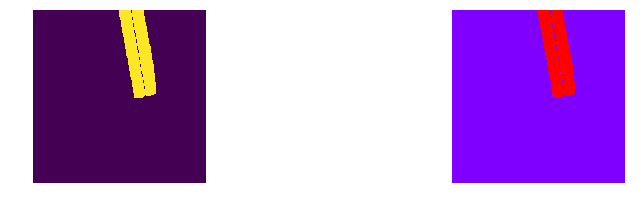

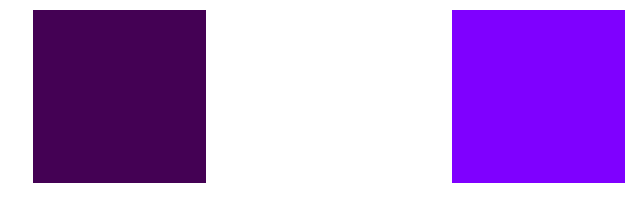

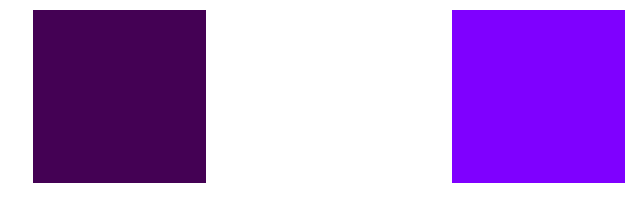

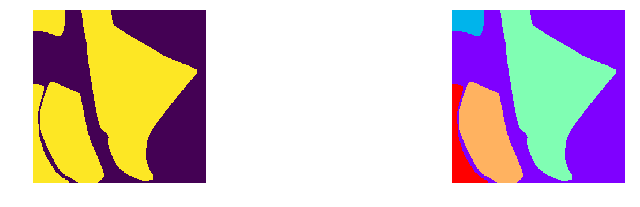

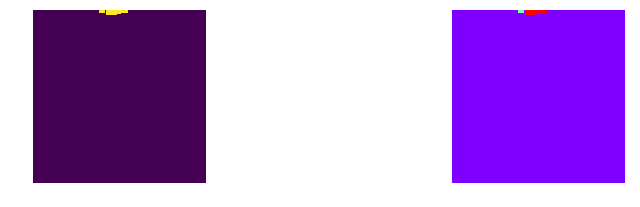

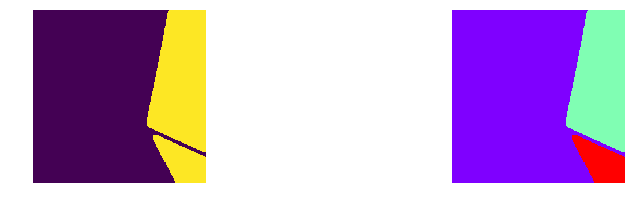

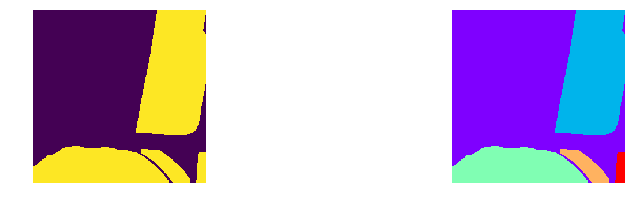

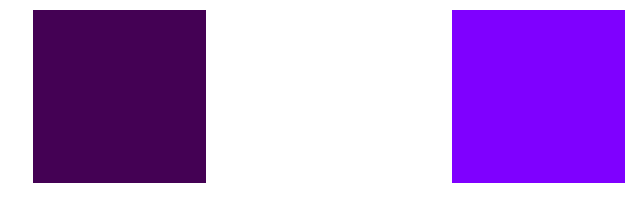

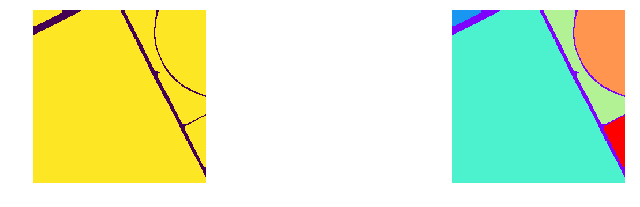

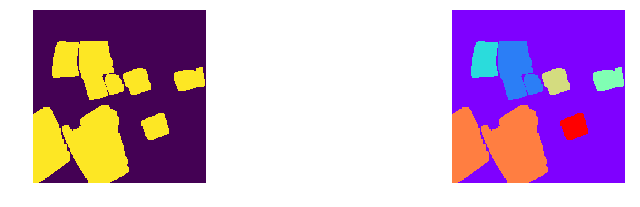

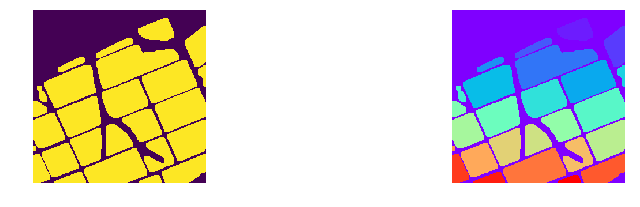

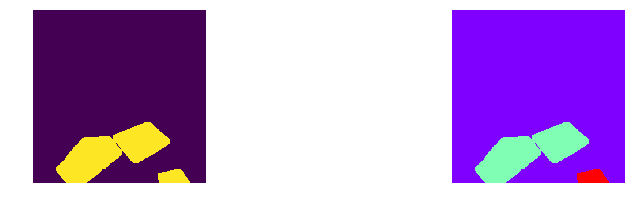

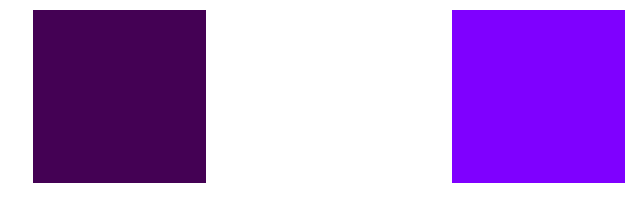

In [8]:
import cv2
from skimage import measure
for i in file_ids_all:
    path = GROUNDTRUTH_DIR+i 
    mask_arr = ski.imread(path)
    kernel88 = np.ones((8,8),np.uint8)
    opened_arr_26 = cv2.morphologyEx(mask_arr, cv2.MORPH_OPEN, kernel88)
    plt.figure(figsize=(9, 3.5))
    plt.subplot(131)
    plt.imshow(opened_arr_26)
    plt.axis('off')
    blobs_labels = measure.label(opened_arr_26, background=0)
    plt.subplot(133)
    plt.imshow(blobs_labels, cmap='rainbow')
    plt.axis('off')
    plt.tight_layout()

/opt/anaconda3/envs/maskrcnn/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/opt/anaconda3/envs/maskrcnn/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


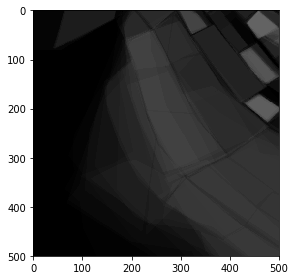

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io as ski
import matplotlib
import matplotlib.pyplot as plt
import copy
%matplotlib inline

test_heatmap_path = '../data/raw/ZA3728469.tif'
heatmap_arr = ski.imread(test_heatmap_path)
ski.imshow(heatmap_arr)

Next we threshold the array it's clear that a value of .1 is incorrect and likely aggregates multiple distinct fields or falsely identified fields.

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


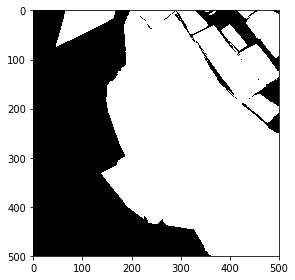

In [2]:
def threshold(arr, threshold):
    arrcopy = copy.copy(arr)
    arrcopy[arrcopy<threshold] = 0
    arrcopy[arrcopy>threshold] = 1
    return arrcopy
heatmap_arr_thresh3 = threshold(heatmap_arr,.1)
ski.imshow(heatmap_arr_thresh3)

So we can only take values closer to maximum agreement - .40887746
I assume this means 40% of workers agreed. Plotting a range of threshold options:

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


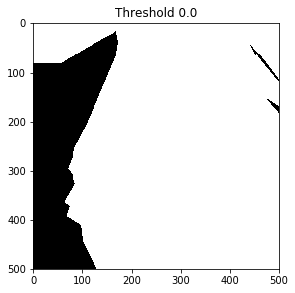

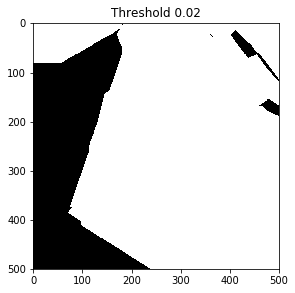

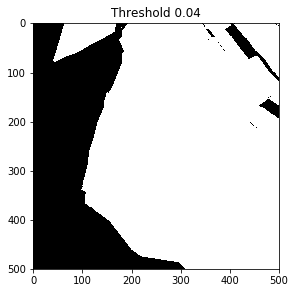

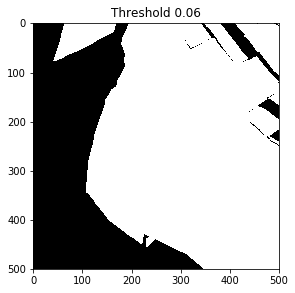

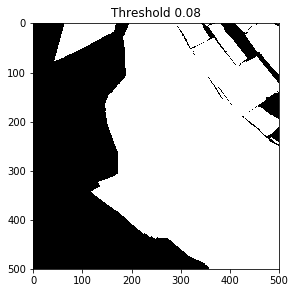

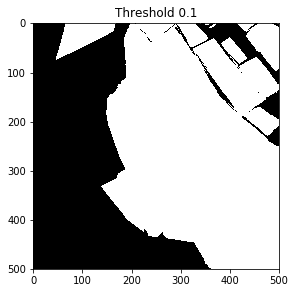

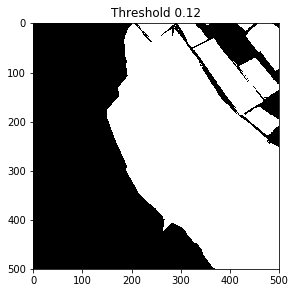

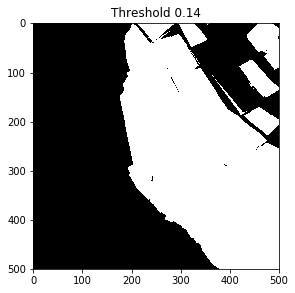

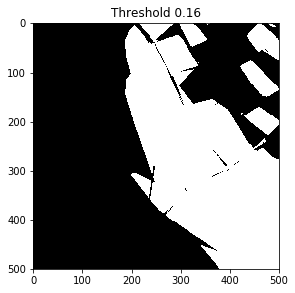

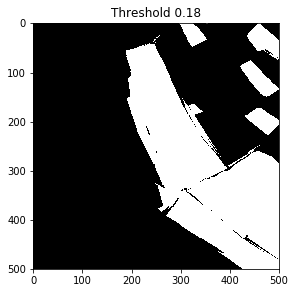

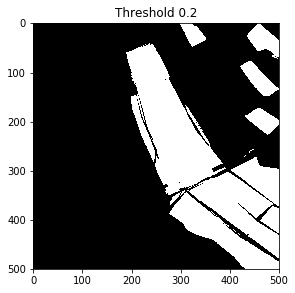

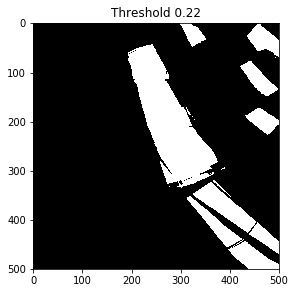

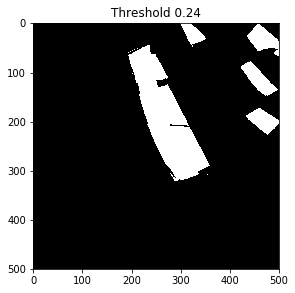

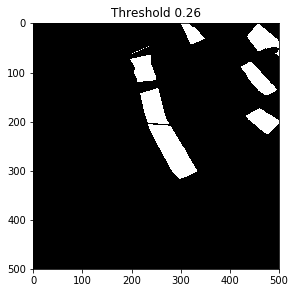

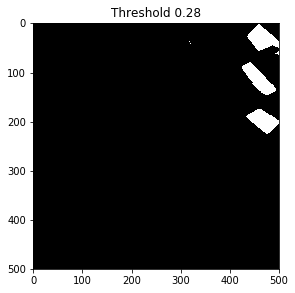

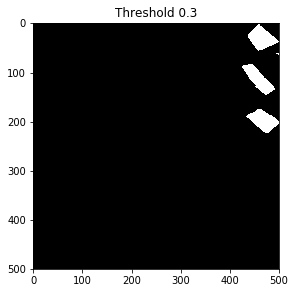

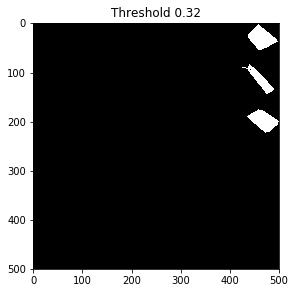

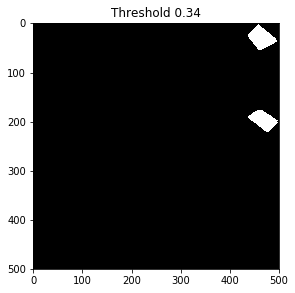

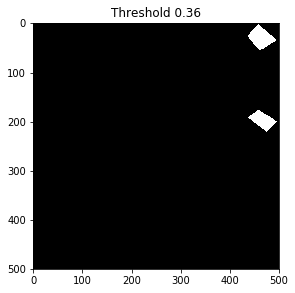

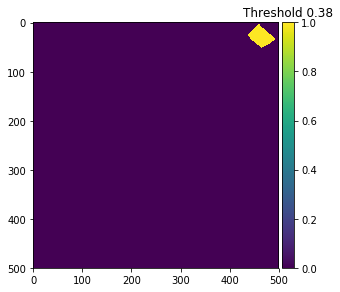

In [3]:
import time
thresholds = np.array(range(0, 40, 2))*.01
for i in thresholds: 
    heatmap_arr_thresh = threshold(heatmap_arr,i)
    plt.figure()
    ski.imshow(heatmap_arr_thresh)
    plt.title("Threshold {}".format(i))


As we can see the threshold has a huge effect on the extent of pixels we determine to be true fields and the number of field objects. 
We certainly need to use the worker's quality score to improve threshold selection. 
For now we will use a value of .26 to get our separated binary masks. We want to get rid of that string of pixels in the upper center that is not a true field. We will later Dilate to get the original pixels back from the larger field objects that are eroded.

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


Text(0.5,1,'Eroded 3x3')

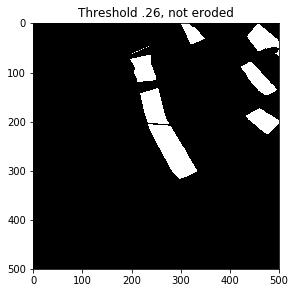

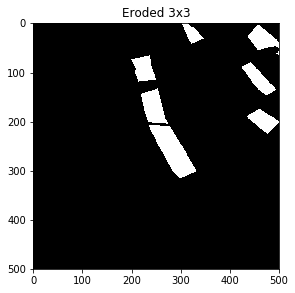

In [4]:
import cv2
arr_26 = threshold(heatmap_arr,.26)
plt.figure()
ski.imshow(arr_26)
plt.title('Threshold .26, not eroded')
kernel33 = np.ones((3,3),np.uint8)
eroded_arr_26 = cv2.erode(arr_26, kernel33, iterations = 1)
plt.figure()
ski.imshow(eroded_arr_26)
plt.title('Eroded 3x3')

That looks pretty good, but there is still some pixels near the edge that look to small to be an individual field object. We can use a larger filter or more iterations to get rid of that.

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


Text(0.5,1,'Eroded with 7x7 Kernel')

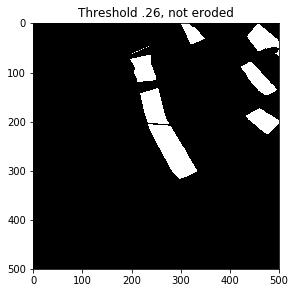

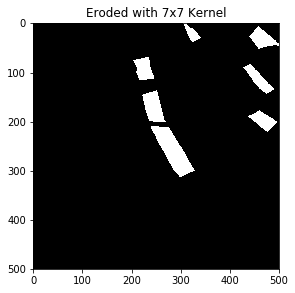

In [5]:
arr_26 = threshold(heatmap_arr,.26)
plt.figure()
ski.imshow(arr_26)
plt.title('Threshold .26, not eroded')
kernel77 = np.ones((7,7),np.uint8)
eroded_arr_26 = cv2.erode(arr_26, kernel77, iterations = 1)
plt.figure()
ski.imshow(eroded_arr_26)
plt.title('Eroded with 7x7 Kernel')

cv2 has a morphology function to do erosion and dilation in a single step to remove noise. Doing this in a single step is called "opening"

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


Text(0.5,1,'Opened with 8x8 Kernel')

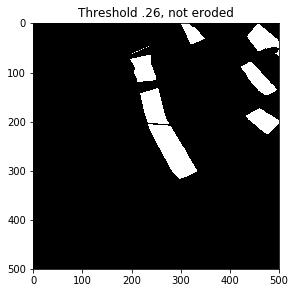

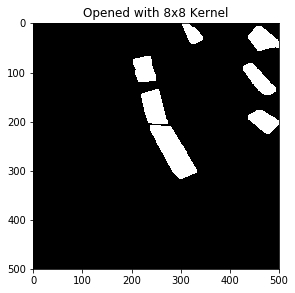

In [6]:
arr_26 = threshold(heatmap_arr,.26)
plt.figure()
ski.imshow(arr_26)
plt.title('Threshold .26, not eroded')
kernel88 = np.ones((8,8),np.uint8)
opened_arr_26 = cv2.morphologyEx(arr_26, cv2.MORPH_OPEN, kernel88)
plt.figure()
ski.imshow(opened_arr_26)
plt.title('Opened with 8x8 Kernel')

The opened result is very close to the un-eroded original, with some slight differences. But no more noisy pixels.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


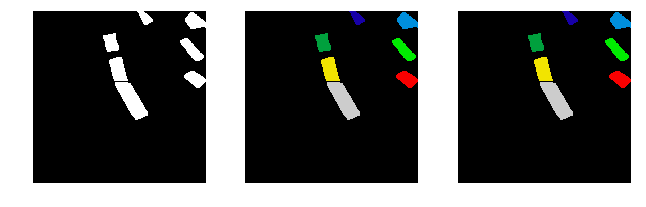

In [16]:
from skimage import measure

all_labels = measure.label(opened_arr_26)
blobs_labels = measure.label(opened_arr_26, background=0)

plt.figure(figsize=(9, 3.5))
plt.subplot(131)
plt.imshow(opened_arr_26, cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(all_labels, cmap='spectral')
plt.axis('off')
plt.subplot(133)
plt.imshow(blobs_labels, cmap='spectral')
plt.axis('off')

plt.tight_layout()
plt.show()

We now have an array where each object, including the background, has it's own value.

In [19]:
np.unique(blobs_labels)

array([0, 1, 2, 3, 4, 5, 6, 7])